<a href="https://colab.research.google.com/github/jarvez31/Object_representation_model/blob/main/check_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
%reset -f

In [169]:
from tensorflow.keras.models import model_from_yaml, model_from_json
from tensorflow import keras
from functions_value_train_local2 import *
import pickle, shapely
import numpy as np
import math as mt
import tempfile
import tensorflow as tf
import pickle
from scipy import misc, ndimage
import glob, csv
from tensorflow.keras import layers
from shapely.geometry import box, Polygon, Point, LinearRing
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Reshape, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, concatenate, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 
from keras.regularizers import Regularizer 
# from keras_gcn import GraphConv
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from sklearn import preprocessing
from numpy import linalg as LA
import pandas as pd
from tensorflow.keras.utils import plot_model
from numpy import matlib
from progressbar import ProgressBar
import tensorflow_model_optimization as tfmot
from matplotlib import cm
main = "Bharat_local_runs/"

## Functions

In [170]:
def model_func(nodes):
  input_pos = Input(shape = 2)
  dense1 = Dense(nodes, activation = 'leaky_relu', name = 'D1')(input_pos)
  output = Dense(1, activation='linear', name='VALUE1')(dense1)

  regressor_model = Model(input_pos, output)

  return regressor_model


def custom_lr_loss(y_true, y_pred):
  global simp_model
  global lr1
  global lr2
  simp_model.optimizer.lr.assign(lr1)
  if y_true == 1:
    simp_model.optimizer.lr.assign(lr2)
  loss_c = tf.keras.losses.MeanSquaredError()
  t_loss = loss_c(y_true, y_pred)
  return t_loss


class ewc_reg(Regularizer):
    def __init__(self, fisher, prior_weights, Lambda):
        self.fisher = fisher
        self.prior_weights = prior_weights
        self.Lambda = Lambda

    def __call__(self, x):
        regularization = 0.
        regularization += self.Lambda * K.sum(self.fisher * K.square(x - self.prior_weights))
        return regularization

    def get_config(self):
        return {'Lambda': float(self.Lambda)}


def model_func2(nodes, dict_mod):
  I_old = dict_mod["fisher"]
  old_wts = dict_mod["weights"]
  reg_loss = [[],[],[],[]]

  input_pos = Input(shape = 2)
  dense1 = Dense(nodes, activation = 'leaky_relu', name = 'D1', 
                 kernel_regularizer=ewc_reg(I_old[0], old_wts[0], Lambda = lam), 
                 bias_regularizer = ewc_reg(I_old[1], old_wts[1], Lambda = lam))(input_pos)
  output = Dense(1, activation='linear', name='VALUE1', 
                 kernel_regularizer=ewc_reg(I_old[-2], old_wts[-2], Lambda = lam), 
                 bias_regularizer = ewc_reg(I_old[-1], old_wts[-1], Lambda = lam))(dense1)

  regressor_model = Model(input_pos, output)

  return regressor_model, reg_loss


def computer_fisher(model, imgset):
  with tf.GradientTape(persistent=True) as gt:
      f_accum = []
      for i in range(len(model.weights)):
          f_accum.append(np.zeros(model.weights[i].shape))
      f_accum = np.array(f_accum)

      img_ind = range(len(imgset))
      for j in range(len(img_ind)):
          img_index = img_ind[j]
          input_mod = np.expand_dims(imgset[img_index],0)
          model_output = model(input_mod)
          grads = gt.gradient(model_output, model.weights)
        
          f_accum += np.square(grads)
          if j%100 == 0:
            print(j)
      f_accum /= len(img_ind)
  del gt
  return f_accum

In [171]:
#@title Setup Parameters
fol1 = "chota_test" #@param {type:"string"}
traj1 = "Aztraj_3.pk1" #@param {type:"string"}
trajo = "Aztraj_1.pk1" #@param {type:"string"}
# imgs = "frames_traj(col_obj)(sh1)_bw_20k.pk1" #@param {type:"string"}
old_model_n = "train_1_ce" #@param {type:"string"}
# fisher_n = "frames_traj(wo)_bw_20k.pk1" #@param {type:"string"}
new_model_n = "train_3_ce" #@param {type:"string"}
epochs = 3000 #@param {type:"number"}
lam = 0.2 #@param {type:"number"}
nodes = 512 #@param {type:"number"}
# test_p =  7#@param {type:"number"}
# img_fol = "traj_four_objs_diffW" #@param {type:"string"}

# std_dev =  0.1 #@param {type:"slider", min:0, max:1, step:0.1}

retrain = True #@param {type:"boolean"}
# retrain_full = True #@param {type:"boolean"}
Train = False #@param {type:"boolean"}
# Retrain_nocat = False #@param {type:"boolean"}
# Analysis = False #@param {type:"boolean"}
pre_conv = True #@param {type:"boolean"}
obj_pres = True #@param {type:"boolean"}
Do_fisher = True #@param {type:"boolean"}
custom_loss_func = True #@param {type:"boolean"}
# pi_use = "no_osc" #@param ["osc", "no_osc"]
# act_func = "relu" #@param {type:"string"}
# learn_rate = 0.001 #@param {type:"number"}
random_state = 20 #@param {type:"number"}

## Trajectory

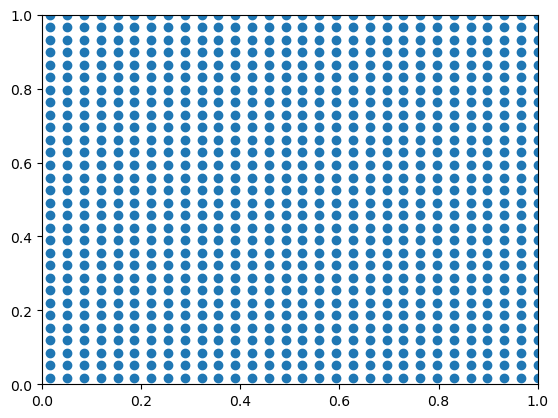

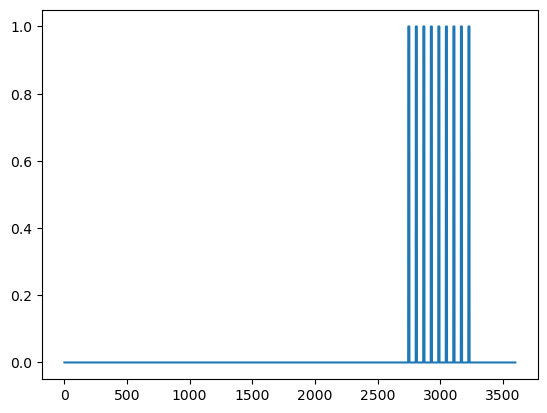

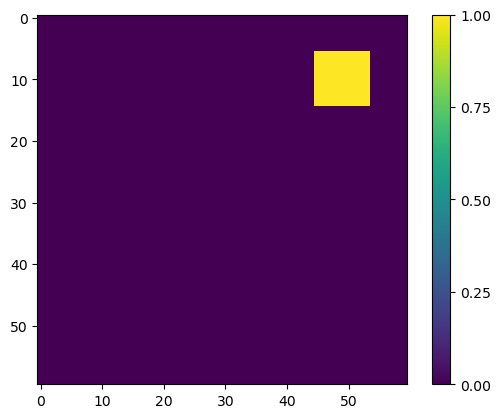

In [172]:
# main = "Bharat_local_runs/"
# fol1 = "value_wale"
# traj1 = "traj_obj(sh1)_20k.pk1"
fol = main + fol1 + "/"
traj = fol + traj1
traj_old = fol + trajo
obj_pres = True

with open(traj, "rb") as f:
    d = pickle.load(f)
    f.close()
locals().update(d)
pos = np.asarray(pos)
reward = np.asarray(reward)

plt.scatter(pos[:,0], pos[:,1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

plt.plot(reward)
plt.show()

rew_bw = reward.reshape((60,60))
rot_img = ndimage.rotate(rew_bw, 90)
plt.imshow(rot_img)
plt.colorbar(ticks = np.linspace(0, 1, 5))
plt.clim(0,1)


## Reward

In [173]:
with open(traj_old, "rb") as f:
    d_old = pickle.load(f)
    f.close()

reward_old = np.asarray(d_old['reward'])
reward_new = reward.copy()
old_reward_index = [i for i, j in enumerate(reward_old) if j]
pos_new = pos.copy()
pos_dat = np.delete(pos_new, old_reward_index, 0)
reward_dat = np.delete(reward_new, old_reward_index)
print(reward_dat.shape)

(3519,)


In [174]:
### ---------  Split the data  -------####
print("----------------Split data in test and train----------------")
from sklearn.model_selection import train_test_split

random_state = np.random.randint(20)

sub_pos = train_test_split(pos_dat, test_size = 0.2, random_state=random_state)
sub_r = train_test_split(reward_dat, test_size = 0.2, random_state=random_state)

sub_pos_t = sub_pos
sub_r_t = sub_r
comp_data = pos

----------------Split data in test and train----------------


## Training

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 D1 (Dense)                  (None, 512)               1536      
                                                                 
 VALUE1 (Dense)              (None, 1)                 513       
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________
Loading weights from previous model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 D1 (Den

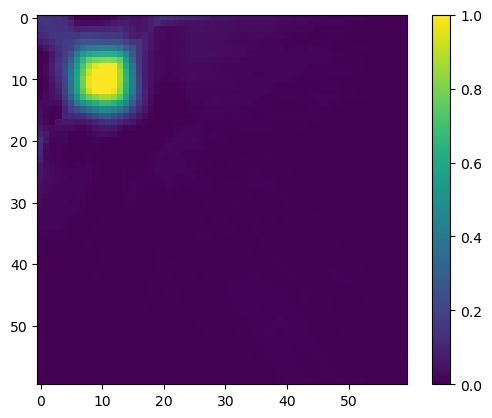

176/176 [==============================] - 2s 6ms/step - loss: 0.0218 - val_loss: 0.0197
loss from regularizer: 0.0001640556292841211
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
113/113 [==============================] - 0s 2ms/step


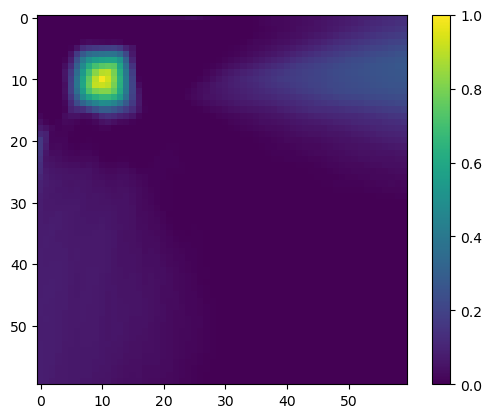

0
176/176 [==============================] - 1s 5ms/step - loss: 0.0204 - val_loss: 0.0227
loss from regularizer: 0.00017570472846273333
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0191 - val_loss: 0.0183
loss from regularizer: 0.0002151507796952501
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0200 - val_loss: 0.0222
loss from regularizer: 0.00020017554925289005
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0210 - val_loss: 0.0315
loss from regularizer: 0.0002596612321212888
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

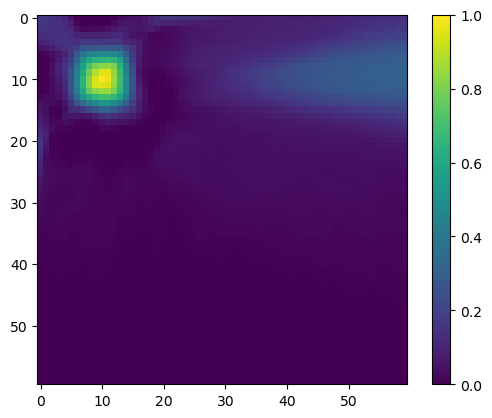

10
176/176 [==============================] - 1s 5ms/step - loss: 0.0205 - val_loss: 0.0212
loss from regularizer: 0.0002774382010102272
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0200 - val_loss: 0.0185
loss from regularizer: 0.00025879222084768116
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0240 - val_loss: 0.0200
loss from regularizer: 0.00030939970747567713
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0178
loss from regularizer: 0.0002732430293690413
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

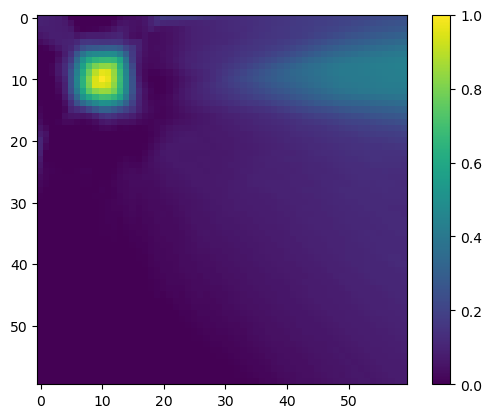

20
176/176 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0190
loss from regularizer: 0.00025595887564122677
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0194 - val_loss: 0.0188
loss from regularizer: 0.00030834850622341037
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0215 - val_loss: 0.0279
loss from regularizer: 0.000288530281977728
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0203 - val_loss: 0.0174
loss from regularizer: 0.00028645762358792126
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

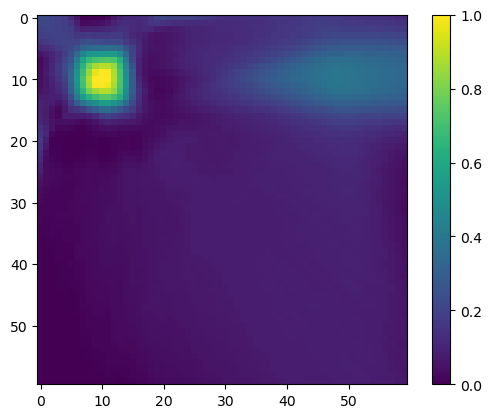

30
176/176 [==============================] - 1s 5ms/step - loss: 0.0198 - val_loss: 0.0189
loss from regularizer: 0.0003082574694417417
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0201 - val_loss: 0.0176
loss from regularizer: 0.00034046018845401704
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0202 - val_loss: 0.0175
loss from regularizer: 0.0002922575222328305
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0202 - val_loss: 0.0178
loss from regularizer: 0.00030220329063013196
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

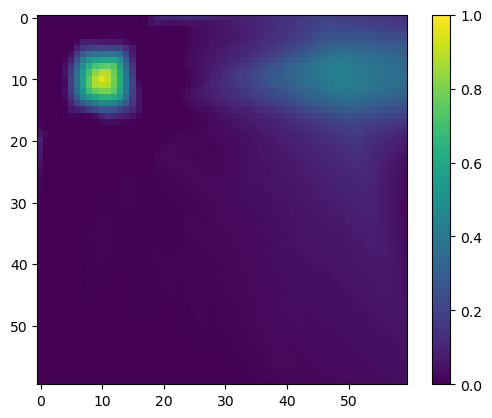

40
176/176 [==============================] - 1s 5ms/step - loss: 0.0197 - val_loss: 0.0170
loss from regularizer: 0.00031369016505777836
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0197 - val_loss: 0.0171
loss from regularizer: 0.00034483190393075347
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0194 - val_loss: 0.0245
loss from regularizer: 0.00030272905132733285
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0186 - val_loss: 0.0173
loss from regularizer: 0.00033496200921945274
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

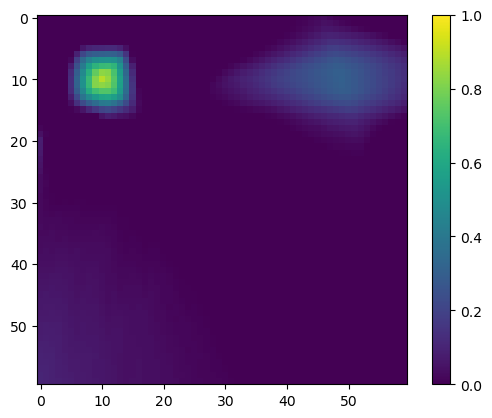

50
176/176 [==============================] - 1s 5ms/step - loss: 0.0197 - val_loss: 0.0182
loss from regularizer: 0.00033205930958501995
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0179 - val_loss: 0.0176
loss from regularizer: 0.00036804258706979454
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0184 - val_loss: 0.0189
loss from regularizer: 0.00034138900809921324
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0186 - val_loss: 0.0169
loss from regularizer: 0.0003329623432364315
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

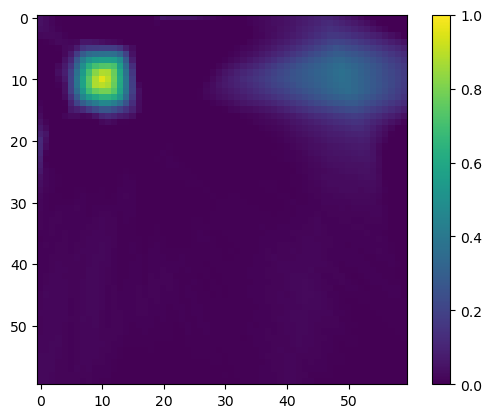

60
176/176 [==============================] - 1s 5ms/step - loss: 0.0186 - val_loss: 0.0168
loss from regularizer: 0.00032445971737615764
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0183 - val_loss: 0.0177
loss from regularizer: 0.0003684069379232824
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0184 - val_loss: 0.0168
loss from regularizer: 0.0003594743029680103
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0181 - val_loss: 0.0195
loss from regularizer: 0.0003954466956201941
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

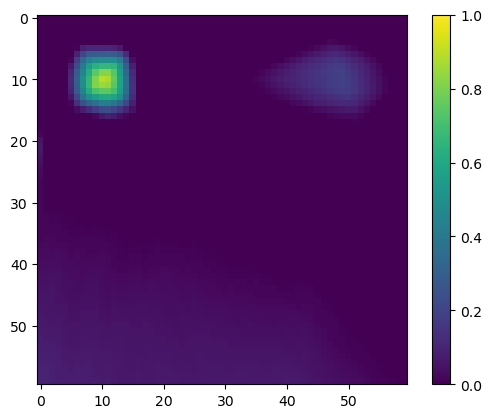

70
176/176 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0166
loss from regularizer: 0.00033459020778536797
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0193
loss from regularizer: 0.0003554969443939626
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0179 - val_loss: 0.0174
loss from regularizer: 0.0003693090984597802
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0183 - val_loss: 0.0165
loss from regularizer: 0.0003861931909341365
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

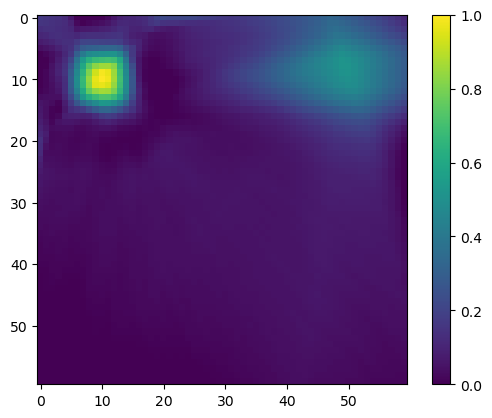

80
176/176 [==============================] - 1s 5ms/step - loss: 0.0181 - val_loss: 0.0187
loss from regularizer: 0.00037683831760659814
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0170
loss from regularizer: 0.0003699172812048346
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0175 - val_loss: 0.0163
loss from regularizer: 0.0003647662524599582
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0176
loss from regularizer: 0.0004226981254760176
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

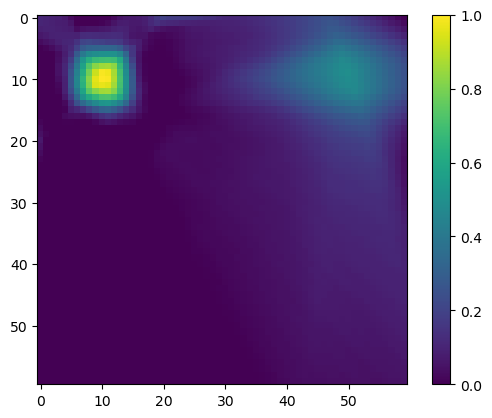

90
176/176 [==============================] - 1s 5ms/step - loss: 0.0207 - val_loss: 0.0200
loss from regularizer: 0.00039815730997361243
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0184 - val_loss: 0.0161
loss from regularizer: 0.0003857601259369403
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0167 - val_loss: 0.0161
loss from regularizer: 0.00034655138733796775
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0159
loss from regularizer: 0.00037688700831495225
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

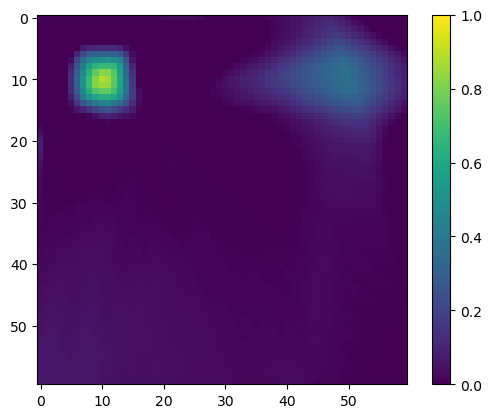

100
176/176 [==============================] - 1s 5ms/step - loss: 0.0172 - val_loss: 0.0183
loss from regularizer: 0.00038881346699781716
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0181 - val_loss: 0.0187
loss from regularizer: 0.00040735158836469054
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0178 - val_loss: 0.0186
loss from regularizer: 0.0003585894301068038
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0176 - val_loss: 0.0165
loss from regularizer: 0.0003763585991691798
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

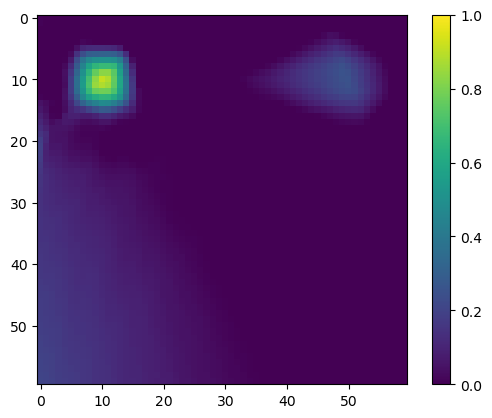

110
176/176 [==============================] - 1s 5ms/step - loss: 0.0188 - val_loss: 0.0197
loss from regularizer: 0.00037595463800244033
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0168 - val_loss: 0.0159
loss from regularizer: 0.00040641569648869336
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0169
loss from regularizer: 0.0003754463978111744
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0162
loss from regularizer: 0.00038827108801342547
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

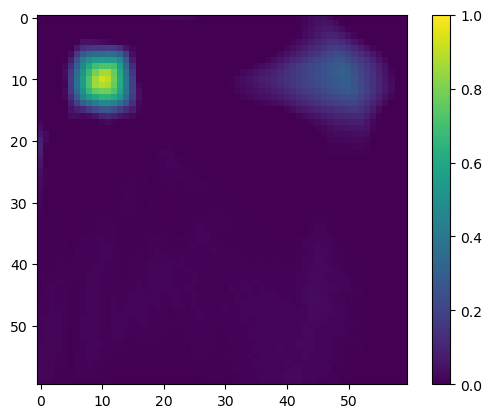

120
176/176 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0169
loss from regularizer: 0.0003864976461045444
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0174 - val_loss: 0.0164
loss from regularizer: 0.0003967788361478597
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0169 - val_loss: 0.0175
loss from regularizer: 0.00035159740946255624
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0179 - val_loss: 0.0195
loss from regularizer: 0.0003929993836209178
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

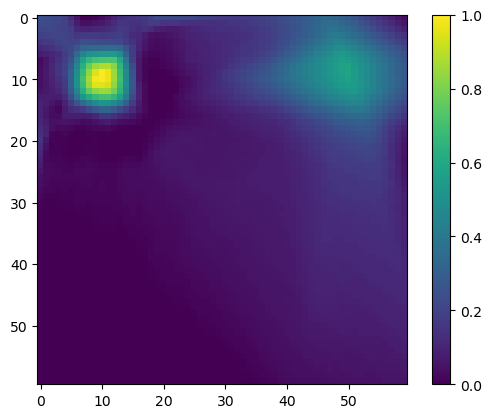

130
176/176 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0165
loss from regularizer: 0.00038563983980566263
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0178 - val_loss: 0.0167
loss from regularizer: 0.0004090472939424217
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0172 - val_loss: 0.0170
loss from regularizer: 0.00038906148984096944
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0161
loss from regularizer: 0.00036563046160154045
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

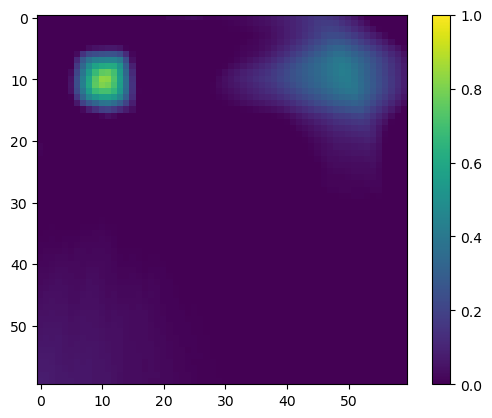

140
176/176 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0180
loss from regularizer: 0.0003727299626916647
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0181
loss from regularizer: 0.00044660017010755837
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0164
loss from regularizer: 0.0004242211871314794
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0172 - val_loss: 0.0177
loss from regularizer: 0.00043715524952858686
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

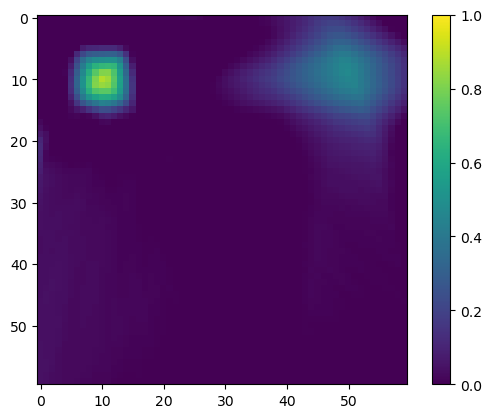

150
176/176 [==============================] - 1s 5ms/step - loss: 0.0168 - val_loss: 0.0191
loss from regularizer: 0.0004154763591941446
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0175 - val_loss: 0.0152
loss from regularizer: 0.0003988253010902554
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0172 - val_loss: 0.0163
loss from regularizer: 0.0003659889043774456
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0176 - val_loss: 0.0162
loss from regularizer: 0.0004032971046399325
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

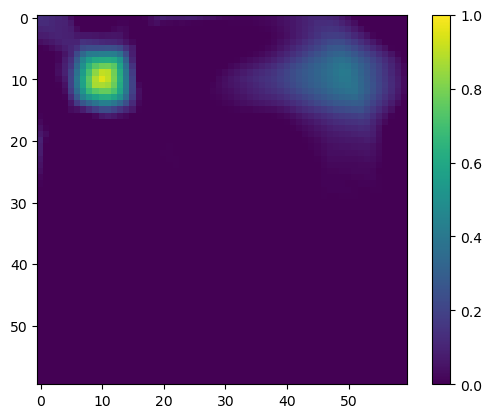

160
176/176 [==============================] - 1s 5ms/step - loss: 0.0184 - val_loss: 0.0160
loss from regularizer: 0.0003923580516129732
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0174 - val_loss: 0.0152
loss from regularizer: 0.0003838117700070143
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0167 - val_loss: 0.0156
loss from regularizer: 0.00041133243939839303
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0160
loss from regularizer: 0.00039683334762230515
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

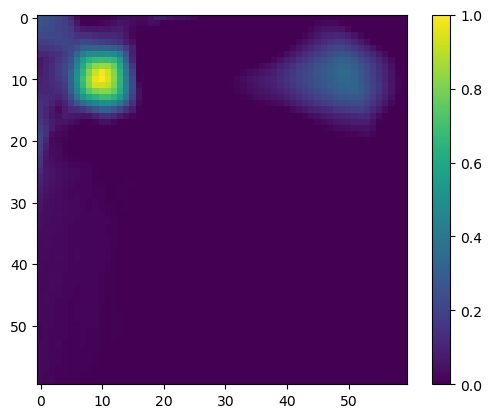

170
176/176 [==============================] - 1s 6ms/step - loss: 0.0179 - val_loss: 0.0192
loss from regularizer: 0.0003956336877308786
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0169 - val_loss: 0.0175
loss from regularizer: 0.0003821801219601184
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0184 - val_loss: 0.0158
loss from regularizer: 0.00039154861588031054
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0186 - val_loss: 0.0151
loss from regularizer: 0.0004001440538559109
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

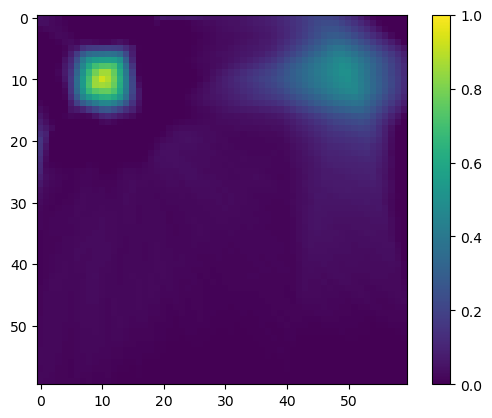

180
176/176 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0162
loss from regularizer: 0.00040036035352386534
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0169 - val_loss: 0.0157
loss from regularizer: 0.0003990749246440828
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0175 - val_loss: 0.0155
loss from regularizer: 0.0003869487263727933
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0167 - val_loss: 0.0173
loss from regularizer: 0.0004107575514353812
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

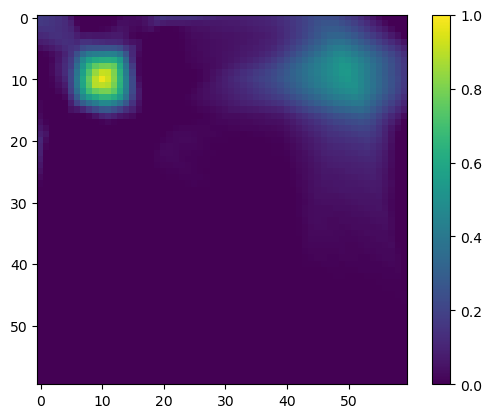

190
176/176 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0156
loss from regularizer: 0.00038177159149199724
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0163
loss from regularizer: 0.0003705635026562959
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0171 - val_loss: 0.0152
loss from regularizer: 0.00037545477971434593
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0165
loss from regularizer: 0.000366102991392836
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

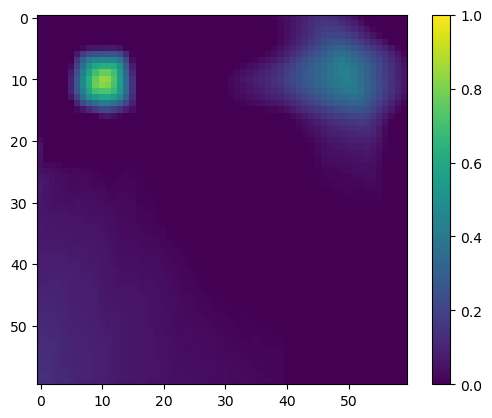

200
176/176 [==============================] - 1s 5ms/step - loss: 0.0178 - val_loss: 0.0159
loss from regularizer: 0.0003812601789832115
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0232
loss from regularizer: 0.00039959384594112635
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0205
loss from regularizer: 0.00039660019683651626
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0165 - val_loss: 0.0163
loss from regularizer: 0.00038919219514355063
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

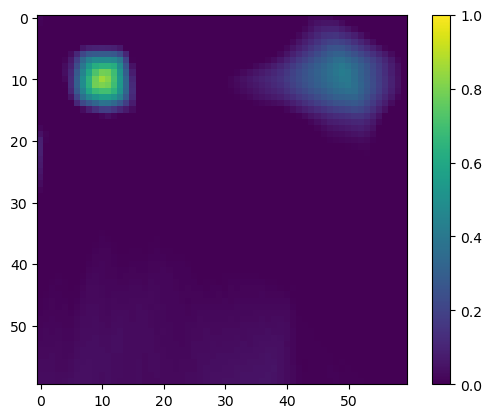

210
176/176 [==============================] - 1s 5ms/step - loss: 0.0175 - val_loss: 0.0170
loss from regularizer: 0.0003914865665137768
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0172 - val_loss: 0.0159
loss from regularizer: 0.00038532036705873907
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0163 - val_loss: 0.0159
loss from regularizer: 0.0003888883802574128
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0185
loss from regularizer: 0.00039653503336012363
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

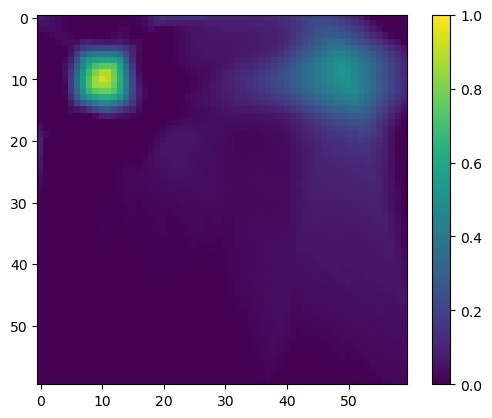

220
176/176 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0150
loss from regularizer: 0.00042578185093589127
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0178
loss from regularizer: 0.00043696537613868713
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0162 - val_loss: 0.0168
loss from regularizer: 0.0003991316189058125
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0167
loss from regularizer: 0.000396317191189155
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

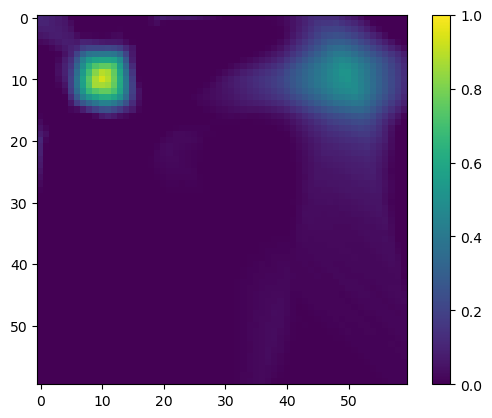

230
176/176 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0216
loss from regularizer: 0.00040048768278211355
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0167 - val_loss: 0.0152
loss from regularizer: 0.0003836296091321856
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0147
loss from regularizer: 0.00036172239924781024
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0153
loss from regularizer: 0.00040483628981746733
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

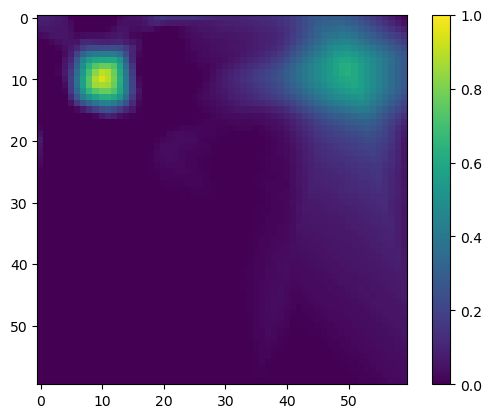

240
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0218
loss from regularizer: 0.0003960370959248394
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0184 - val_loss: 0.0157
loss from regularizer: 0.0003604526282288134
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0167 - val_loss: 0.0193
loss from regularizer: 0.0004082371888216585
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0169 - val_loss: 0.0149
loss from regularizer: 0.00039296754403039813
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

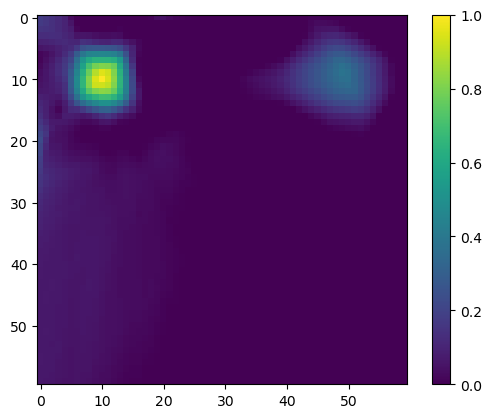

250
176/176 [==============================] - 1s 5ms/step - loss: 0.0163 - val_loss: 0.0149
loss from regularizer: 0.0003840963472612202
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0177
loss from regularizer: 0.00039668611134402454
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0169 - val_loss: 0.0172
loss from regularizer: 0.0004019501502625644
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0182
loss from regularizer: 0.00038509382284246385
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

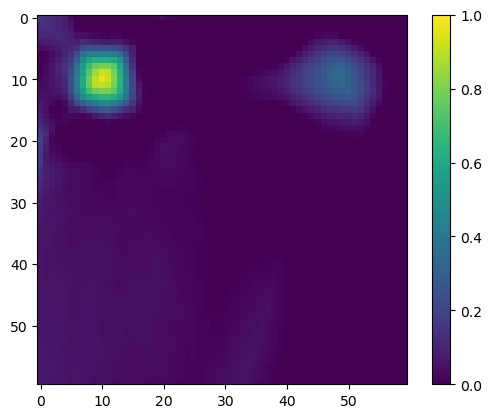

260
176/176 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0152
loss from regularizer: 0.000358312128810212
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0173 - val_loss: 0.0140
loss from regularizer: 0.0004068184643983841
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0152
loss from regularizer: 0.00038325879722833633
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0165
loss from regularizer: 0.0003991744597442448
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

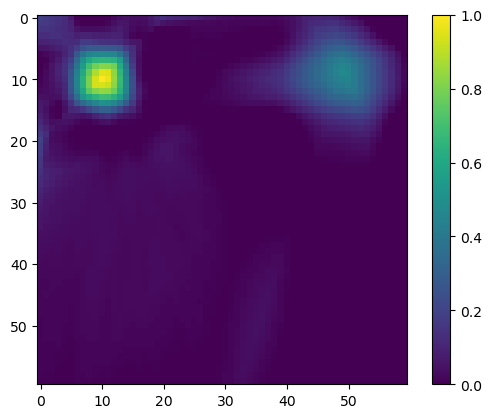

270
176/176 [==============================] - 1s 5ms/step - loss: 0.0170 - val_loss: 0.0148
loss from regularizer: 0.00039054316584952176
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0160 - val_loss: 0.0141
loss from regularizer: 0.0003807061293628067
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0160 - val_loss: 0.0200
loss from regularizer: 0.00039426281000487506
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0164 - val_loss: 0.0150
loss from regularizer: 0.0004103679384570569
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

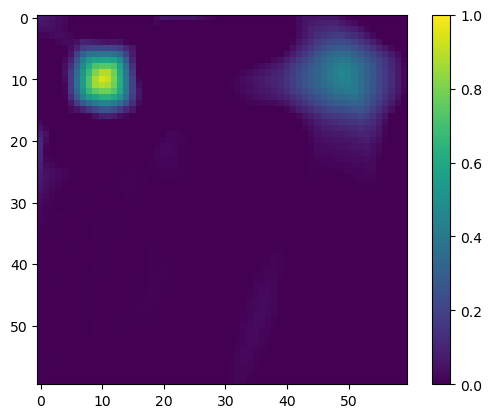

280
176/176 [==============================] - 1s 5ms/step - loss: 0.0163 - val_loss: 0.0146
loss from regularizer: 0.0003932284307666123
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0156 - val_loss: 0.0153
loss from regularizer: 0.0003653824096545577
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0156 - val_loss: 0.0138
loss from regularizer: 0.0003739631501957774
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0148
loss from regularizer: 0.0003738358791451901
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

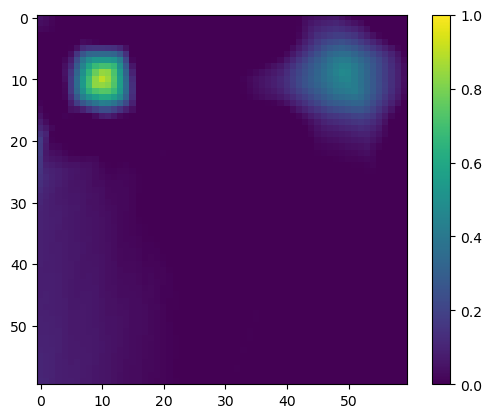

290
176/176 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0170
loss from regularizer: 0.0003716127248480916
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0203
loss from regularizer: 0.0003951789694838226
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0140
loss from regularizer: 0.0004102827806491405
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0152
loss from regularizer: 0.0003803119179792702
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

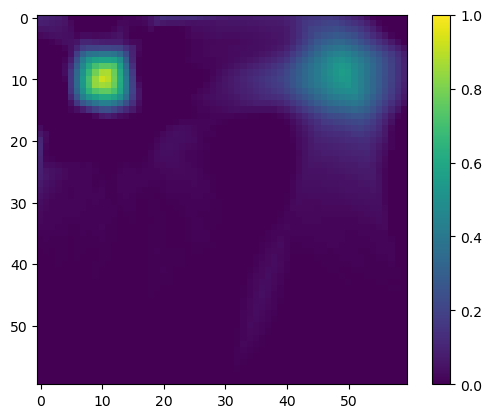

300
176/176 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0191
loss from regularizer: 0.00038634202792309225
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0168 - val_loss: 0.0160
loss from regularizer: 0.0003622454823926091
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0146
loss from regularizer: 0.00036536462721414864
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0162 - val_loss: 0.0147
loss from regularizer: 0.00039559172000736
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

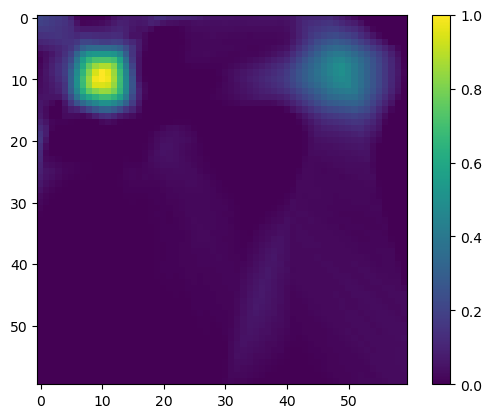

310
176/176 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0141
loss from regularizer: 0.0003638422058429569
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0177 - val_loss: 0.0173
loss from regularizer: 0.00036447515594772995
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0146
loss from regularizer: 0.000397426396375522
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0147
loss from regularizer: 0.00035898882197216153
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

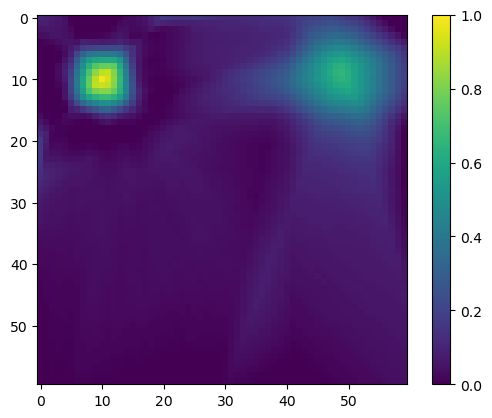

320
176/176 [==============================] - 1s 5ms/step - loss: 0.0166 - val_loss: 0.0171
loss from regularizer: 0.0003758298116736114
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0194
loss from regularizer: 0.00038011526339687407
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0163 - val_loss: 0.0165
loss from regularizer: 0.0003858152776956558
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0139
loss from regularizer: 0.00039932725485414267
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

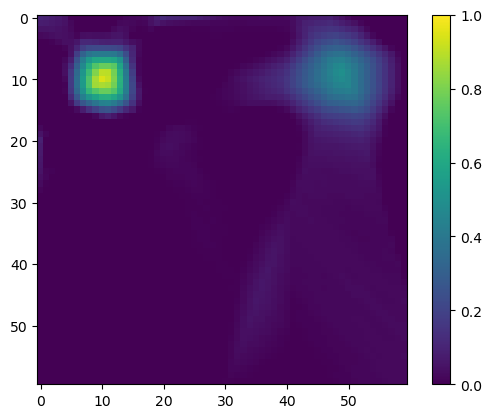

330
176/176 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0158
loss from regularizer: 0.0004061779472976923
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0138
loss from regularizer: 0.00037617154885083437
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0160
loss from regularizer: 0.0003913279506377876
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0162 - val_loss: 0.0140
loss from regularizer: 0.00036543098394759
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [====

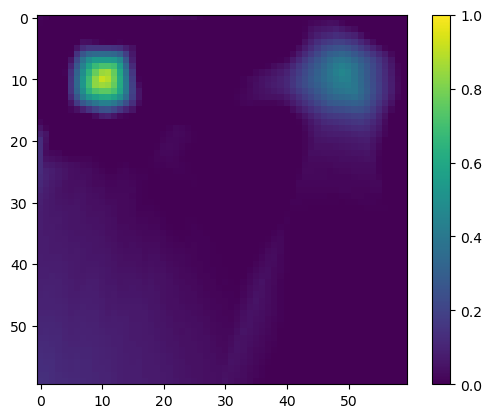

340
176/176 [==============================] - 1s 5ms/step - loss: 0.0156 - val_loss: 0.0158
loss from regularizer: 0.0003743974375538528
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0144
loss from regularizer: 0.00038005204987712204
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.0135
loss from regularizer: 0.0003709639422595501
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0212
loss from regularizer: 0.0003977512242272496
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

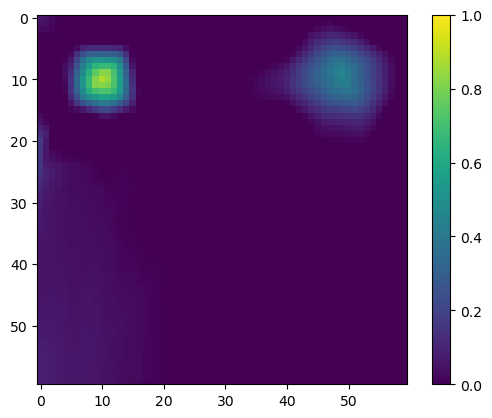

350
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0157
loss from regularizer: 0.00036253570578992367
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0151 - val_loss: 0.0150
loss from regularizer: 0.0003930808452423662
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0150 - val_loss: 0.0135
loss from regularizer: 0.0003734243509825319
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0151 - val_loss: 0.0139
loss from regularizer: 0.00036603742046281695
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

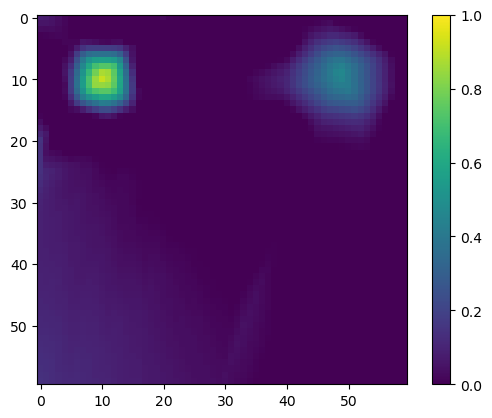

360
176/176 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0216
loss from regularizer: 0.0004454664303921163
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0133
loss from regularizer: 0.00040716584771871567
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.0135
loss from regularizer: 0.0003796869714278728
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0152
loss from regularizer: 0.0003856761904899031
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

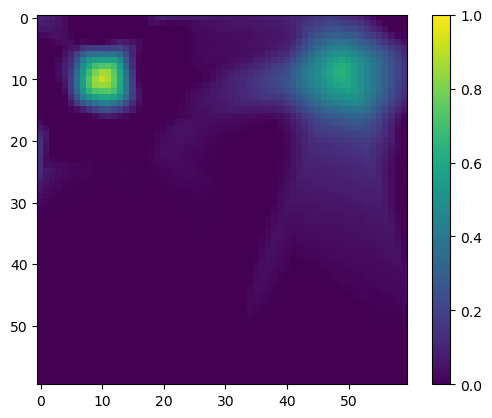

370
176/176 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0144
loss from regularizer: 0.00038135689101181924
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0151 - val_loss: 0.0166
loss from regularizer: 0.00040348933544009924
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0208
loss from regularizer: 0.0004284933384042233
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0153
loss from regularizer: 0.0004122213867958635
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

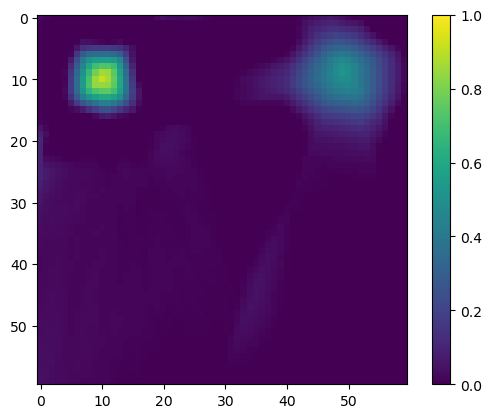

380
176/176 [==============================] - 1s 5ms/step - loss: 0.0156 - val_loss: 0.0147
loss from regularizer: 0.0004026082460768521
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0182
loss from regularizer: 0.0003728978626895696
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0160 - val_loss: 0.0136
loss from regularizer: 0.0003852856170851737
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0145
loss from regularizer: 0.0004343440232332796
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

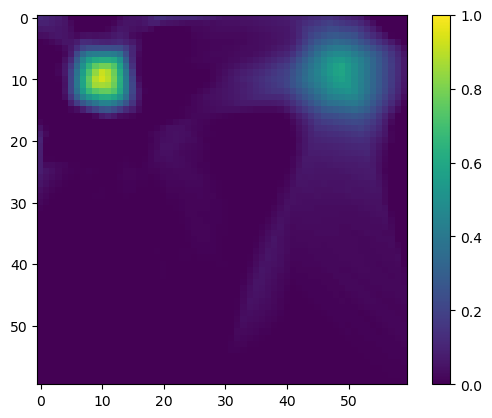

390
176/176 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0137
loss from regularizer: 0.00037195757613517344
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0148
loss from regularizer: 0.0003927365178242326
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0156 - val_loss: 0.0174
loss from regularizer: 0.00039123056922107935
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0185
loss from regularizer: 0.00038933256291784346
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

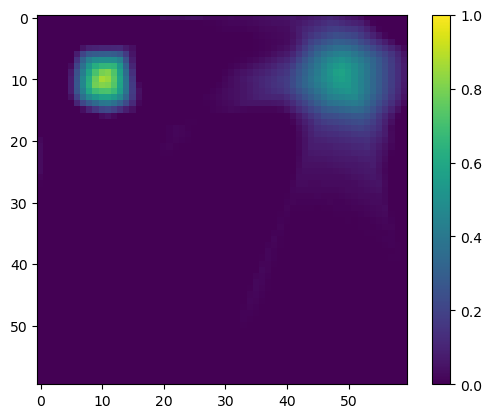

400
176/176 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0145
loss from regularizer: 0.00039069956983439624
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0130
loss from regularizer: 0.0003958590386901051
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0138
loss from regularizer: 0.0004050493589602411
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0150 - val_loss: 0.0144
loss from regularizer: 0.0003964015922974795
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

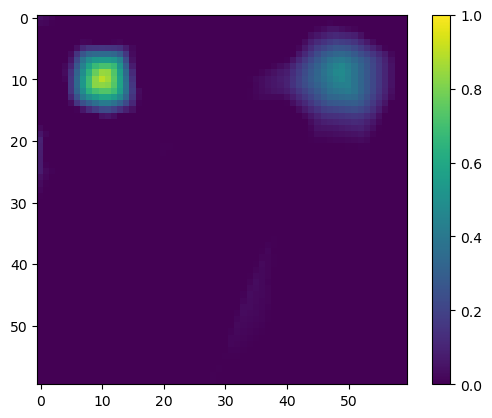

410
176/176 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.0135
loss from regularizer: 0.00038101145764812827
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0150 - val_loss: 0.0156
loss from regularizer: 0.00038866387330926955
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0144
loss from regularizer: 0.0003914272238034755
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0161 - val_loss: 0.0216
loss from regularizer: 0.00042148743523284793
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

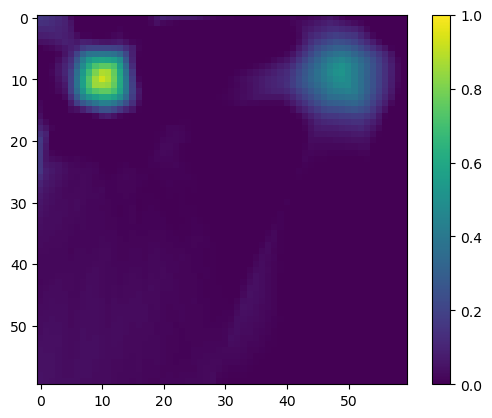

420
176/176 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0130
loss from regularizer: 0.00038858651532791555
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0147 - val_loss: 0.0145
loss from regularizer: 0.00039748658309690654
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0133
loss from regularizer: 0.0003584148653317243
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0151 - val_loss: 0.0132
loss from regularizer: 0.000389138818718493
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

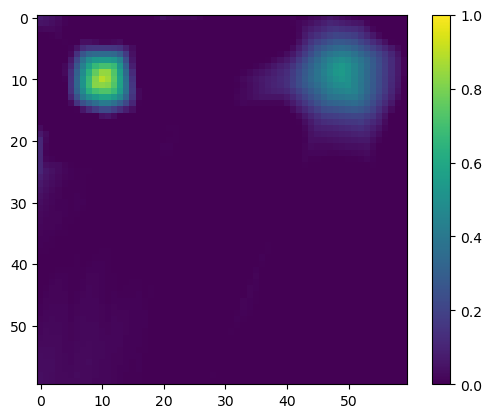

430
176/176 [==============================] - 1s 5ms/step - loss: 0.0142 - val_loss: 0.0162
loss from regularizer: 0.00036433018976822495
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0143
loss from regularizer: 0.0004017580358777195
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0160 - val_loss: 0.0140
loss from regularizer: 0.0003977484302595258
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0152
loss from regularizer: 0.0003707694704644382
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

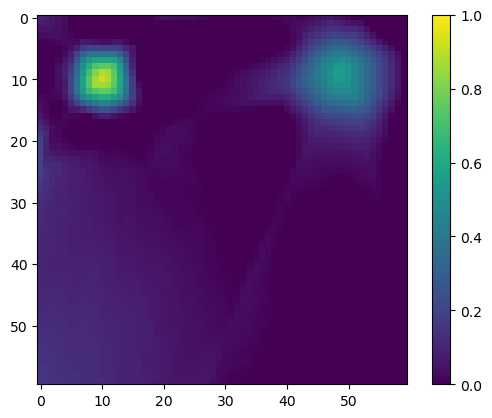

440
176/176 [==============================] - 1s 5ms/step - loss: 0.0147 - val_loss: 0.0126
loss from regularizer: 0.00039658028981648386
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0148 - val_loss: 0.0138
loss from regularizer: 0.0003997302264906466
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0137
loss from regularizer: 0.0003867669147439301
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0147 - val_loss: 0.0171
loss from regularizer: 0.0003783170541282743
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

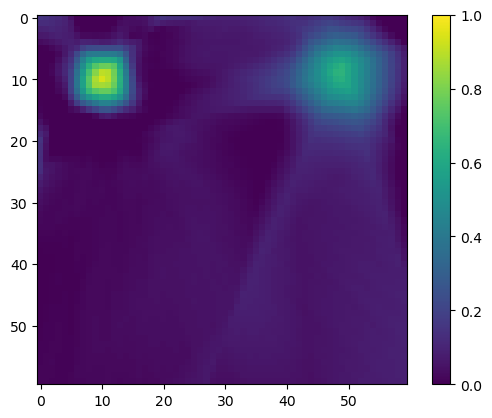

450
176/176 [==============================] - 1s 5ms/step - loss: 0.0162 - val_loss: 0.0126
loss from regularizer: 0.0003821788704954088
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0127
loss from regularizer: 0.0003769493196159601
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.0183
loss from regularizer: 0.00038980040699243546
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0127
loss from regularizer: 0.000387042760848999
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

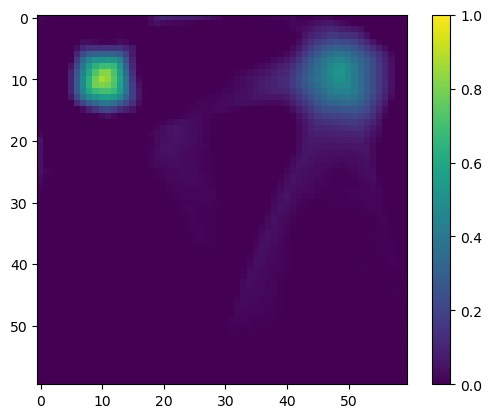

460
176/176 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0137
loss from regularizer: 0.0003822913859039545
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0131
loss from regularizer: 0.0003821162390522659
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0141 - val_loss: 0.0130
loss from regularizer: 0.0003780738916248083
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0129
loss from regularizer: 0.0003889776417054236
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

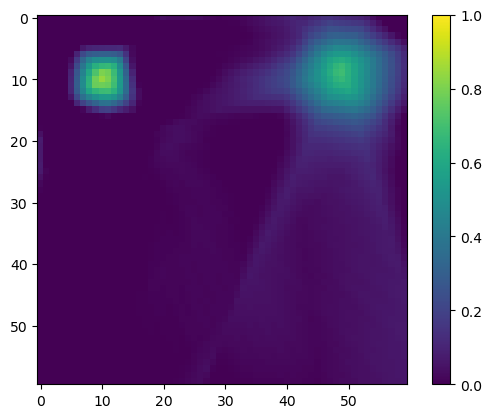

470
176/176 [==============================] - 1s 5ms/step - loss: 0.0159 - val_loss: 0.0130
loss from regularizer: 0.0003618662594817579
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0126
loss from regularizer: 0.0003722472465597093
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0151 - val_loss: 0.0171
loss from regularizer: 0.0003857577103190124
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0139
loss from regularizer: 0.00036733518936671317
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

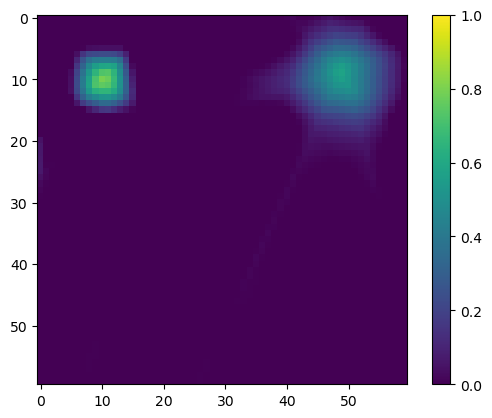

480
176/176 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0157
loss from regularizer: 0.00036815539351664484
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0176
loss from regularizer: 0.0003908111248165369
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0148 - val_loss: 0.0132
loss from regularizer: 0.00036682322388514876
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0141
loss from regularizer: 0.00041023895028047264
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

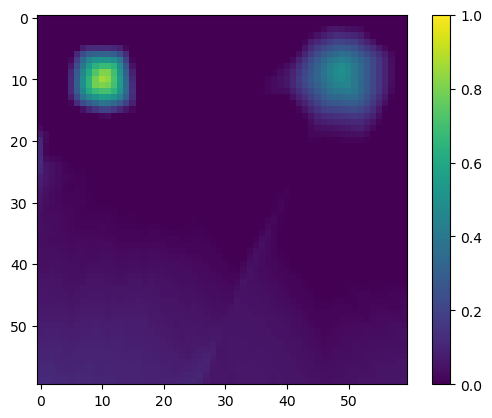

490
176/176 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0125
loss from regularizer: 0.000375057861674577
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0127
loss from regularizer: 0.00038119673263281584
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0155
loss from regularizer: 0.0003886137856170535
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0123
loss from regularizer: 0.0003917390713468194
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

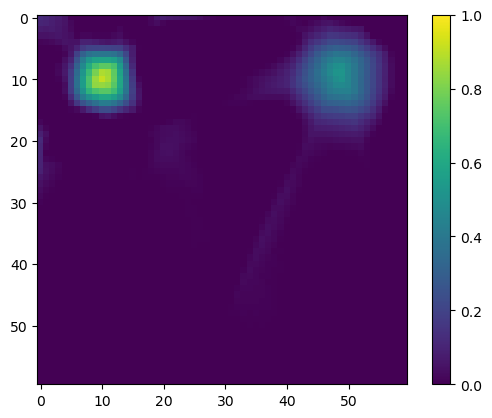

500
176/176 [==============================] - 1s 5ms/step - loss: 0.0147 - val_loss: 0.0138
loss from regularizer: 0.0003762457345146686
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0136
loss from regularizer: 0.00037832342786714435
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0137
loss from regularizer: 0.0003814692026935518
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0142 - val_loss: 0.0162
loss from regularizer: 0.0003719972155522555
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

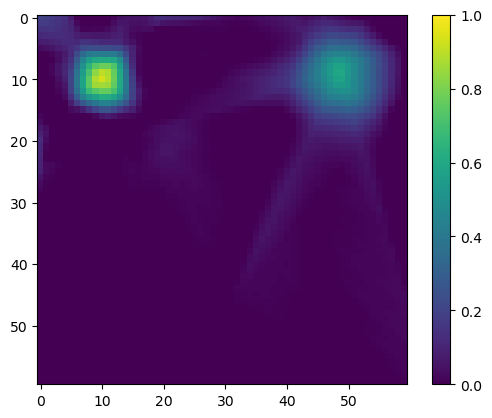

510
176/176 [==============================] - 1s 5ms/step - loss: 0.0137 - val_loss: 0.0195
loss from regularizer: 0.0003838987904600799
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0140 - val_loss: 0.0132
loss from regularizer: 0.0003534670395310968
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0143
loss from regularizer: 0.0003768581373151392
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0150 - val_loss: 0.0337
loss from regularizer: 0.0003816431562881917
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

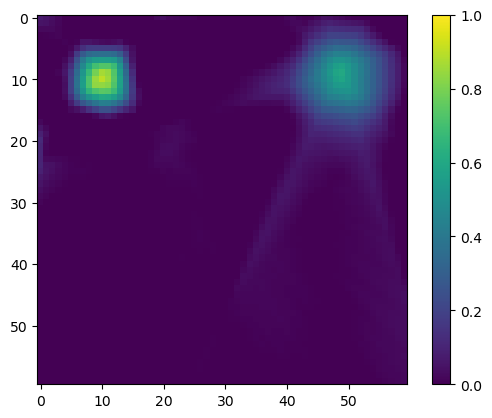

520
176/176 [==============================] - 1s 5ms/step - loss: 0.0137 - val_loss: 0.0154
loss from regularizer: 0.0003752394113689661
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0142
loss from regularizer: 0.0004019696789328009
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0135 - val_loss: 0.0130
loss from regularizer: 0.00036092090886086226
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0139
loss from regularizer: 0.00036738248309120536
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

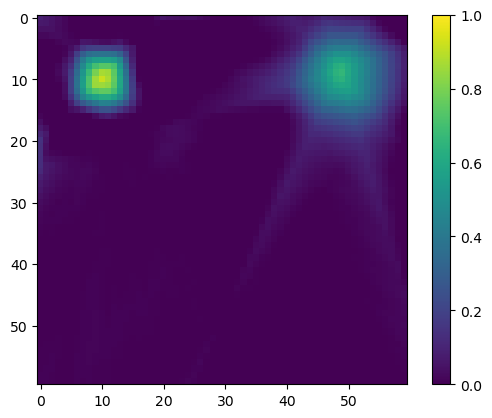

530
176/176 [==============================] - 1s 5ms/step - loss: 0.0134 - val_loss: 0.0124
loss from regularizer: 0.00037433323450386524
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0134 - val_loss: 0.0126
loss from regularizer: 0.00037184826214797795
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0146 - val_loss: 0.0123
loss from regularizer: 0.00037777484976686537
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0135 - val_loss: 0.0130
loss from regularizer: 0.0003731191682163626
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

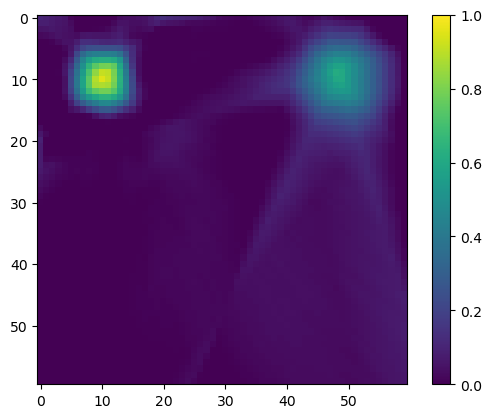

540
176/176 [==============================] - 1s 5ms/step - loss: 0.0138 - val_loss: 0.0132
loss from regularizer: 0.00036414345959201455
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0135 - val_loss: 0.0123
loss from regularizer: 0.00035795971052721143
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0140 - val_loss: 0.0166
loss from regularizer: 0.00039113432285375893
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0155 - val_loss: 0.0131
loss from regularizer: 0.0003463441098574549
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

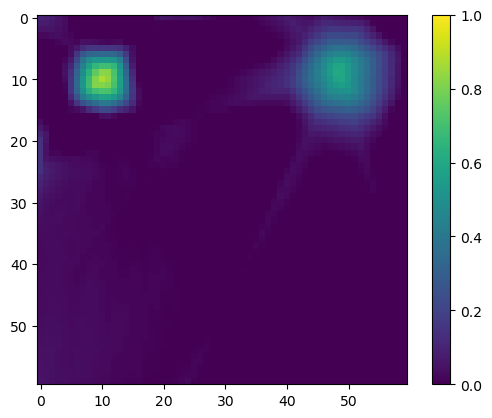

550
176/176 [==============================] - 1s 5ms/step - loss: 0.0142 - val_loss: 0.0161
loss from regularizer: 0.0003589247353374958
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0137 - val_loss: 0.0129
loss from regularizer: 0.00037312976201064885
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0140
loss from regularizer: 0.00038406229577958584
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0147 - val_loss: 0.0123
loss from regularizer: 0.0003452892124187201
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

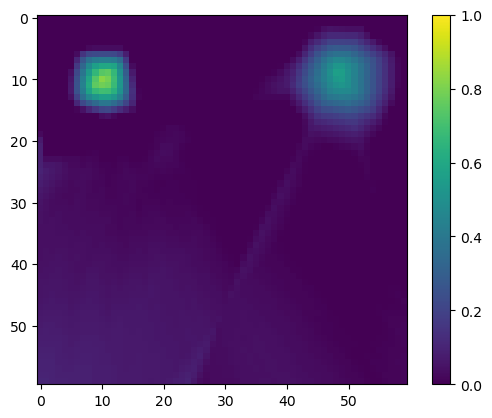

560
176/176 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0121
loss from regularizer: 0.00035252899397164583
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0140 - val_loss: 0.0138
loss from regularizer: 0.00037264745333231986
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0147 - val_loss: 0.0123
loss from regularizer: 0.000358824705472216
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0150
loss from regularizer: 0.00036662843194790184
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

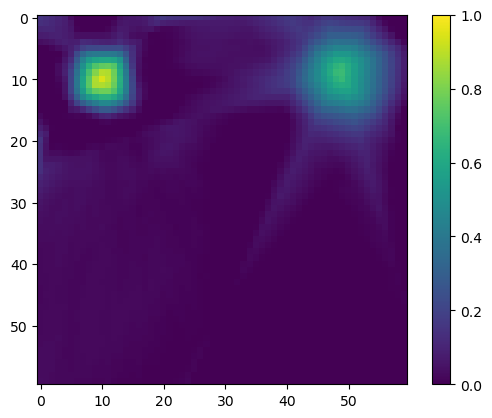

570
176/176 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0190
loss from regularizer: 0.00033728263224475086
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0128
loss from regularizer: 0.0003670952864922583
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0145 - val_loss: 0.0122
loss from regularizer: 0.0003663162642624229
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0133 - val_loss: 0.0122
loss from regularizer: 0.00034963132929988205
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

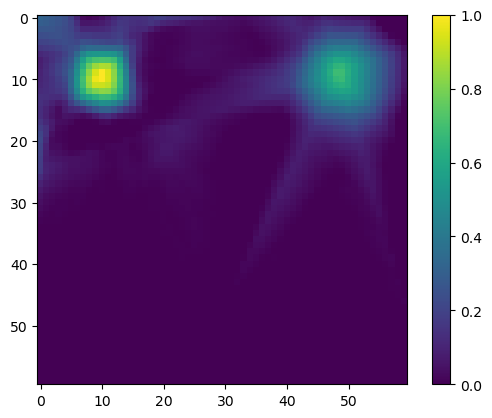

580
176/176 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0121
loss from regularizer: 0.0003458748396951705
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0135 - val_loss: 0.0144
loss from regularizer: 0.00035316238063387573
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0148 - val_loss: 0.0142
loss from regularizer: 0.0003635671455413103
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0127
loss from regularizer: 0.0003547589585650712
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

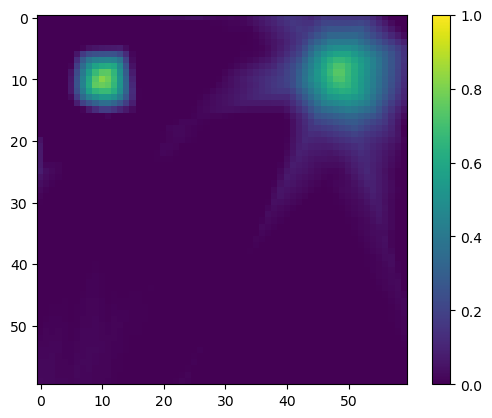

590
176/176 [==============================] - 1s 5ms/step - loss: 0.0133 - val_loss: 0.0125
loss from regularizer: 0.00035443020169623196
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0116
loss from regularizer: 0.00034939986653625965
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0133 - val_loss: 0.0132
loss from regularizer: 0.00035253813257440925
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0136 - val_loss: 0.0158
loss from regularizer: 0.00034798399428837
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

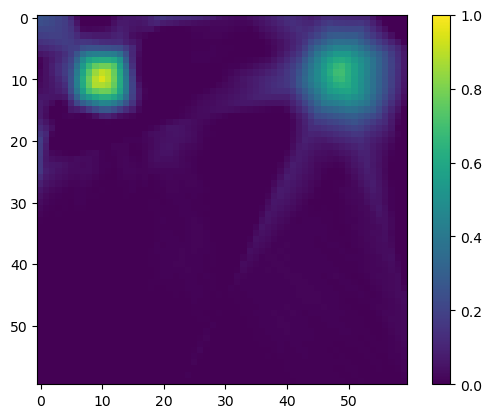

600
176/176 [==============================] - 1s 5ms/step - loss: 0.0134 - val_loss: 0.0120
loss from regularizer: 0.0003422533336561173
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0140 - val_loss: 0.0137
loss from regularizer: 0.0003408595221117139
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0135 - val_loss: 0.0125
loss from regularizer: 0.00033325949334539473
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0137 - val_loss: 0.0120
loss from regularizer: 0.00034665019484236836
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

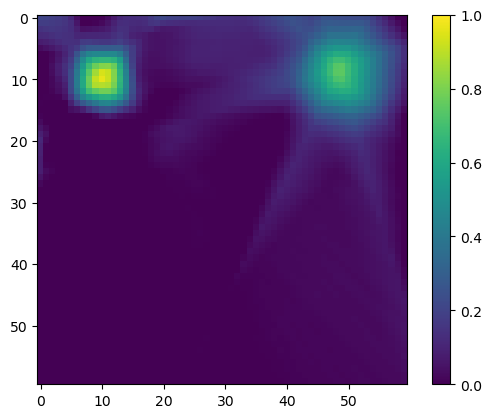

610
176/176 [==============================] - 1s 5ms/step - loss: 0.0138 - val_loss: 0.0128
loss from regularizer: 0.0003524811763782054
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0142 - val_loss: 0.0159
loss from regularizer: 0.00032703534816391766
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0136 - val_loss: 0.0146
loss from regularizer: 0.00033566055935807526
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0129 - val_loss: 0.0120
loss from regularizer: 0.0003477858263067901
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

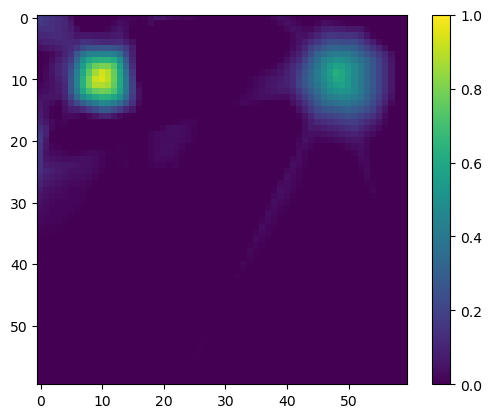

620
176/176 [==============================] - 1s 5ms/step - loss: 0.0141 - val_loss: 0.0122
loss from regularizer: 0.0003342837153468281
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0171
loss from regularizer: 0.000346933986293152
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0135 - val_loss: 0.0127
loss from regularizer: 0.000328903115587309
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0121 - val_loss: 0.0115
loss from regularizer: 0.0003423835150897503
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=====

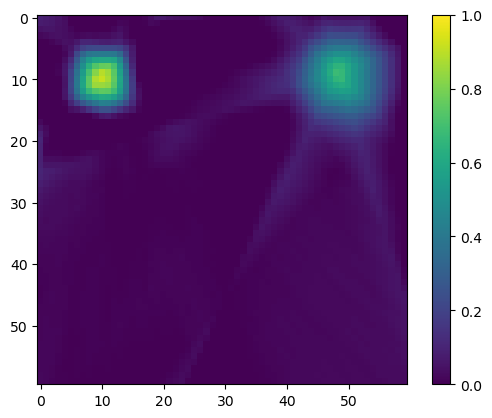

630
176/176 [==============================] - 1s 5ms/step - loss: 0.0129 - val_loss: 0.0159
loss from regularizer: 0.0003362818679306656
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0132 - val_loss: 0.0122
loss from regularizer: 0.0003507449000608176
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0131 - val_loss: 0.0120
loss from regularizer: 0.0003205754328519106
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0149
loss from regularizer: 0.0003291222674306482
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

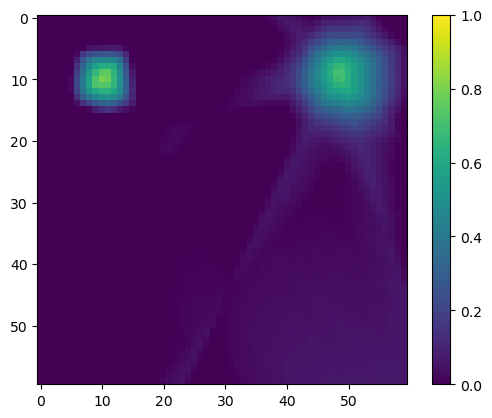

640
176/176 [==============================] - 1s 5ms/step - loss: 0.0137 - val_loss: 0.0135
loss from regularizer: 0.0003281153040006757
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0112
loss from regularizer: 0.00031747526372782886
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0136 - val_loss: 0.0139
loss from regularizer: 0.00033172121038660407
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0126
loss from regularizer: 0.0003208061389159411
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

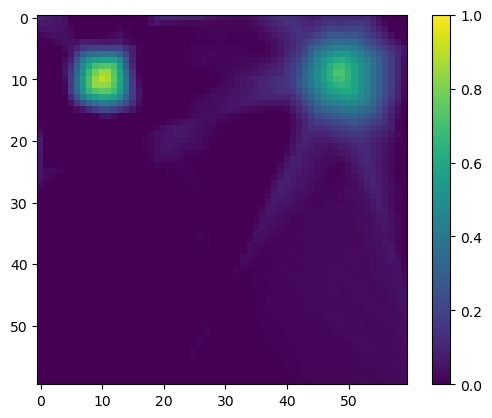

650
176/176 [==============================] - 1s 5ms/step - loss: 0.0127 - val_loss: 0.0125
loss from regularizer: 0.0003130137629341334
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0133 - val_loss: 0.0127
loss from regularizer: 0.00033552353852428496
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0118
loss from regularizer: 0.0003232603776268661
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0126 - val_loss: 0.0115
loss from regularizer: 0.0003276955976616591
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

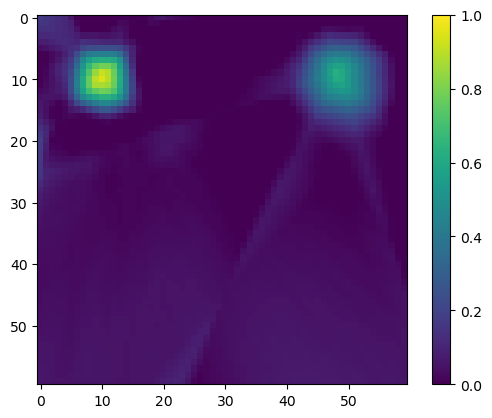

660
176/176 [==============================] - 1s 5ms/step - loss: 0.0138 - val_loss: 0.0137
loss from regularizer: 0.000309256836771965
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0132 - val_loss: 0.0121
loss from regularizer: 0.0003185870300512761
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0131 - val_loss: 0.0112
loss from regularizer: 0.0003170663840137422
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0129 - val_loss: 0.0109
loss from regularizer: 0.0003320887917652726
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [====

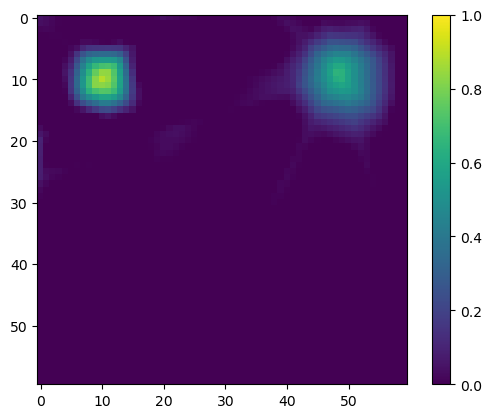

670
176/176 [==============================] - 1s 5ms/step - loss: 0.0124 - val_loss: 0.0142
loss from regularizer: 0.0003165730449836701
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0133 - val_loss: 0.0141
loss from regularizer: 0.0003255081828683615
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0126 - val_loss: 0.0115
loss from regularizer: 0.0003118929162155837
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0147
loss from regularizer: 0.00031848374055698514
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

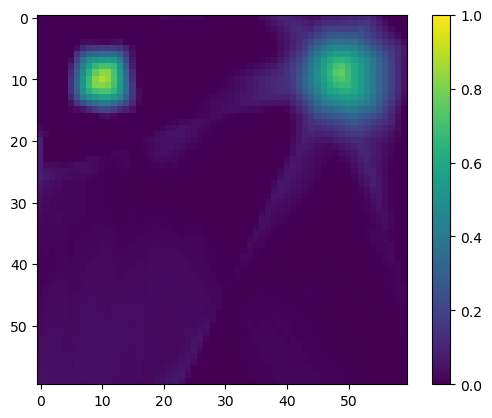

680
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0128
loss from regularizer: 0.00030533975223079324
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0121 - val_loss: 0.0131
loss from regularizer: 0.00032409437699243426
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0125 - val_loss: 0.0152
loss from regularizer: 0.00032746561919339
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0131 - val_loss: 0.0147
loss from regularizer: 0.0003091801190748811
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

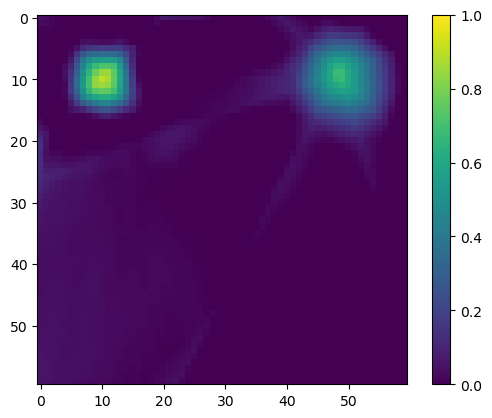

690
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0117
loss from regularizer: 0.0003190569987054914
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0123 - val_loss: 0.0119
loss from regularizer: 0.0002927168970927596
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0134 - val_loss: 0.0141
loss from regularizer: 0.0003087157674599439
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0125 - val_loss: 0.0121
loss from regularizer: 0.00031565071549266577
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

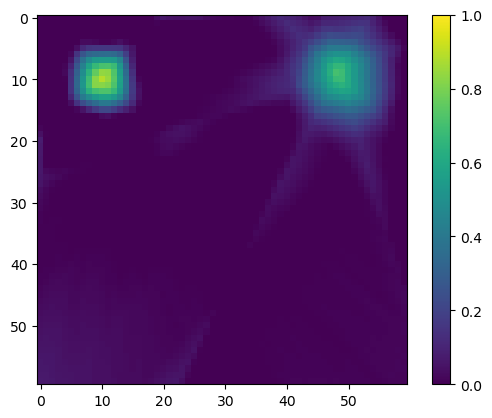

700
176/176 [==============================] - 1s 5ms/step - loss: 0.0140 - val_loss: 0.0212
loss from regularizer: 0.00030019585392437875
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0121 - val_loss: 0.0121
loss from regularizer: 0.0003041487361770123
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0111
loss from regularizer: 0.00031321754795499146
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0115
loss from regularizer: 0.00029817898757755756
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

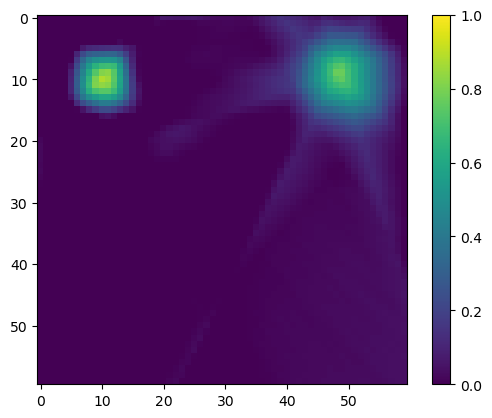

710
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0123
loss from regularizer: 0.0002975948737002909
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0111
loss from regularizer: 0.000306198577163741
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0123 - val_loss: 0.0109
loss from regularizer: 0.00030506818438880146
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0142
loss from regularizer: 0.0003040175070054829
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

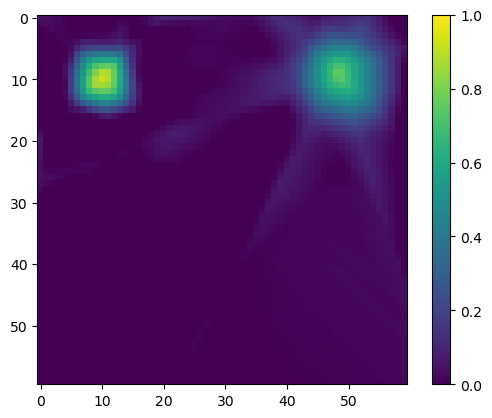

720
176/176 [==============================] - 1s 5ms/step - loss: 0.0121 - val_loss: 0.0139
loss from regularizer: 0.0002924850850831717
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0135
loss from regularizer: 0.0003050769155379385
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0106
loss from regularizer: 0.00030747795244678855
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0121 - val_loss: 0.0124
loss from regularizer: 0.000293418561341241
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

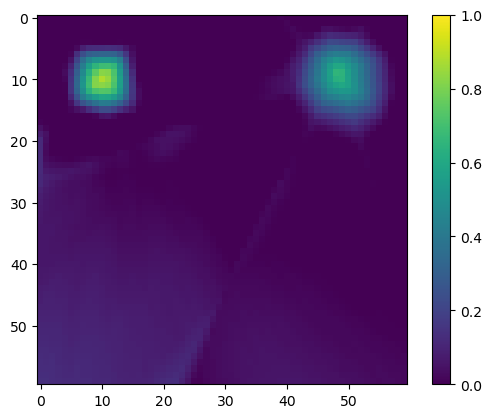

730
176/176 [==============================] - 1s 5ms/step - loss: 0.0124 - val_loss: 0.0115
loss from regularizer: 0.00029155894299037755
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0111
loss from regularizer: 0.0002900573017541319
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0107
loss from regularizer: 0.0003049024089705199
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0126
loss from regularizer: 0.00027937133563682437
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

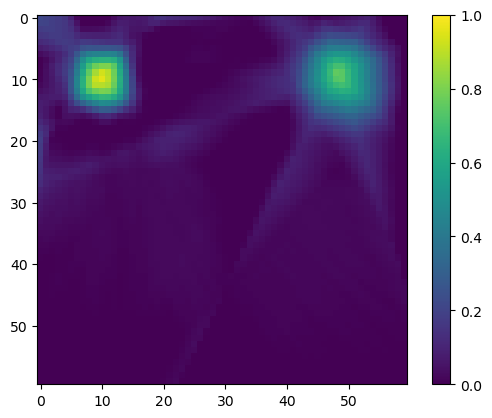

740
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0112
loss from regularizer: 0.0002912052150350064
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0135
loss from regularizer: 0.00028021776233799756
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0123 - val_loss: 0.0118
loss from regularizer: 0.0002949578338302672
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0125 - val_loss: 0.0104
loss from regularizer: 0.0002992115041706711
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

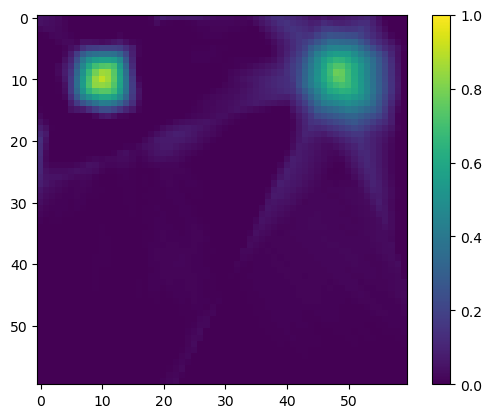

750
176/176 [==============================] - 1s 5ms/step - loss: 0.0124 - val_loss: 0.0136
loss from regularizer: 0.00031259888783097267
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0126 - val_loss: 0.0104
loss from regularizer: 0.0003078563022427261
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0127 - val_loss: 0.0119
loss from regularizer: 0.00031159151694737375
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0108
loss from regularizer: 0.00029039589571766555
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

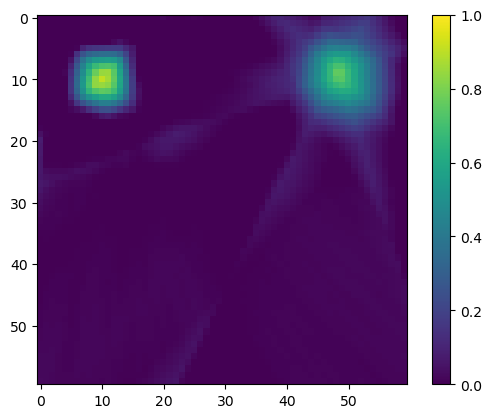

760
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0110
loss from regularizer: 0.0002974961535073817
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0111
loss from regularizer: 0.00030126210185699165
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0106
loss from regularizer: 0.00028891468537040055
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0132
loss from regularizer: 0.00028821913292631507
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

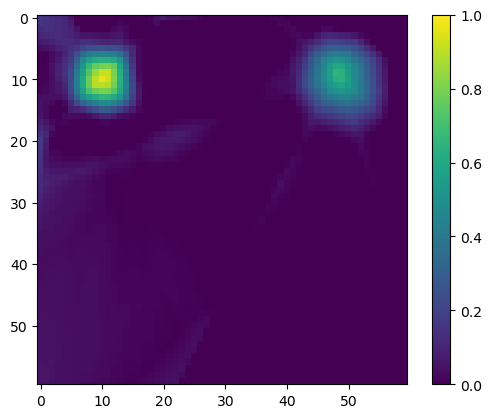

770
176/176 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0108
loss from regularizer: 0.0002747041580732912
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0125 - val_loss: 0.0102
loss from regularizer: 0.0002806191041599959
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0125 - val_loss: 0.0112
loss from regularizer: 0.0002812844468280673
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0119 - val_loss: 0.0104
loss from regularizer: 0.00029431821894831955
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

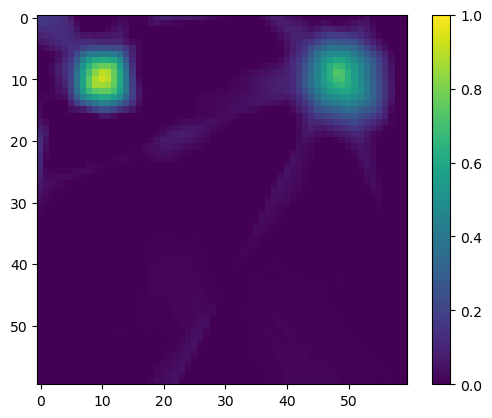

780
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0109
loss from regularizer: 0.0002869536983780563
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0121 - val_loss: 0.0104
loss from regularizer: 0.0002673738927114755
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0110
loss from regularizer: 0.0002890790347009897
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0119 - val_loss: 0.0210
loss from regularizer: 0.0003002022858709097
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

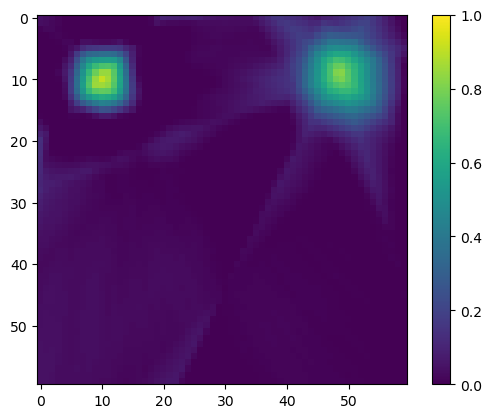

790
176/176 [==============================] - 1s 7ms/step - loss: 0.0130 - val_loss: 0.0122
loss from regularizer: 0.0002836837084032595
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0121 - val_loss: 0.0122
loss from regularizer: 0.0002784930693451315
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0106
loss from regularizer: 0.00029401012579910457
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0101
loss from regularizer: 0.0002942957216873765
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

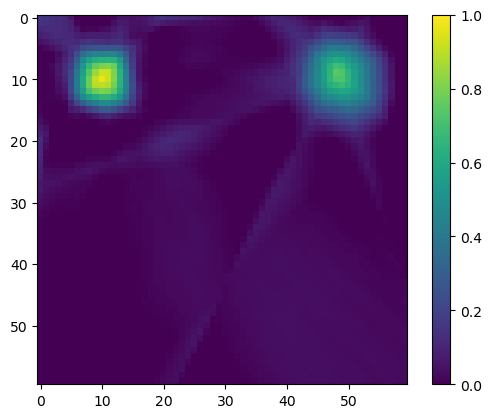

800
176/176 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0108
loss from regularizer: 0.000266556948190555
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0181
loss from regularizer: 0.0002865770657081157
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0126 - val_loss: 0.0115
loss from regularizer: 0.00025792853557504714
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0134
loss from regularizer: 0.0002738296170718968
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

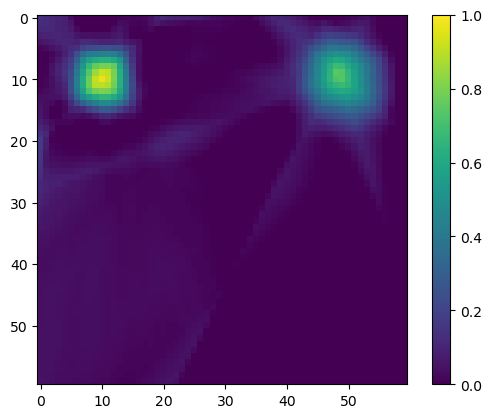

810
176/176 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0107
loss from regularizer: 0.0002845620037987828
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0106
loss from regularizer: 0.0002586072077974677
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0118
loss from regularizer: 0.00027104001492261887
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0103
loss from regularizer: 0.00024776317877694964
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

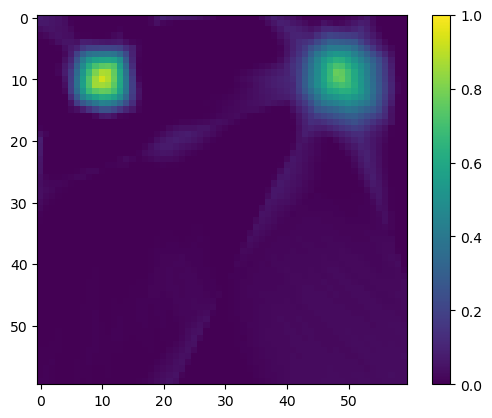

820
176/176 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0104
loss from regularizer: 0.0002527577744331211
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0124 - val_loss: 0.0116
loss from regularizer: 0.00026029697619378567
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0114 - val_loss: 0.0103
loss from regularizer: 0.00027123329346068203
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0114 - val_loss: 0.0109
loss from regularizer: 0.00027515244437381625
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

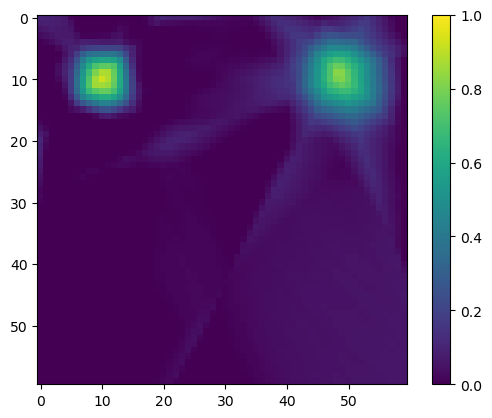

830
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0098
loss from regularizer: 0.000282645458355546
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0126 - val_loss: 0.0111
loss from regularizer: 0.00026738710585050285
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0130
loss from regularizer: 0.0002615680859889835
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0124 - val_loss: 0.0106
loss from regularizer: 0.0002638310252223164
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

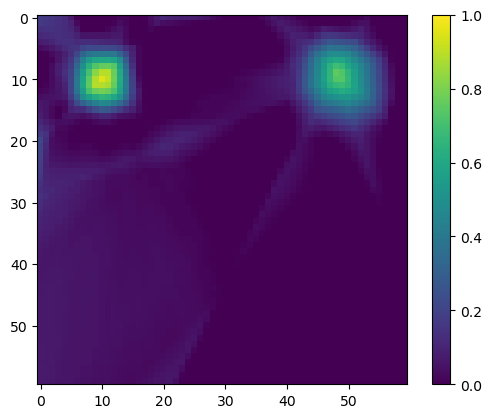

840
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0105
loss from regularizer: 0.0002540548157412559
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0137 - val_loss: 0.0113
loss from regularizer: 0.00026048580184578896
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0123
loss from regularizer: 0.0002587141061667353
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0103
loss from regularizer: 0.00025591248413547873
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

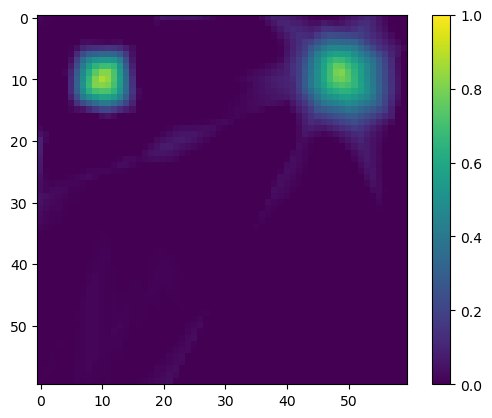

850
176/176 [==============================] - 1s 5ms/step - loss: 0.0126 - val_loss: 0.0101
loss from regularizer: 0.0002799983194563538
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0121
loss from regularizer: 0.0002596209815237671
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0098
loss from regularizer: 0.0002632066316436976
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0125
loss from regularizer: 0.00026449814322404563
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

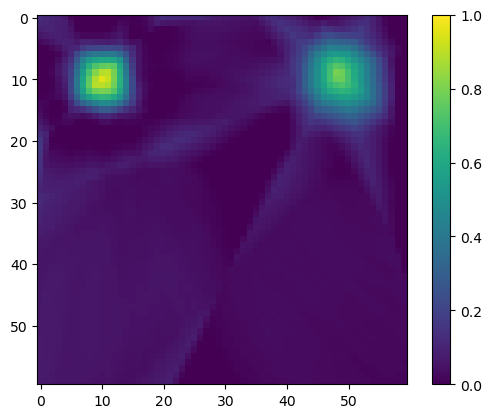

860
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0124
loss from regularizer: 0.00024899502750486135
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0098
loss from regularizer: 0.0002515717060305178
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0101
loss from regularizer: 0.00026607830659486353
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0102
loss from regularizer: 0.0002486670564394444
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

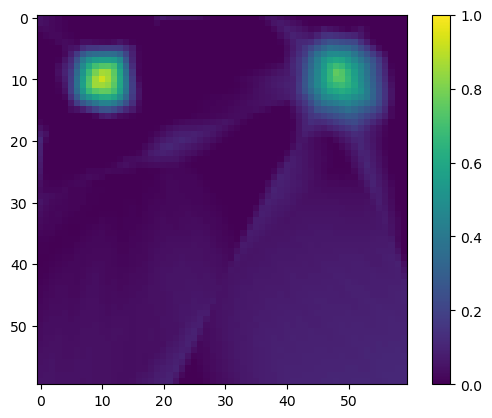

870
176/176 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0097
loss from regularizer: 0.0002771352883428335
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0105
loss from regularizer: 0.0002633179537951946
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0138
loss from regularizer: 0.0002522330032661557
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0106
loss from regularizer: 0.0002572516677901149
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

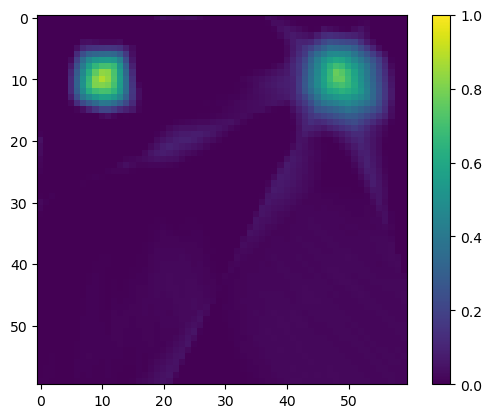

880
176/176 [==============================] - 1s 5ms/step - loss: 0.0114 - val_loss: 0.0102
loss from regularizer: 0.0002579987340141088
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0110
loss from regularizer: 0.0002538443950470537
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0114 - val_loss: 0.0114
loss from regularizer: 0.00025878488668240607
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0099
loss from regularizer: 0.00025869376258924603
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

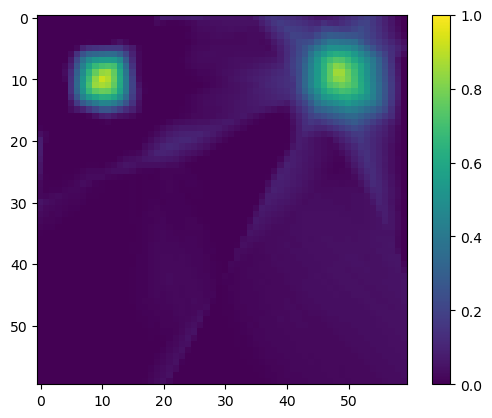

890
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0098
loss from regularizer: 0.00023702099861111492
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0119 - val_loss: 0.0106
loss from regularizer: 0.00024089188082143664
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0095
loss from regularizer: 0.0002455265785101801
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0106
loss from regularizer: 0.00025131323491223156
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

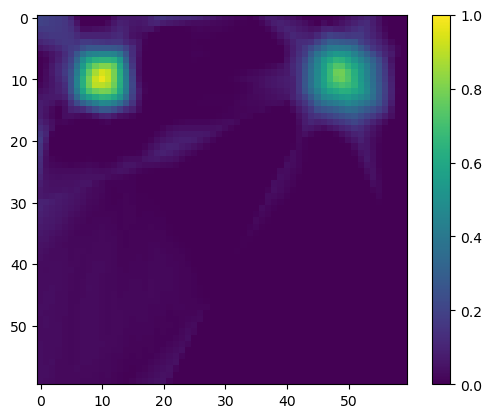

900
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0102
loss from regularizer: 0.00025984790408983827
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0144
loss from regularizer: 0.00024663854856044054
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0094
loss from regularizer: 0.0002622329629957676
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0108
loss from regularizer: 0.00025607069255784154
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

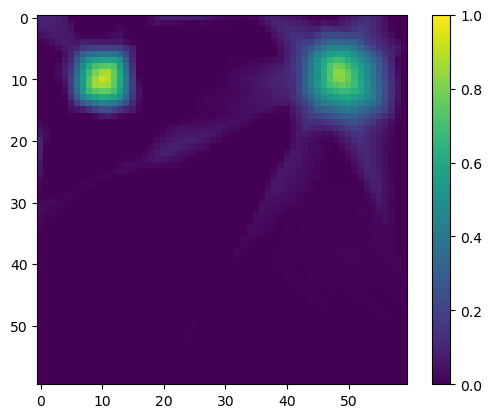

910
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0099
loss from regularizer: 0.0002656788274180144
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0108 - val_loss: 0.0106
loss from regularizer: 0.00024760354426689446
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0097
loss from regularizer: 0.000255977880442515
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0143
loss from regularizer: 0.0002459348470438272
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [===

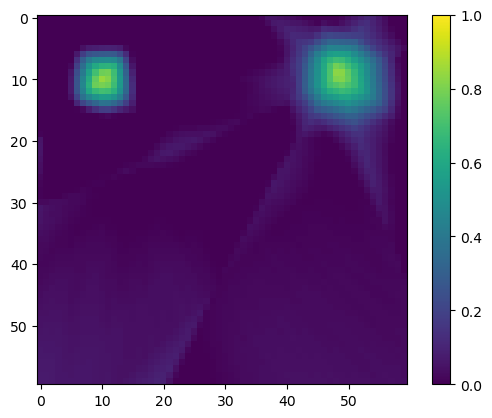

920
176/176 [==============================] - 1s 5ms/step - loss: 0.0123 - val_loss: 0.0117
loss from regularizer: 0.0002393182076048106
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0106
loss from regularizer: 0.00025106355315074325
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0101
loss from regularizer: 0.00026273788535036147
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0113 - val_loss: 0.0112
loss from regularizer: 0.00024205833324231207
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

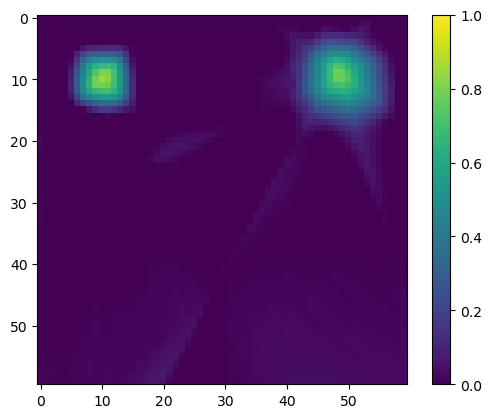

930
176/176 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0130
loss from regularizer: 0.0002432632609270513
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0102
loss from regularizer: 0.0002450867323204875
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0124
loss from regularizer: 0.00024313437461387366
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0107
loss from regularizer: 0.00025963198277167976
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

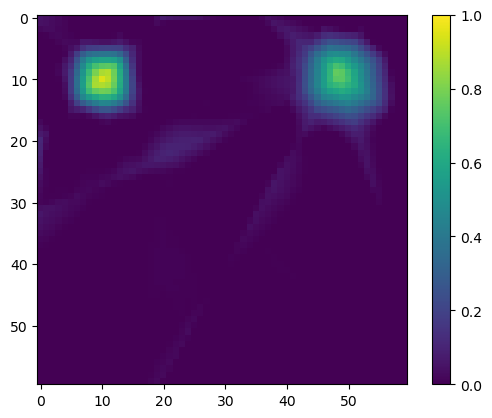

940
176/176 [==============================] - 1s 5ms/step - loss: 0.0119 - val_loss: 0.0093
loss from regularizer: 0.0002454927598591894
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0123 - val_loss: 0.0097
loss from regularizer: 0.00023934476485010237
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0115
loss from regularizer: 0.00025067850947380066
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0099
loss from regularizer: 0.0002488226746208966
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

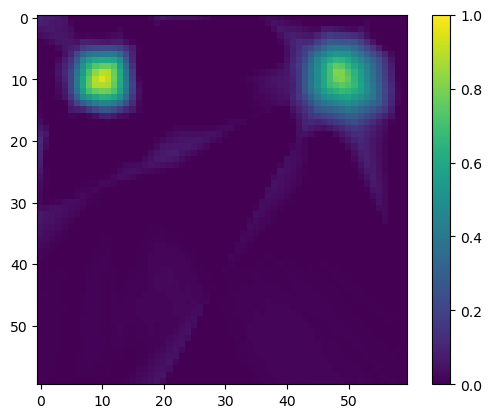

950
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0121
loss from regularizer: 0.0002309810370206833
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0109
loss from regularizer: 0.000256468920269981
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0107 - val_loss: 0.0095
loss from regularizer: 0.0002488631580490619
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0111
loss from regularizer: 0.000256153114605695
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=====

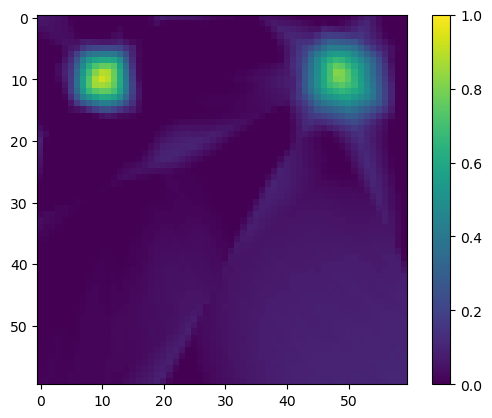

960
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0096
loss from regularizer: 0.00022861095203552395
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0115
loss from regularizer: 0.00022074331354815513
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0095
loss from regularizer: 0.000244786380790174
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0120 - val_loss: 0.0097
loss from regularizer: 0.00022001753677614033
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

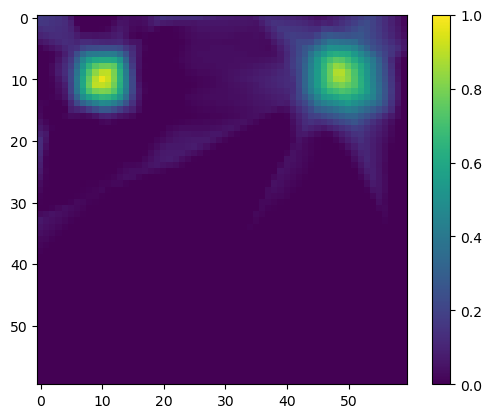

970
176/176 [==============================] - 1s 5ms/step - loss: 0.0108 - val_loss: 0.0109
loss from regularizer: 0.00023304831120185554
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0108 - val_loss: 0.0089
loss from regularizer: 0.00023668925859965384
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0098
loss from regularizer: 0.0002462897391524166
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0111
loss from regularizer: 0.00023875209444668144
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

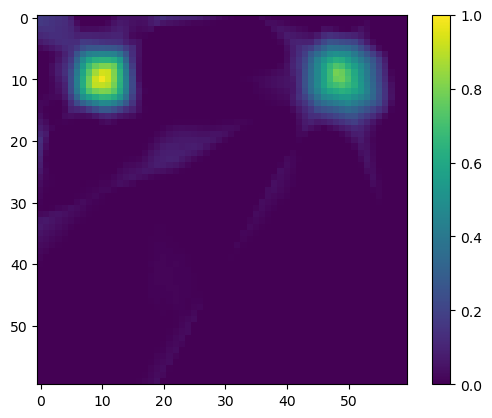

980
176/176 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0096
loss from regularizer: 0.00024221502826549113
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0111
loss from regularizer: 0.00023699432495050132
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0106 - val_loss: 0.0097
loss from regularizer: 0.00021681598445866257
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0108
loss from regularizer: 0.00024661116185598075
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

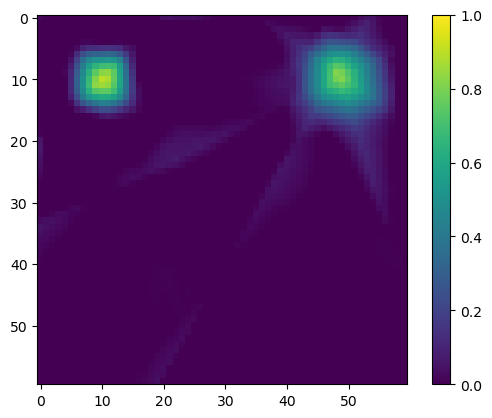

990
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0095
loss from regularizer: 0.00023150064225774258
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0105
loss from regularizer: 0.00023314951977226883
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0107 - val_loss: 0.0099
loss from regularizer: 0.00023359278566204011
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0103
loss from regularizer: 0.0002389929722994566
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

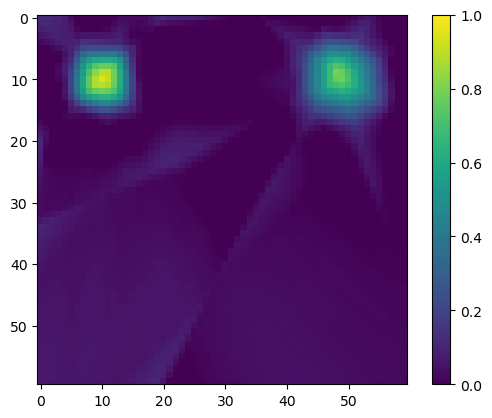

1000
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0128
loss from regularizer: 0.00023124214203562587
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0128
loss from regularizer: 0.00023715609859209508
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0093
loss from regularizer: 0.0002502099669072777
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0107 - val_loss: 0.0096
loss from regularizer: 0.0002389679866610095
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

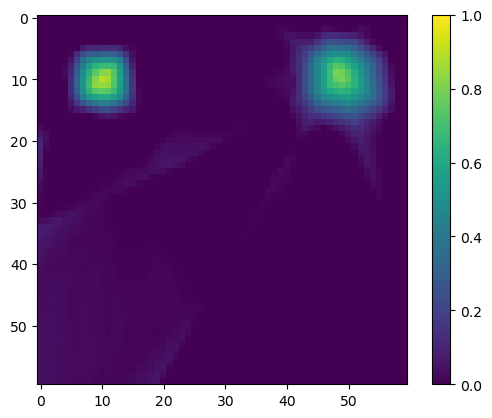

1010
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0095
loss from regularizer: 0.00023748366220388561
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0113
loss from regularizer: 0.00023975936346687376
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0109
loss from regularizer: 0.00022349198115989566
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0095
loss from regularizer: 0.00023046956630423665
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

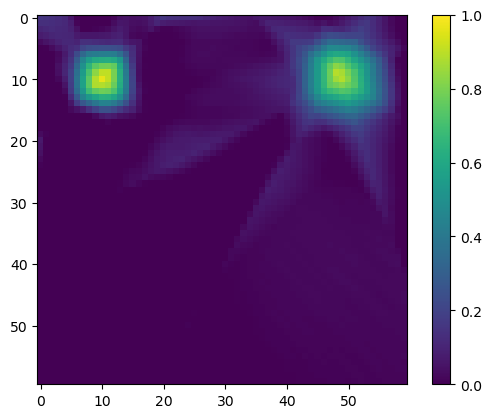

1020
176/176 [==============================] - 1s 6ms/step - loss: 0.0106 - val_loss: 0.0114
loss from regularizer: 0.0002391023881500587
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0110 - val_loss: 0.0095
loss from regularizer: 0.0002147394116036594
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0106
loss from regularizer: 0.00023807917023077607
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0103
loss from regularizer: 0.00023099043755792081
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

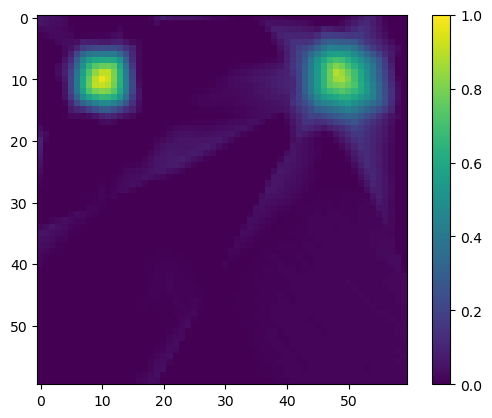

1030
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0088
loss from regularizer: 0.00023939624952618033
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0100
loss from regularizer: 0.00022727552277501673
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0115 - val_loss: 0.0096
loss from regularizer: 0.0002282760397065431
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0105
loss from regularizer: 0.00023202320153359324
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

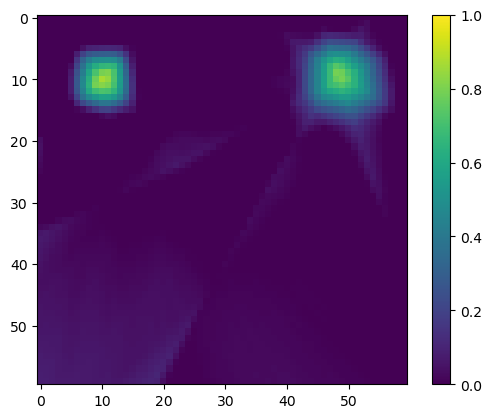

1040
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0095
loss from regularizer: 0.0002414179762126878
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0093
loss from regularizer: 0.00023573878570459783
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0097
loss from regularizer: 0.00023515136854257435
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0098
loss from regularizer: 0.0002450200845487416
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

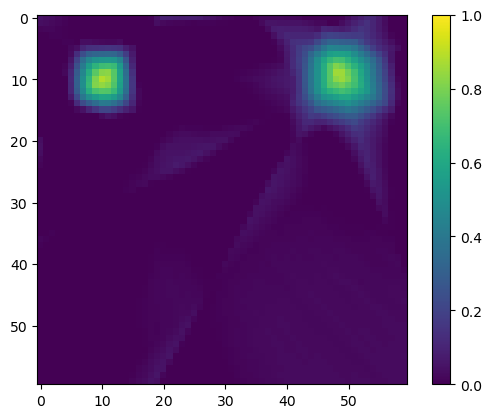

1050
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0094
loss from regularizer: 0.00023730839893687516
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0107 - val_loss: 0.0107
loss from regularizer: 0.00022396515123546124
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0097
loss from regularizer: 0.00023027346469461918
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0089
loss from regularizer: 0.00022455077851191163
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

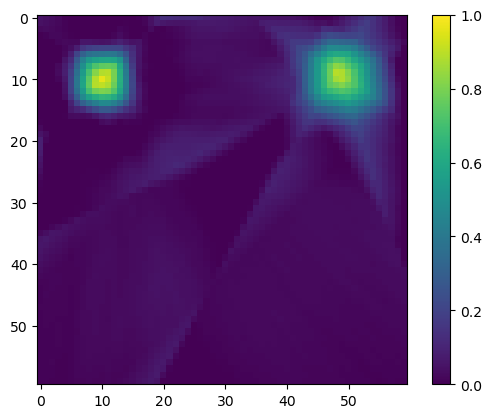

1060
176/176 [==============================] - 1s 6ms/step - loss: 0.0108 - val_loss: 0.0092
loss from regularizer: 0.00022100501519162208
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0108 - val_loss: 0.0096
loss from regularizer: 0.00022627915313933045
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0100
loss from regularizer: 0.00023252486425917596
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0093
loss from regularizer: 0.00022086406534072012
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

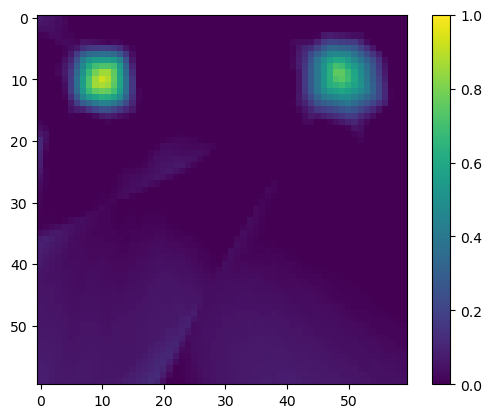

1070
176/176 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0090
loss from regularizer: 0.00023422090453095734
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0090
loss from regularizer: 0.00023201164731290191
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0091
loss from regularizer: 0.00022812720271758735
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0109 - val_loss: 0.0127
loss from regularizer: 0.00022113764134701341
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

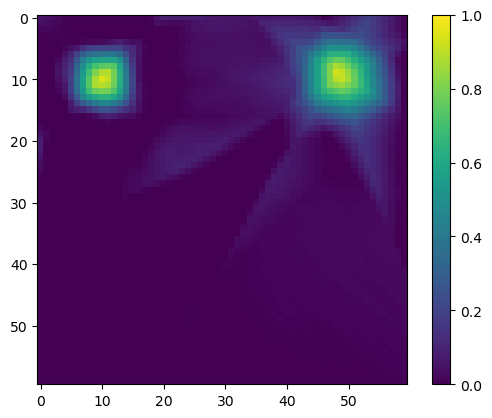

1080
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0087
loss from regularizer: 0.00022297160467132926
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0100
loss from regularizer: 0.00022686421289108694
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0109
loss from regularizer: 0.00022873077250551432
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0110
loss from regularizer: 0.00022866584185976535
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

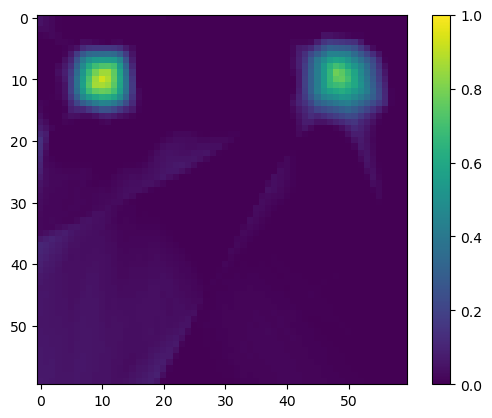

1090
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0100
loss from regularizer: 0.00021261372603476048
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0084
loss from regularizer: 0.00022687166347168386
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0090
loss from regularizer: 0.00022845098283141851
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0094
loss from regularizer: 0.00021666983957402408
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

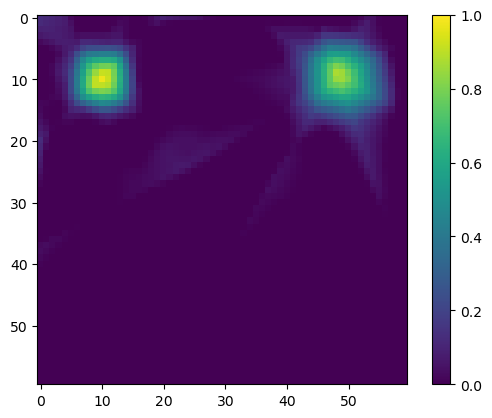

1100
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0112
loss from regularizer: 0.00022991887817624956
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0090
loss from regularizer: 0.0002370041620451957
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0090
loss from regularizer: 0.00022504724620375782
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0088
loss from regularizer: 0.00023515979410149157
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

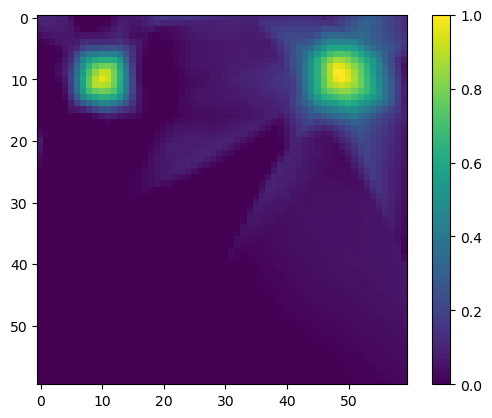

1110
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0115
loss from regularizer: 0.00022759726562071592
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0111
loss from regularizer: 0.00022814144904259592
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0096
loss from regularizer: 0.00022312435612548143
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0138
loss from regularizer: 0.00024159940949175507
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

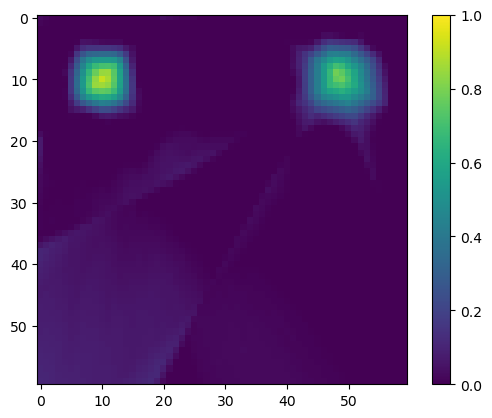

1120
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0085
loss from regularizer: 0.00021532645041588694
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0102 - val_loss: 0.0093
loss from regularizer: 0.0002178556751459837
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0104 - val_loss: 0.0110
loss from regularizer: 0.00022970905411057174
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0102 - val_loss: 0.0100
loss from regularizer: 0.00022864376660436392
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

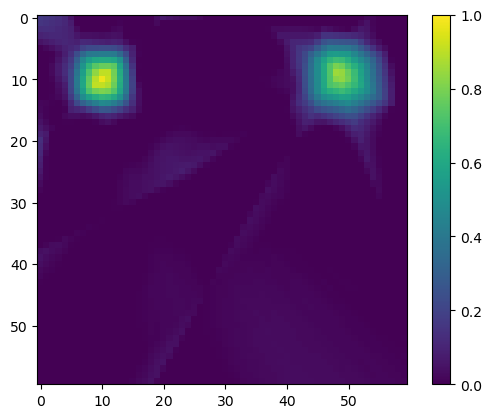

1130
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0093
loss from regularizer: 0.00022908202663529664
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0098
loss from regularizer: 0.00021395058138296008
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0087
loss from regularizer: 0.0002218802837887779
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0105
loss from regularizer: 0.00022194827033672482
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

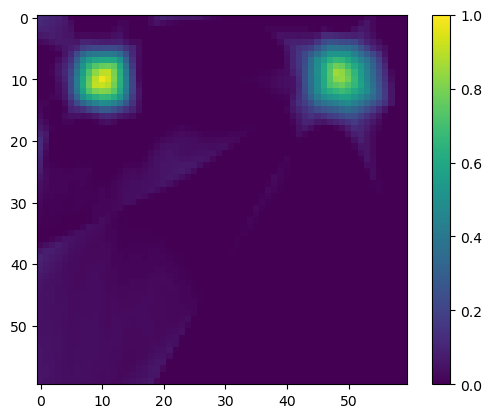

1140
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0204
loss from regularizer: 0.00023895960475783795
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0108 - val_loss: 0.0098
loss from regularizer: 0.00022559560602530837
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0112 - val_loss: 0.0125
loss from regularizer: 0.0002378857898293063
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0091
loss from regularizer: 0.0002196649875259027
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

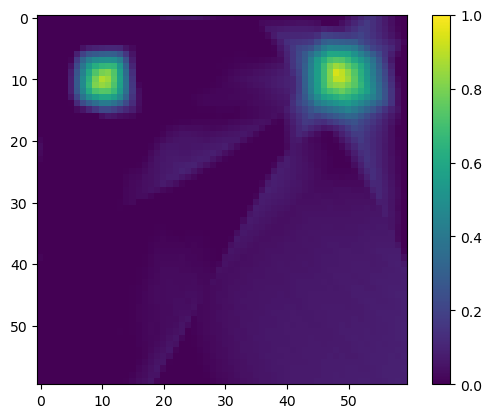

1150
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0110
loss from regularizer: 0.00022901104239281267
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0105
loss from regularizer: 0.00022773821547161788
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0087
loss from regularizer: 0.00021381604892667383
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0094
loss from regularizer: 0.0002275374426972121
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

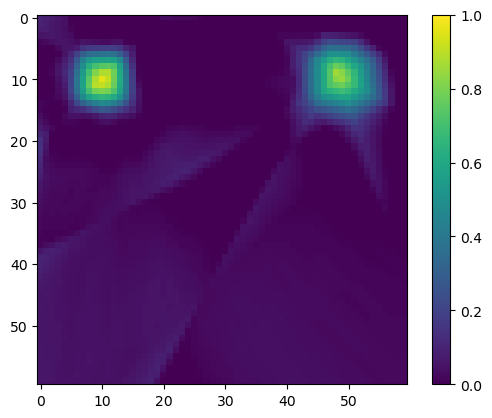

1160
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0086
loss from regularizer: 0.0002340934588573873
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0096
loss from regularizer: 0.0002240505418740213
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0095
loss from regularizer: 0.0002187893260270357
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0093
loss from regularizer: 0.00022187492868397385
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

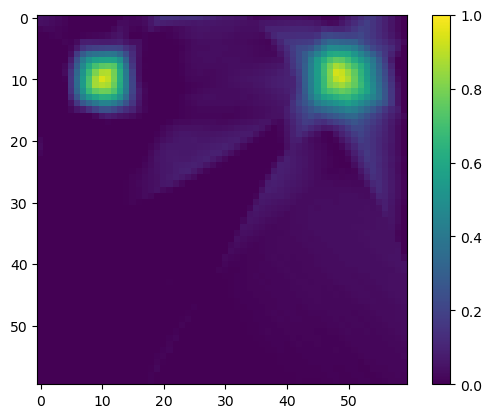

1170
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0086
loss from regularizer: 0.00020917454094160348
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0086
loss from regularizer: 0.00021617725724354386
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0107
loss from regularizer: 0.00020906231657136232
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0089
loss from regularizer: 0.00023626763140782714
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

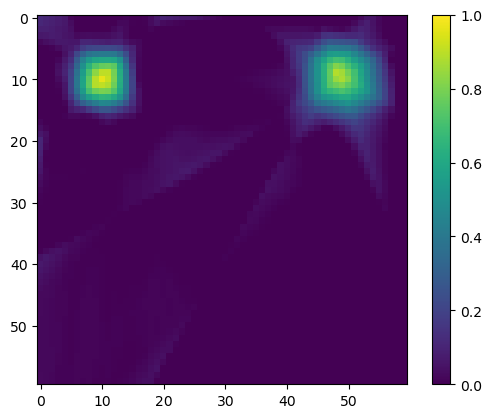

1180
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0116
loss from regularizer: 0.0002293221332365647
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0107
loss from regularizer: 0.00022693387290928513
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0086
loss from regularizer: 0.00022729749616701156
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0103
loss from regularizer: 0.00021841810666956007
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

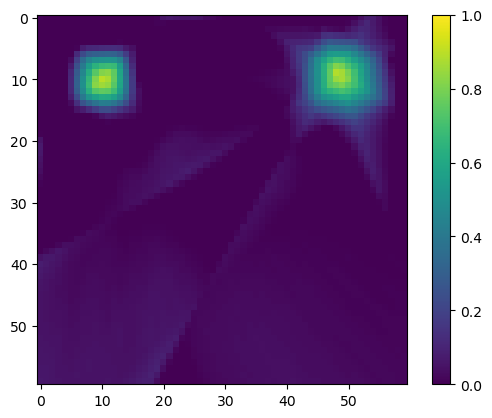

1190
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0090
loss from regularizer: 0.00023389818670693785
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0090
loss from regularizer: 0.00021699507487937808
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0101
loss from regularizer: 0.00022998100030235946
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0096
loss from regularizer: 0.00022563521633855999
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

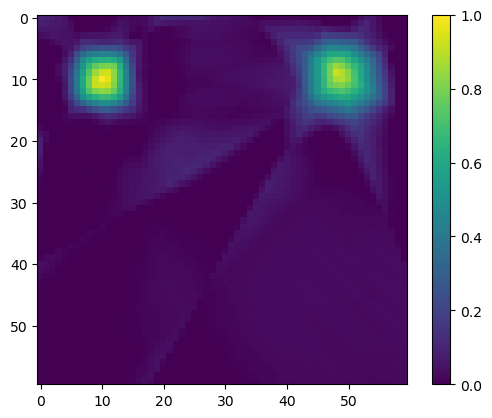

1200
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0089
loss from regularizer: 0.0002151179505744949
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0101
loss from regularizer: 0.0002202295872848481
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0089
loss from regularizer: 0.00022330730280373245
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0101 - val_loss: 0.0095
loss from regularizer: 0.0002162731543648988
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

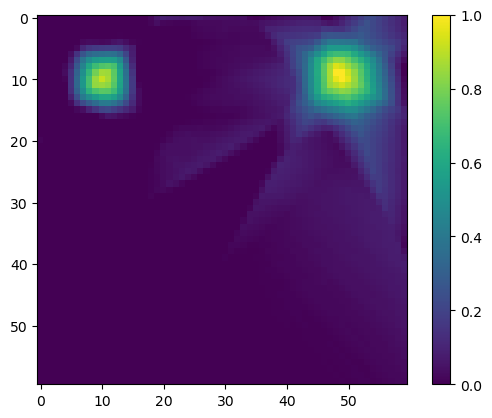

1210
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0089
loss from regularizer: 0.00022916636953596026
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0091
loss from regularizer: 0.00022434191487263888
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0085
loss from regularizer: 0.00022031109256204218
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0089
loss from regularizer: 0.0002175605477532372
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

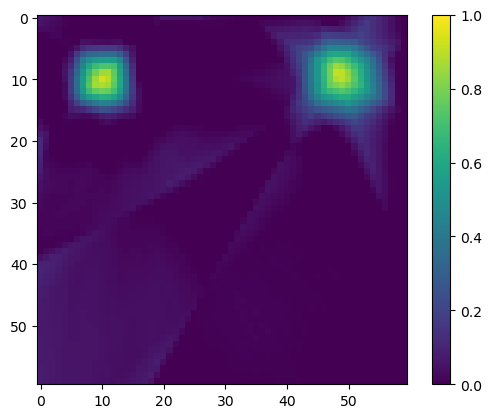

1220
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0096
loss from regularizer: 0.00020952909835614264
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0096
loss from regularizer: 0.00021709667635150254
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0087
loss from regularizer: 0.0002220985625172034
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0083
loss from regularizer: 0.00022772660304326564
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

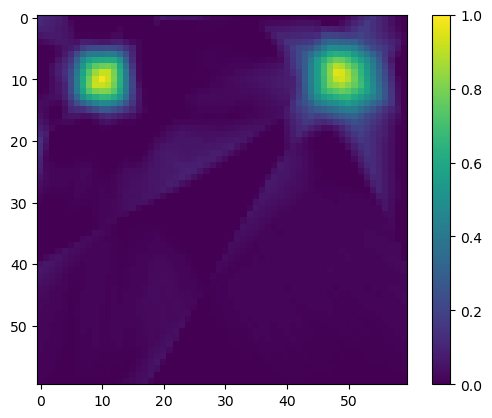

1230
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0090
loss from regularizer: 0.00022024834470357746
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0094
loss from regularizer: 0.00022421237372327596
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0084
loss from regularizer: 0.0002240498288301751
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0089
loss from regularizer: 0.00022358866408467293
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

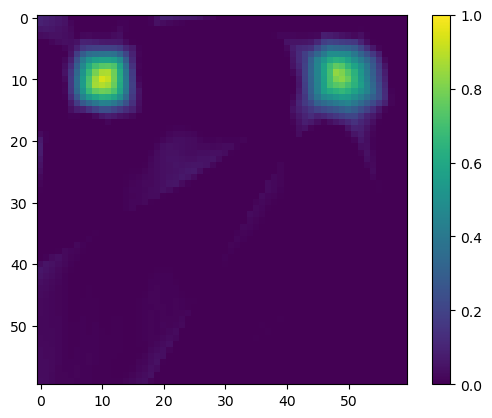

1240
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0082
loss from regularizer: 0.0002240999019704759
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0092
loss from regularizer: 0.00022292317589744925
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0095
loss from regularizer: 0.0002107371692545712
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0087
loss from regularizer: 0.0002226728538516909
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

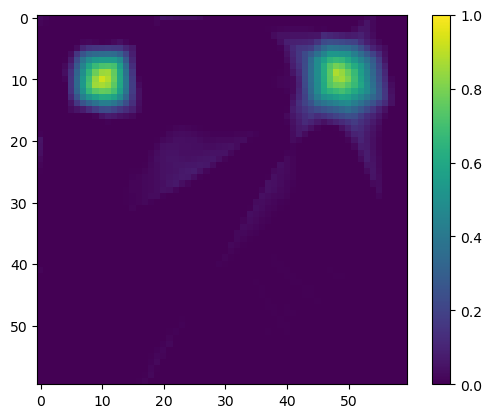

1250
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0084
loss from regularizer: 0.00022680302208755165
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0084
loss from regularizer: 0.00022152609017211944
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0089
loss from regularizer: 0.0002300658670719713
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0093
loss from regularizer: 0.00022133687161840498
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

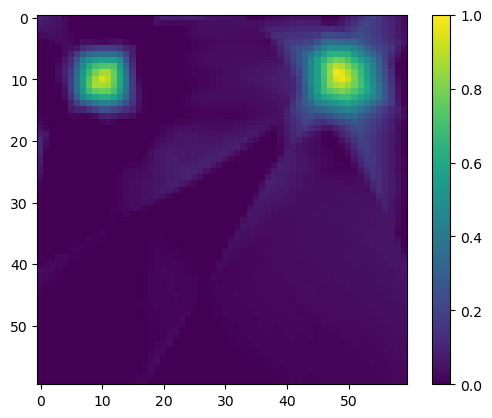

1260
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0084
loss from regularizer: 0.0002164022735087201
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0097
loss from regularizer: 0.0002212576218880713
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0087
loss from regularizer: 0.0002307662070961669
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0097
loss from regularizer: 0.00023044786939863116
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

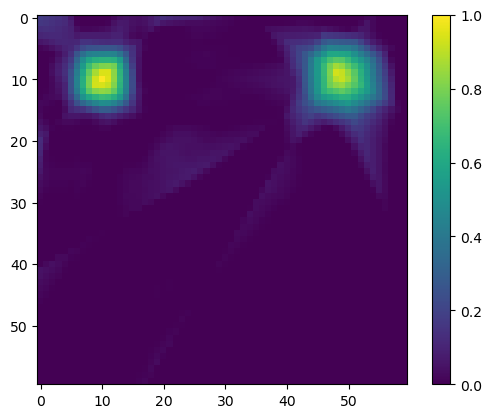

1270
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0104
loss from regularizer: 0.00020946183940395713
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0087
loss from regularizer: 0.00021725606347899884
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0107 - val_loss: 0.0085
loss from regularizer: 0.00020841602236032486
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0092
loss from regularizer: 0.0002225289645139128
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

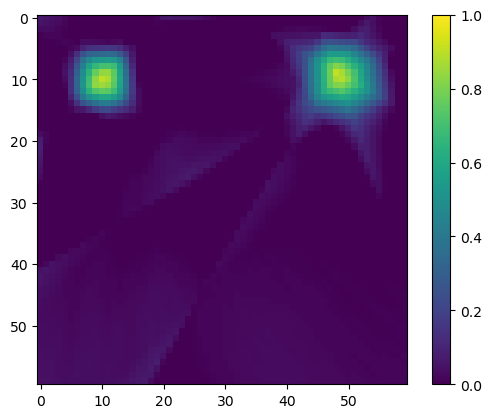

1280
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0085
loss from regularizer: 0.00023202756710816175
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0094
loss from regularizer: 0.00021025422029197216
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0087
loss from regularizer: 0.0002147216146113351
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0095
loss from regularizer: 0.00022076113964430988
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

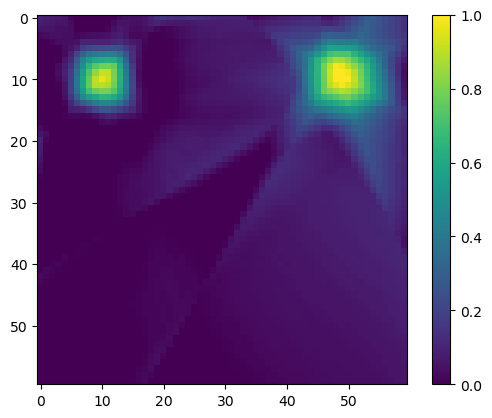

1290
176/176 [==============================] - 1s 6ms/step - loss: 0.0101 - val_loss: 0.0082
loss from regularizer: 0.0002310388517798856
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0101
loss from regularizer: 0.0002205857017543167
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0108 - val_loss: 0.0104
loss from regularizer: 0.00024178998137358576
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0094
loss from regularizer: 0.00022840852034278214
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

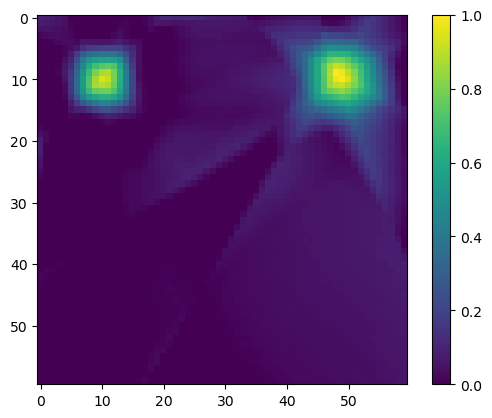

1300
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0088
loss from regularizer: 0.00023102581326384097
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0090
loss from regularizer: 0.00023386464454233646
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0091
loss from regularizer: 0.00021186366211622953
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0083
loss from regularizer: 0.00022255827207118273
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

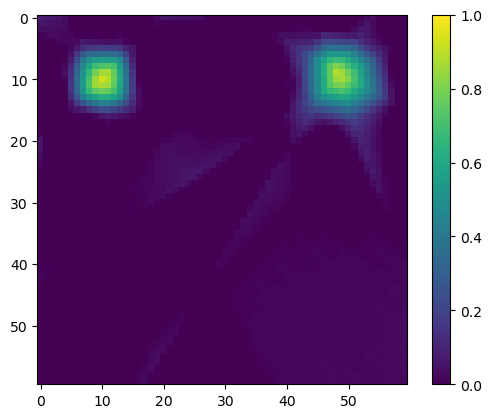

1310
176/176 [==============================] - 1s 5ms/step - loss: 0.0105 - val_loss: 0.0086
loss from regularizer: 0.000224620831431821
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0088
loss from regularizer: 0.00021384960564319044
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0087
loss from regularizer: 0.00021224364172667265
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0096
loss from regularizer: 0.00020279979798942804
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

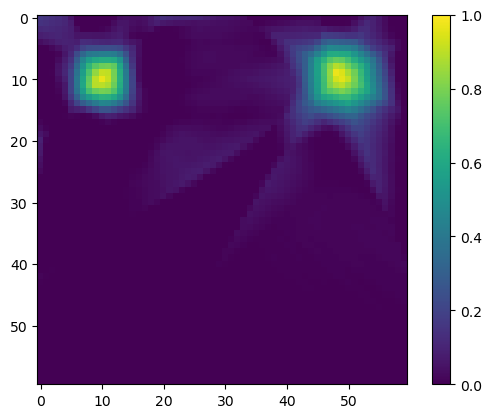

1320
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0095
loss from regularizer: 0.00020658598805312067
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0097
loss from regularizer: 0.00022198566875886172
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0087
loss from regularizer: 0.00021845052833668888
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0114 - val_loss: 0.0082
loss from regularizer: 0.00022792219533585012
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

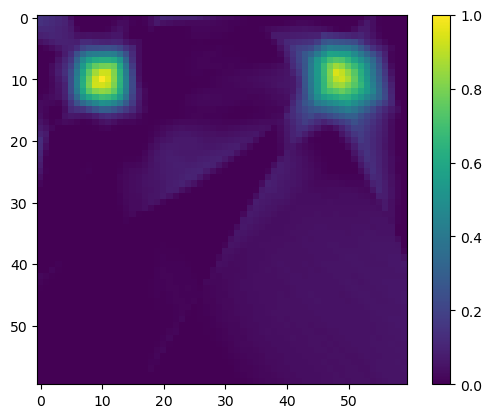

1330
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0117
loss from regularizer: 0.00021436014503706247
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0088
loss from regularizer: 0.00021286999981384724
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0089
loss from regularizer: 0.00020691526879090816
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0094
loss from regularizer: 0.0002303781802766025
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

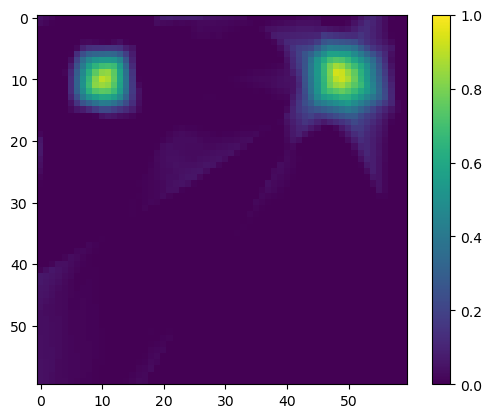

1340
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0089
loss from regularizer: 0.00021227610704954714
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0086
loss from regularizer: 0.00021563014888670295
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0092
loss from regularizer: 0.0002171914093196392
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0093
loss from regularizer: 0.00022239038662519306
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

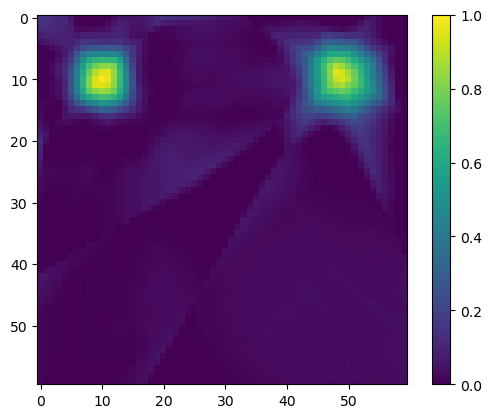

1350
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0082
loss from regularizer: 0.000202185517991893
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0095
loss from regularizer: 0.00020910653984174132
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0083
loss from regularizer: 0.0002122690057149157
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0107
loss from regularizer: 0.0002243871131213382
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

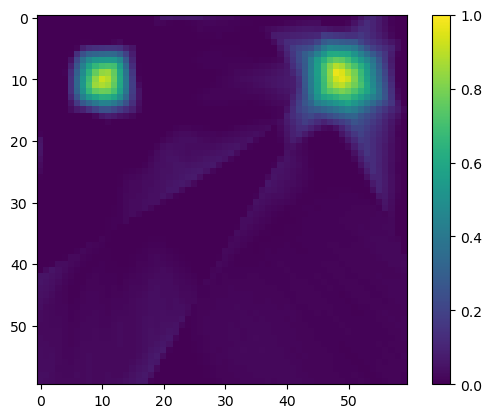

1360
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0091
loss from regularizer: 0.00022456537408288568
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0088
loss from regularizer: 0.00022094610903877765
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0102
loss from regularizer: 0.0002206937497248873
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0087
loss from regularizer: 0.0002122632577084005
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

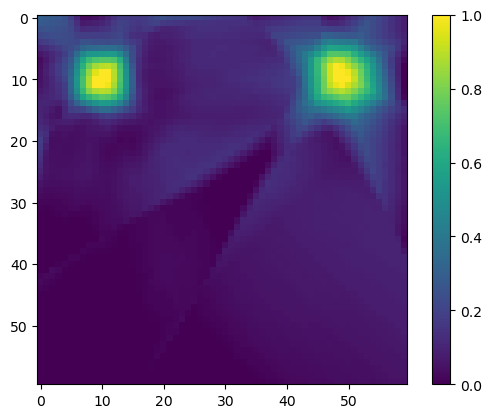

1370
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0086
loss from regularizer: 0.00023073023476172239
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0084
loss from regularizer: 0.00021300764637999237
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0086
loss from regularizer: 0.00021325756097212434
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0087
loss from regularizer: 0.0002137179544661194
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

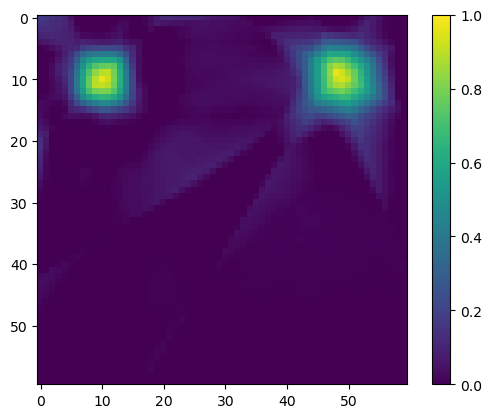

1380
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0103
loss from regularizer: 0.00019738472474273294
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0092
loss from regularizer: 0.00021311316231731325
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0087
loss from regularizer: 0.00020609390048775822
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0087
loss from regularizer: 0.00023177379625849426
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

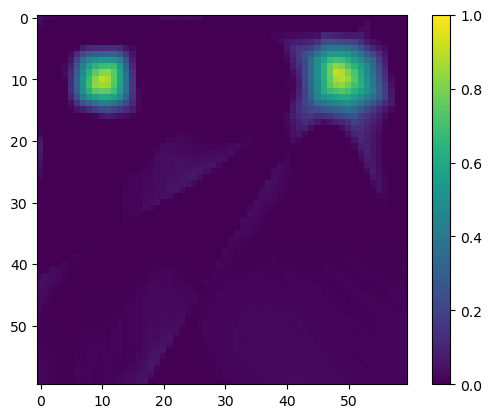

1390
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0083
loss from regularizer: 0.00021852688223589212
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0092
loss from regularizer: 0.0002116639370797202
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0088
loss from regularizer: 0.00021511396334972233
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0101 - val_loss: 0.0082
loss from regularizer: 0.00022592545428778976
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

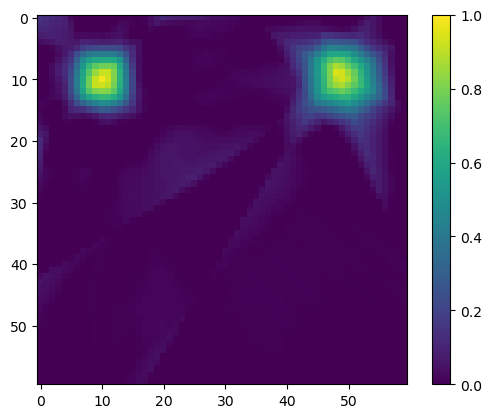

1400
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0096
loss from regularizer: 0.00021699120406992733
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0089
loss from regularizer: 0.00022108129633124918
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0085
loss from regularizer: 0.00021369339083321393
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0082
loss from regularizer: 0.00020469875016715378
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

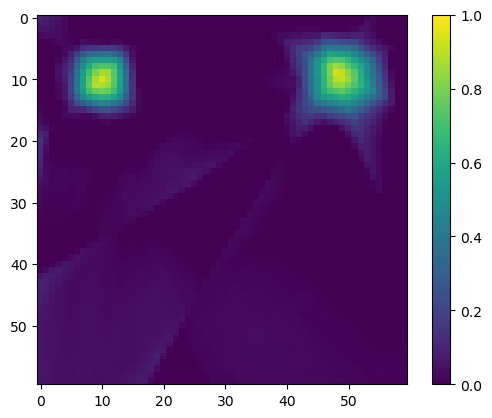

1410
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0085
loss from regularizer: 0.00022201381216291338
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0144
loss from regularizer: 0.00020067022705916315
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0090
loss from regularizer: 0.00020755235163960606
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0086
loss from regularizer: 0.00021198268223088235
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

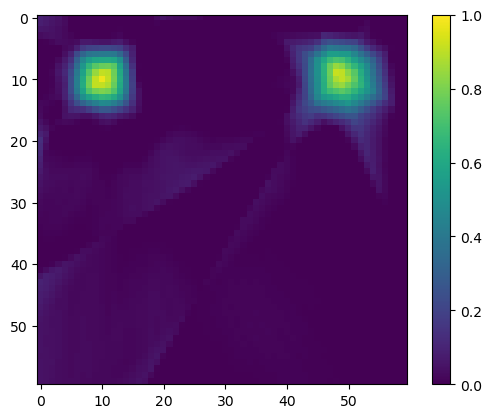

1420
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0115
loss from regularizer: 0.00020796601893380284
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0082
loss from regularizer: 0.00021879718406125903
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0089
loss from regularizer: 0.00021907570771872997
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0082
loss from regularizer: 0.00021225871751084924
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

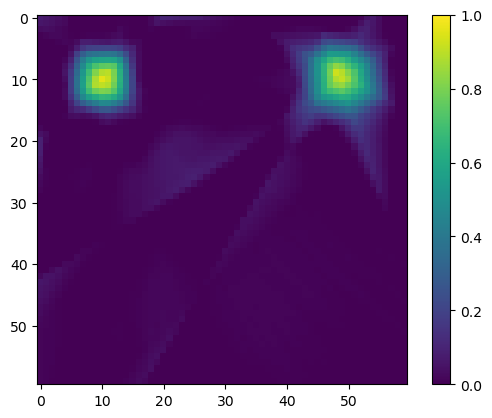

1430
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0093
loss from regularizer: 0.00021601536718662828
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0089
loss from regularizer: 0.00021325747366063297
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0120
loss from regularizer: 0.00022680578695144504
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0101 - val_loss: 0.0088
loss from regularizer: 0.0002178756258217618
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

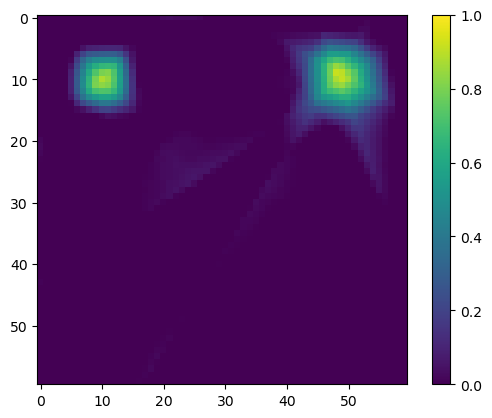

1440
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0087
loss from regularizer: 0.00020924325508531183
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0083
loss from regularizer: 0.0001932260929606855
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0107
loss from regularizer: 0.00020425862749107182
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0093
loss from regularizer: 0.00020461561507545412
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

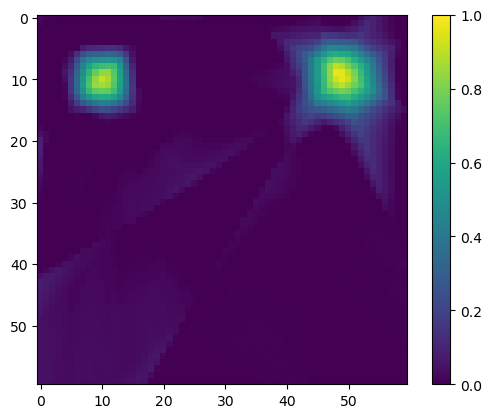

1450
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0088
loss from regularizer: 0.00020655003027059138
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0085
loss from regularizer: 0.000206304423045367
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0085
loss from regularizer: 0.0002032676711678505
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0102
loss from regularizer: 0.00019740914285648614
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

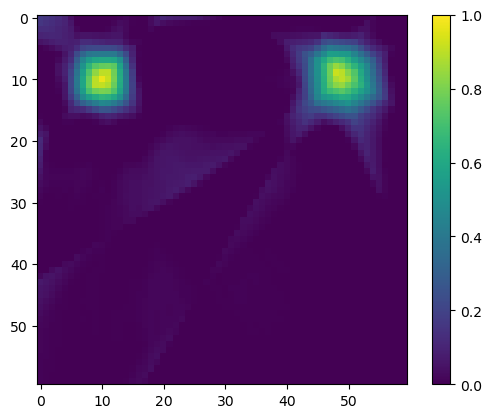

1460
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0113
loss from regularizer: 0.00019824055198114365
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0084
loss from regularizer: 0.00020175287500023842
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0100
loss from regularizer: 0.00020441303786356002
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0087
loss from regularizer: 0.00021726930572185665
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

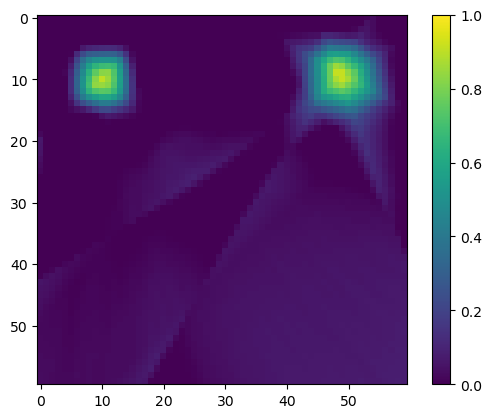

1470
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0092
loss from regularizer: 0.0002025574940489605
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0084
loss from regularizer: 0.00021042923617642373
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0090
loss from regularizer: 0.00021064584143459797
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0079
loss from regularizer: 0.00020104444411117584
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

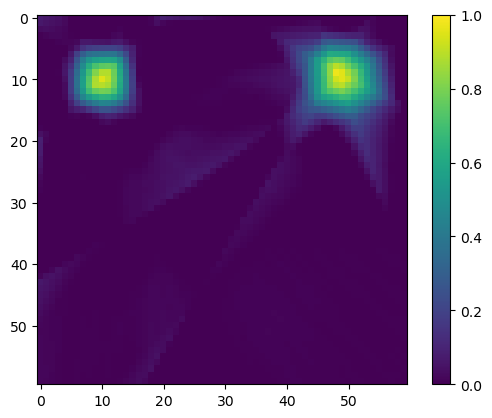

1480
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0089
loss from regularizer: 0.00020636231056414545
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0084
loss from regularizer: 0.000206781507586129
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0101 - val_loss: 0.0094
loss from regularizer: 0.00021338078659027815
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0096
loss from regularizer: 0.0002083583385683596
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

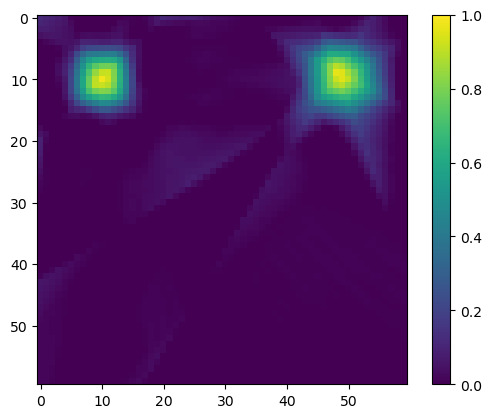

1490
176/176 [==============================] - 1s 5ms/step - loss: 0.0100 - val_loss: 0.0088
loss from regularizer: 0.000205203949008137
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0091
loss from regularizer: 0.00020254634728189558
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0086
loss from regularizer: 0.00020358189067337662
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0094
loss from regularizer: 0.00020121347915846854
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

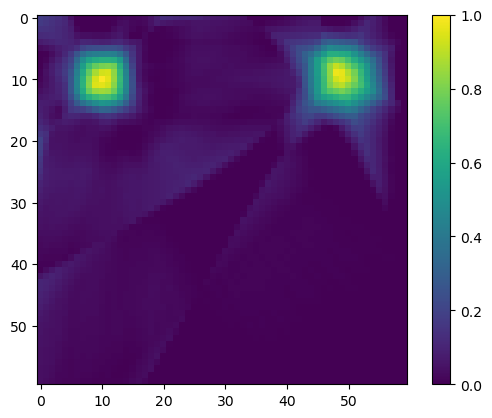

1500
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0099
loss from regularizer: 0.00020778497855644673
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0082
loss from regularizer: 0.00021518452558666468
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0094
loss from regularizer: 0.00020836657495237887
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0089
loss from regularizer: 0.00020398131164256483
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

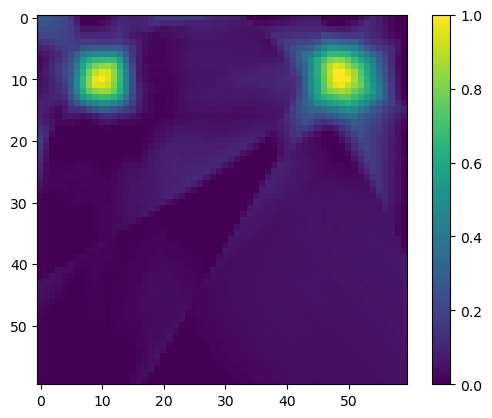

1510
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0091
loss from regularizer: 0.00021461636060848832
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0113
loss from regularizer: 0.0002110719942720607
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0087
loss from regularizer: 0.00020257342839613557
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0078
loss from regularizer: 0.00019735783280339092
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

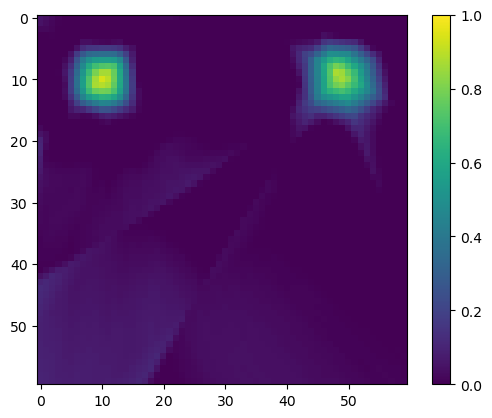

1520
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0097
loss from regularizer: 0.0001966754498425871
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0084
loss from regularizer: 0.00019897027232218534
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0102
loss from regularizer: 0.0002073272771667689
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0088
loss from regularizer: 0.00020308350212872028
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

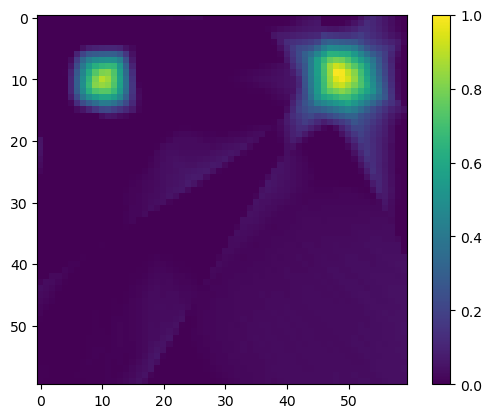

1530
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0083
loss from regularizer: 0.000201747432583943
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0084
loss from regularizer: 0.0002041078550973907
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0081
loss from regularizer: 0.00020408118143677711
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0085
loss from regularizer: 0.00021299759100656956
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

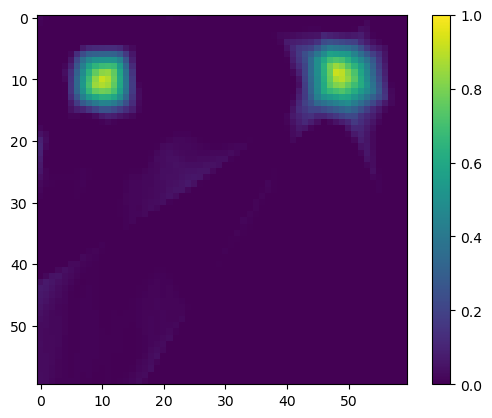

1540
176/176 [==============================] - 1s 5ms/step - loss: 0.0103 - val_loss: 0.0083
loss from regularizer: 0.0001958082284545526
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0102 - val_loss: 0.0094
loss from regularizer: 0.00019827474898193032
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0079
loss from regularizer: 0.00019449045066721737
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0085
loss from regularizer: 0.0002030410396400839
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

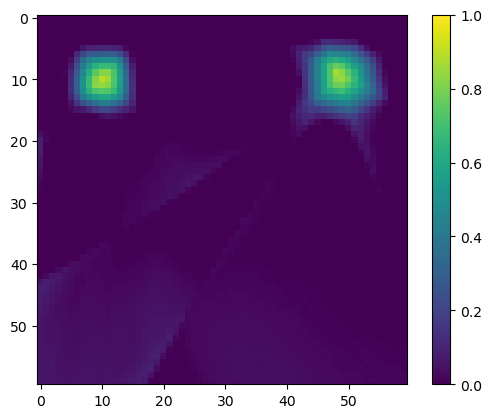

1550
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0081
loss from regularizer: 0.00020543287973850965
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0098
loss from regularizer: 0.0001979905500775203
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0078
loss from regularizer: 0.0002008771407417953
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0095
loss from regularizer: 0.00019726275058928877
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

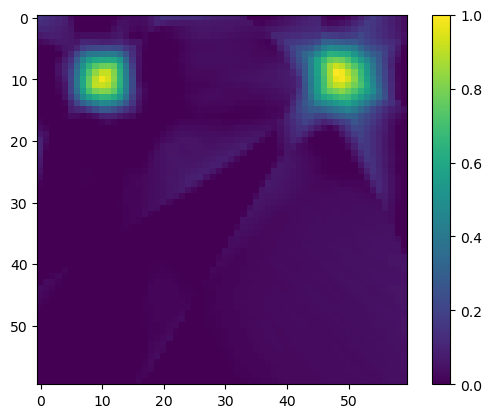

1560
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0082
loss from regularizer: 0.00019422537297941744
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0081
loss from regularizer: 0.0001916040782816708
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0085
loss from regularizer: 0.00019459471513982862
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0089
loss from regularizer: 0.00019719285774044693
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

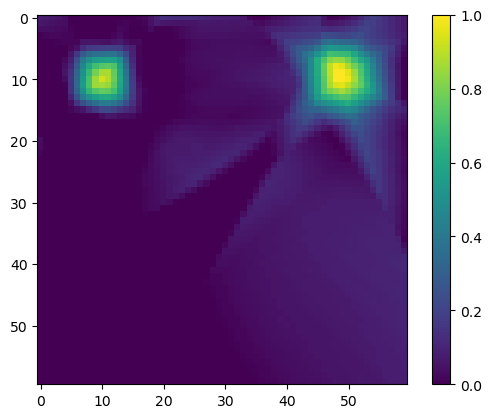

1570
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0109
loss from regularizer: 0.00020599925483111292
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0084
loss from regularizer: 0.00018536325660534203
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0079
loss from regularizer: 0.00019989098655059934
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0081
loss from regularizer: 0.00020049004524480551
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

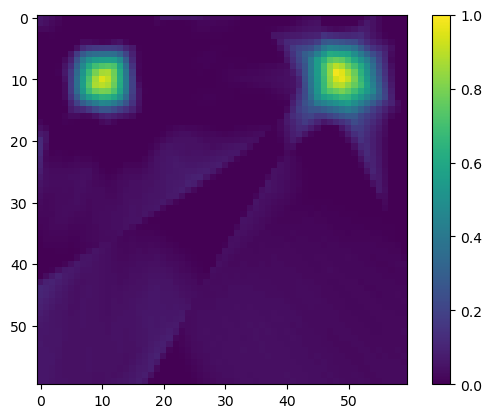

1580
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0091
loss from regularizer: 0.0001979227818083018
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0116
loss from regularizer: 0.0001942487433552742
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0086
loss from regularizer: 0.00019530561985448003
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0081
loss from regularizer: 0.00019722672004718333
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

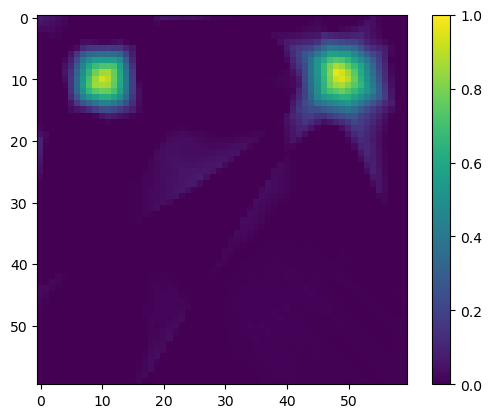

1590
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0080
loss from regularizer: 0.0001930398284457624
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0096
loss from regularizer: 0.00020038089132867754
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0088
loss from regularizer: 0.0001947193086380139
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0082
loss from regularizer: 0.00020316857262514532
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

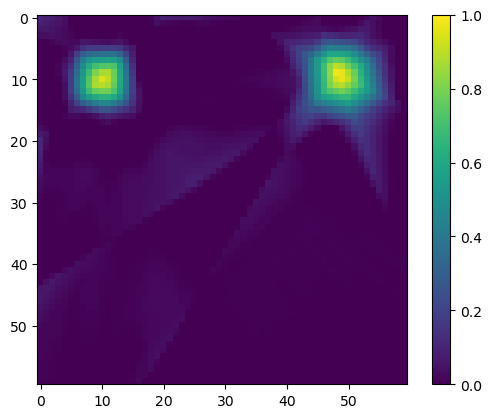

1600
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0098
loss from regularizer: 0.00018855328380595893
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0102
loss from regularizer: 0.00018981269386131316
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0090
loss from regularizer: 0.0001919336209539324
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0081
loss from regularizer: 0.00018830029875971377
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

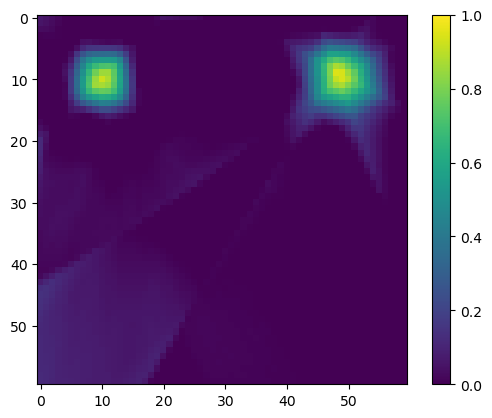

1610
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0081
loss from regularizer: 0.00019533350132405758
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0093
loss from regularizer: 0.0001911778817884624
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0139
loss from regularizer: 0.00018645926320459694
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0078
loss from regularizer: 0.00020243195467628539
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

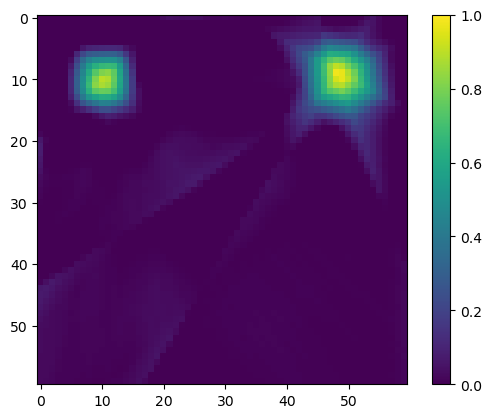

1620
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0089
loss from regularizer: 0.00019705681188497692
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0080
loss from regularizer: 0.0001994801132241264
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0083
loss from regularizer: 0.00019385966879781336
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0097
loss from regularizer: 0.00018967900541611016
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

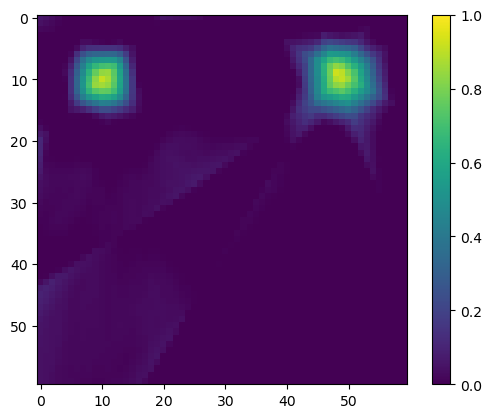

1630
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0100
loss from regularizer: 0.0001877368922578171
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0079
loss from regularizer: 0.00019141782831866294
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0080
loss from regularizer: 0.00019084314408246428
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0081
loss from regularizer: 0.0001982215908356011
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

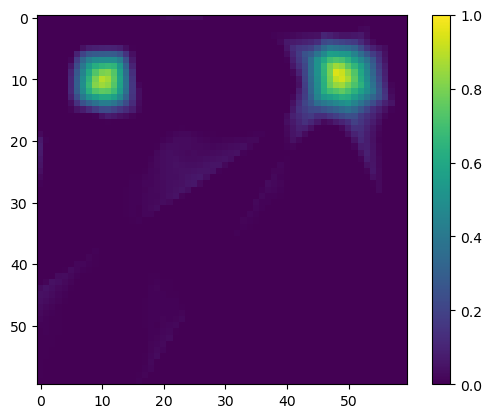

1640
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0124
loss from regularizer: 0.00018978421576321125
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0084
loss from regularizer: 0.0001954084145836532
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0082
loss from regularizer: 0.00019258350948803127
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0097
loss from regularizer: 0.00019258861721027642
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

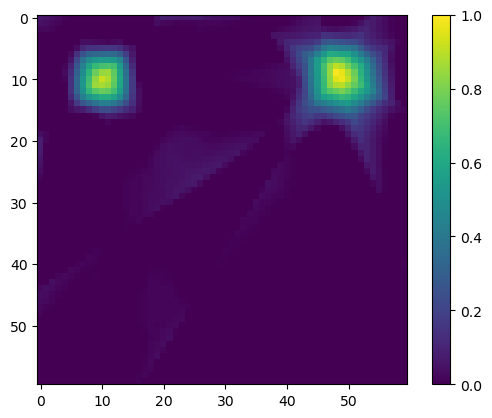

1650
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0110
loss from regularizer: 0.00019009441894013435
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0126
loss from regularizer: 0.00018504088802728802
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0082
loss from regularizer: 0.0001938781060744077
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0077
loss from regularizer: 0.00018807862943504006
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

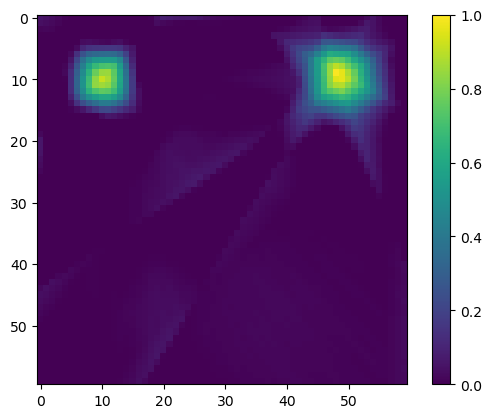

1660
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0080
loss from regularizer: 0.00018469234055373818
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0081
loss from regularizer: 0.00018297908536624163
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0082
loss from regularizer: 0.00018863120931200683
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 7ms/step - loss: 0.0088 - val_loss: 0.0084
loss from regularizer: 0.00018179701874032617
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

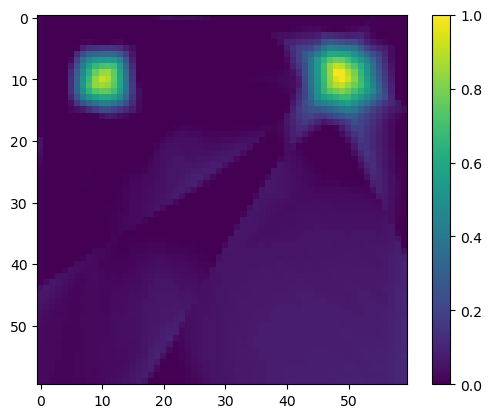

1670
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0090
loss from regularizer: 0.00019999322830699384
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0079
loss from regularizer: 0.00018916201952379197
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0089
loss from regularizer: 0.00019093843002337962
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0080
loss from regularizer: 0.00018918339628726244
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

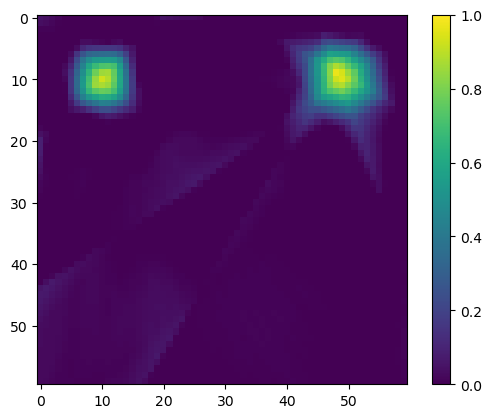

1680
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0083
loss from regularizer: 0.00018556186114437878
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0086
loss from regularizer: 0.00018585840007290244
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0078
loss from regularizer: 0.0001892932632472366
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0081
loss from regularizer: 0.00018368077871855348
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

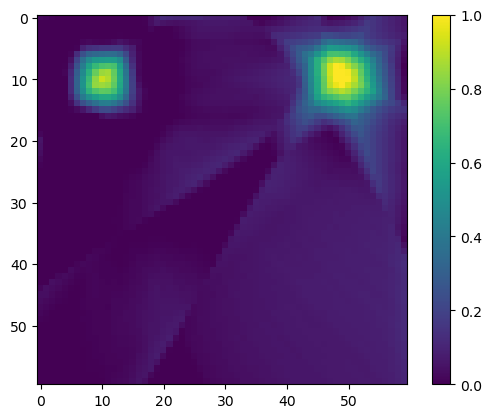

1690
176/176 [==============================] - 1s 6ms/step - loss: 0.0091 - val_loss: 0.0082
loss from regularizer: 0.000186114149983041
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0091
loss from regularizer: 0.0001824754144763574
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0090
loss from regularizer: 0.00018416835519019514
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0093
loss from regularizer: 0.00018981361063197255
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

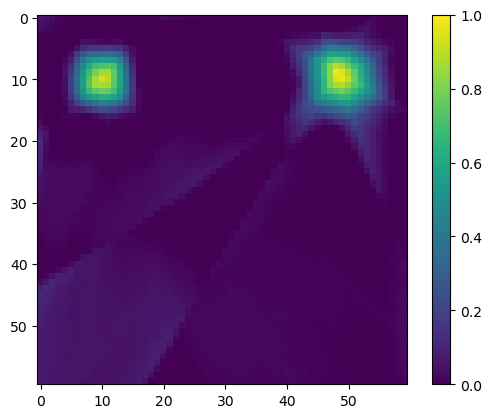

1700
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0079
loss from regularizer: 0.00019712053472176194
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0089
loss from regularizer: 0.00017654005205258727
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0097 - val_loss: 0.0088
loss from regularizer: 0.00017839809879660606
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0085
loss from regularizer: 0.0001893717999337241
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

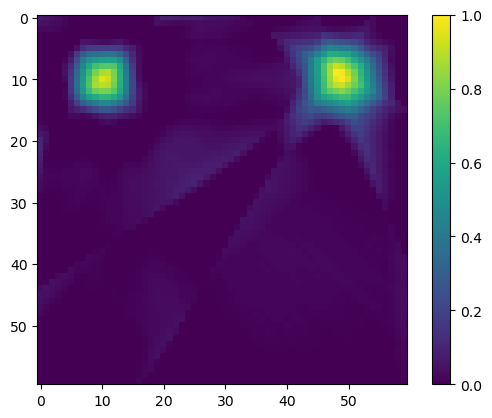

1710
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0118
loss from regularizer: 0.00018869867199100554
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0081
loss from regularizer: 0.00017510316683910787
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0085
loss from regularizer: 0.00018729789007920772
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0097
loss from regularizer: 0.00018052598170470446
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

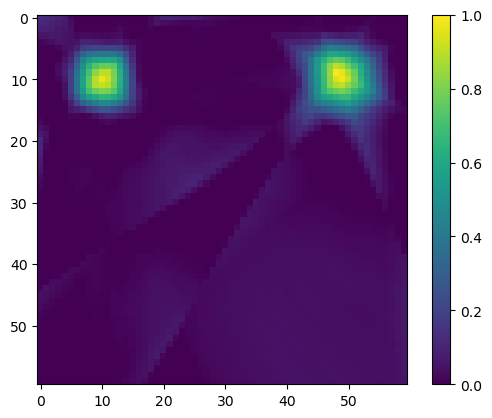

1720
176/176 [==============================] - 1s 6ms/step - loss: 0.0092 - val_loss: 0.0088
loss from regularizer: 0.00018858407565858215
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0083
loss from regularizer: 0.00018487594206817448
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0083
loss from regularizer: 0.00017404532991349697
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0096
loss from regularizer: 0.00018899481801781803
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

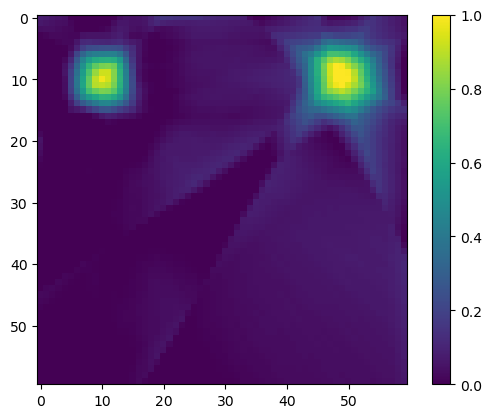

1730
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0079
loss from regularizer: 0.00018000337877310812
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0101
loss from regularizer: 0.00018915001419372857
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0082
loss from regularizer: 0.00018148412345908582
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0093
loss from regularizer: 0.00017410430882591754
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

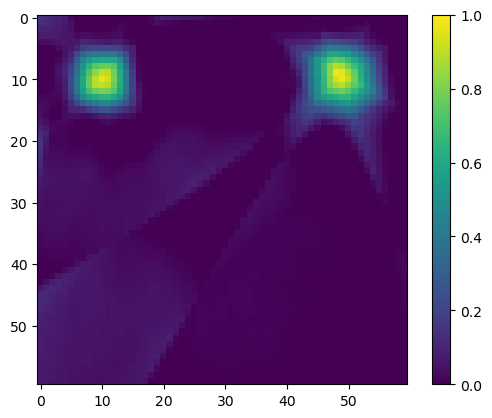

1740
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0082
loss from regularizer: 0.00017571501666679978
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0078
loss from regularizer: 0.00017951871268451214
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0077
loss from regularizer: 0.00018451946380082518
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0086
loss from regularizer: 0.00018532491230871528
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

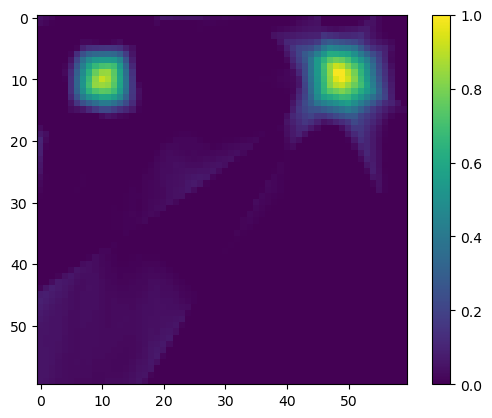

1750
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0106
loss from regularizer: 0.00017910149472299963
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0098
loss from regularizer: 0.00018396010273136199
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0116
loss from regularizer: 0.00018825115694198757
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0083
loss from regularizer: 0.00017840159125626087
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

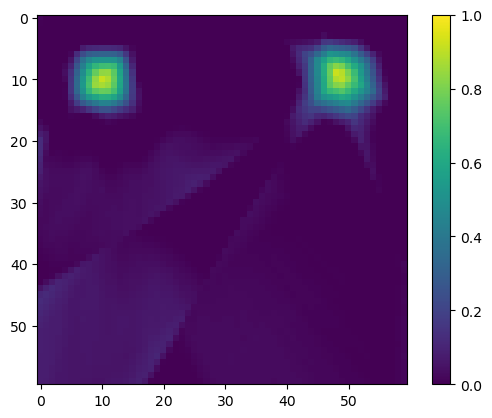

1760
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0088
loss from regularizer: 0.00017174497770611197
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0081
loss from regularizer: 0.00017915024363901466
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0078
loss from regularizer: 0.0001786848733900115
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0082
loss from regularizer: 0.00017225560441147536
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

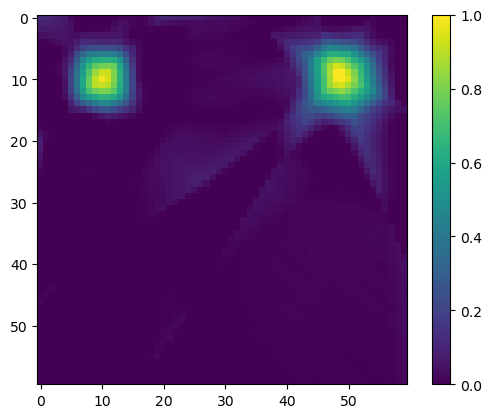

1770
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0091
loss from regularizer: 0.00018279651703778654
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0080
loss from regularizer: 0.00018362629634793848
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0077
loss from regularizer: 0.00017006753478199244
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0097
loss from regularizer: 0.00017741484043654054
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

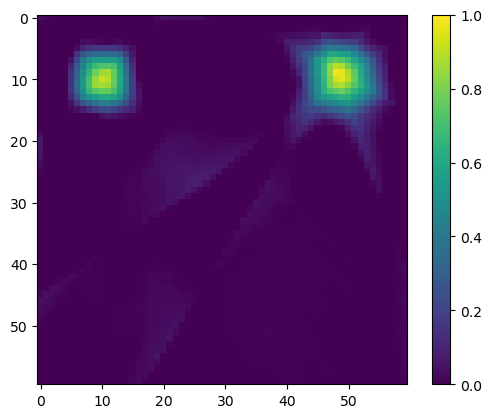

1780
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0092
loss from regularizer: 0.00016484135994687676
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0084
loss from regularizer: 0.00017884722910821438
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0087
loss from regularizer: 0.00017513900820631534
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0087
loss from regularizer: 0.0001712119410512969
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

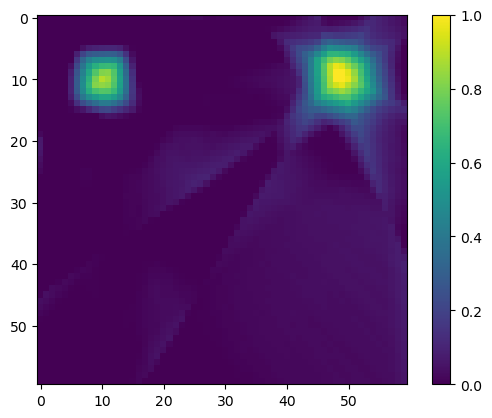

1790
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0089
loss from regularizer: 0.00018203322542831302
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0091
loss from regularizer: 0.00017521240806672722
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0081
loss from regularizer: 0.00016839479212649167
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0087
loss from regularizer: 0.00018044649914372712
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

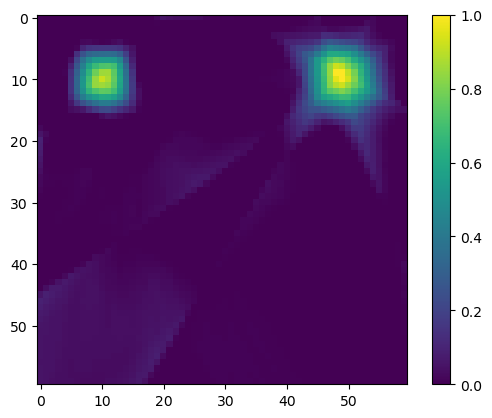

1800
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0077
loss from regularizer: 0.00017605636094231158
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0080
loss from regularizer: 0.00017787932301871479
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0091
loss from regularizer: 0.0001813485287129879
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0075
loss from regularizer: 0.0001678398111835122
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

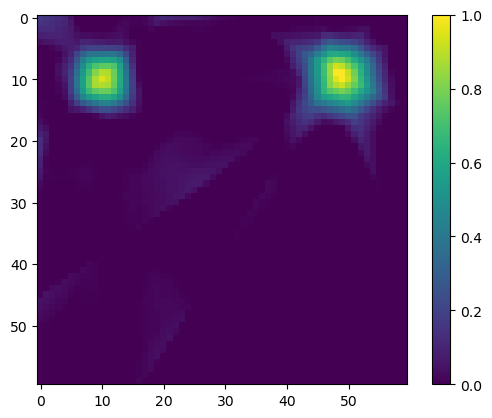

1810
176/176 [==============================] - 1s 6ms/step - loss: 0.0093 - val_loss: 0.0081
loss from regularizer: 0.0001795343850972131
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0075
loss from regularizer: 0.00017694961570668966
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0078
loss from regularizer: 0.00018707137496676296
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0087
loss from regularizer: 0.00018088234355673194
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

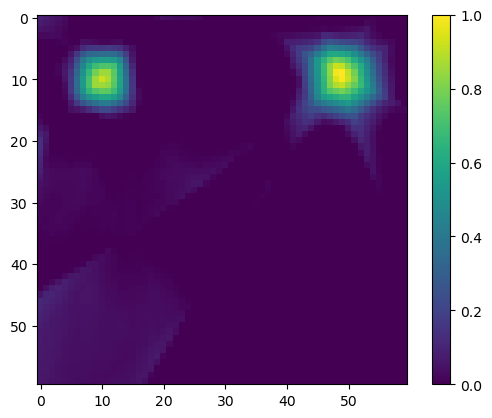

1820
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0093
loss from regularizer: 0.00017799626220948994
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0100
loss from regularizer: 0.00017454888438805938
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0118
loss from regularizer: 0.00017658328579273075
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0079
loss from regularizer: 0.00018296913185622543
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

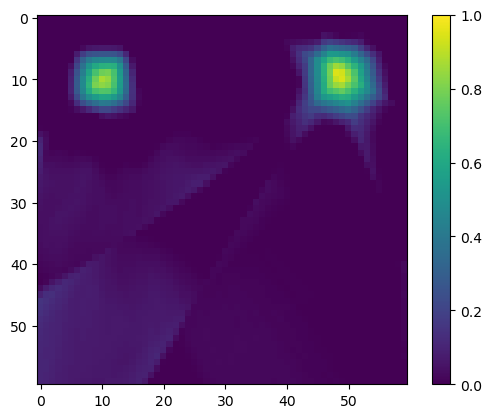

1830
176/176 [==============================] - 1s 5ms/step - loss: 0.0099 - val_loss: 0.0079
loss from regularizer: 0.00017637541168369353
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0079
loss from regularizer: 0.00017590897914487869
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0087
loss from regularizer: 0.0001764079788699746
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0079
loss from regularizer: 0.00017976915114559233
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

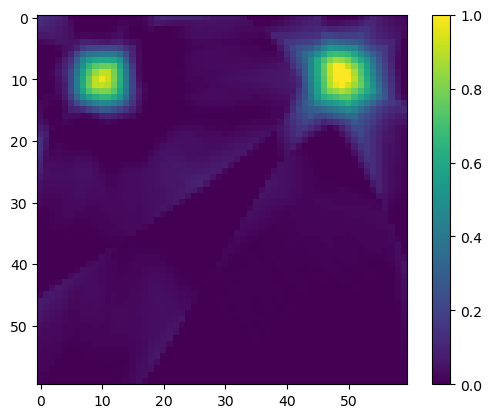

1840
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00017132612993009388
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0083
loss from regularizer: 0.00017175290849991143
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0097
loss from regularizer: 0.00017279197345487773
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0079
loss from regularizer: 0.00018334802007302642
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

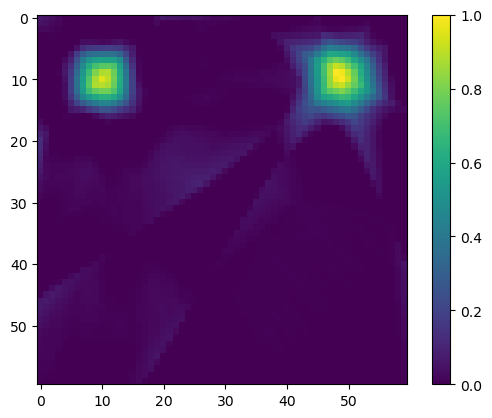

1850
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0081
loss from regularizer: 0.00017687695799395442
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0078
loss from regularizer: 0.00017827829287853092
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0097
loss from regularizer: 0.00017028013826347888
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0079
loss from regularizer: 0.00017983082216233015
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

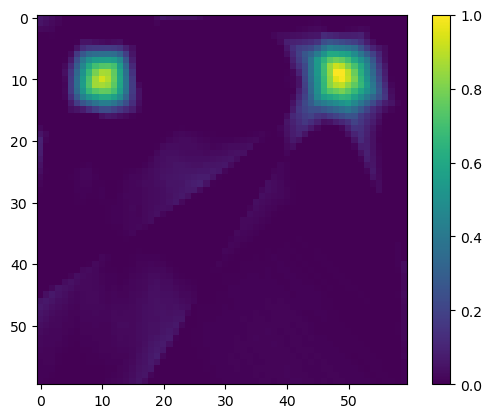

1860
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0076
loss from regularizer: 0.00017673704132903367
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0091
loss from regularizer: 0.00018242228543385863
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0077
loss from regularizer: 0.00017888675210997462
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0084 - val_loss: 0.0079
loss from regularizer: 0.00017221405869349837
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

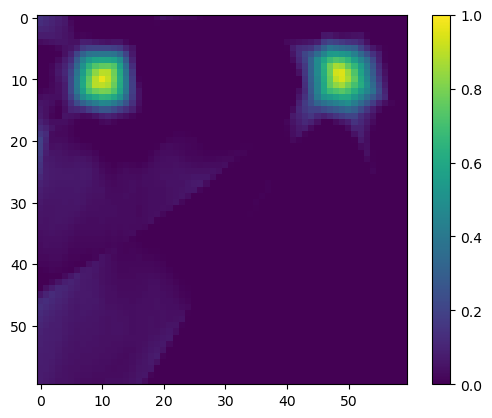

1870
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0077
loss from regularizer: 0.00017883084365166724
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0092
loss from regularizer: 0.00018008782353717834
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0080
loss from regularizer: 0.00017444798140786588
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0102
loss from regularizer: 0.00018312904285266995
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

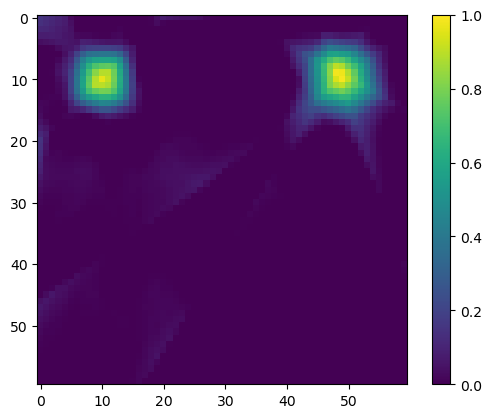

1880
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0115
loss from regularizer: 0.00017032619507517666
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0078
loss from regularizer: 0.00017590378411114216
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00017480558017268777
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0088
loss from regularizer: 0.00016302497533615679
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

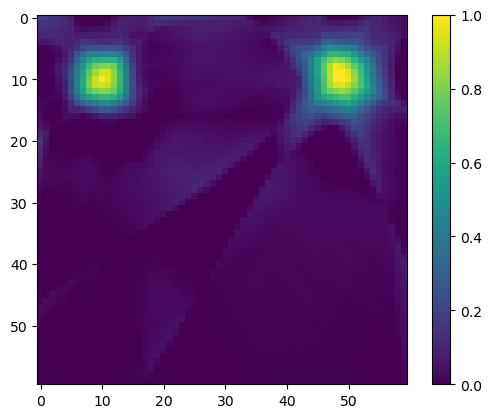

1890
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0080
loss from regularizer: 0.00017322464555036277
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0079
loss from regularizer: 0.00017869158182293177
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0080
loss from regularizer: 0.00017403604579158127
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0087
loss from regularizer: 0.00017081620171666145
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

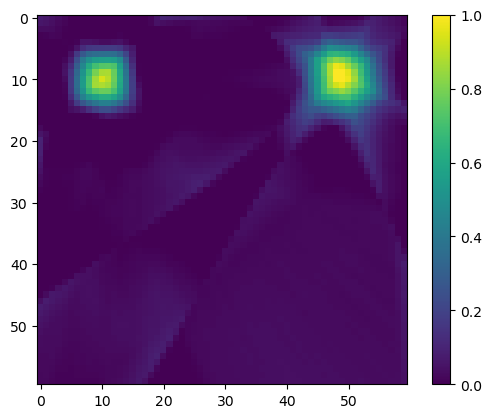

1900
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0078
loss from regularizer: 0.00018111983081325889
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0098
loss from regularizer: 0.0001712110679363832
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0078
loss from regularizer: 0.00017399185162503272
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0086
loss from regularizer: 0.0001747315691318363
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

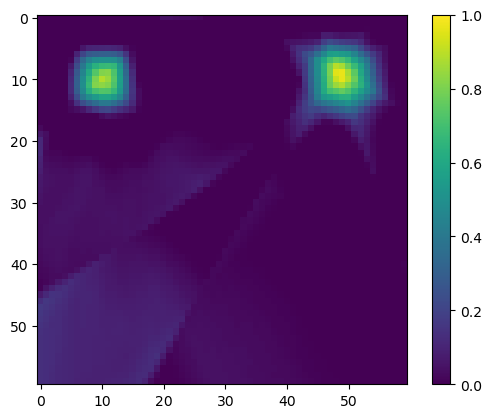

1910
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0081
loss from regularizer: 0.00017721763288136572
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0091 - val_loss: 0.0083
loss from regularizer: 0.00017101185221690685
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0093
loss from regularizer: 0.00017380461213178933
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0114
loss from regularizer: 0.00018342658586334437
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

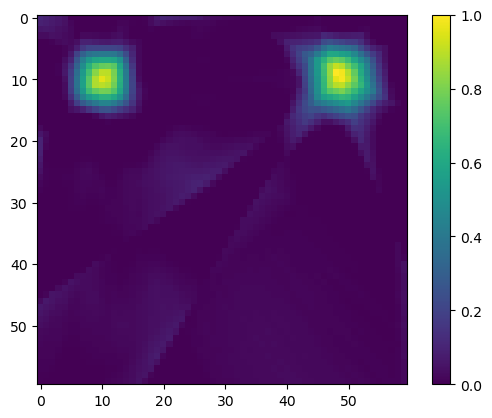

1920
176/176 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 0.0076
loss from regularizer: 0.00017980621487367898
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0078
loss from regularizer: 0.0001696176186669618
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0076
loss from regularizer: 0.00016884513024706393
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0084
loss from regularizer: 0.00016658623644616455
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

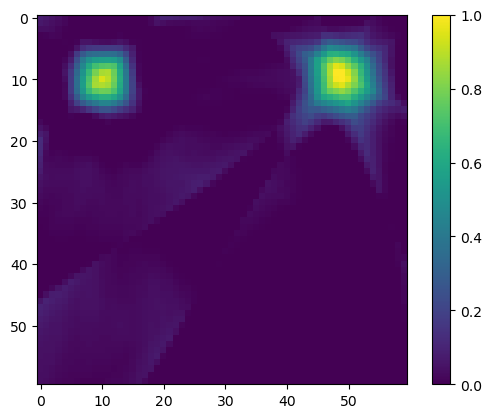

1930
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0076
loss from regularizer: 0.00017300619219895452
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0076
loss from regularizer: 0.0001726589835016057
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0099
loss from regularizer: 0.0001802631450118497
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0077
loss from regularizer: 0.00017793738516047597
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

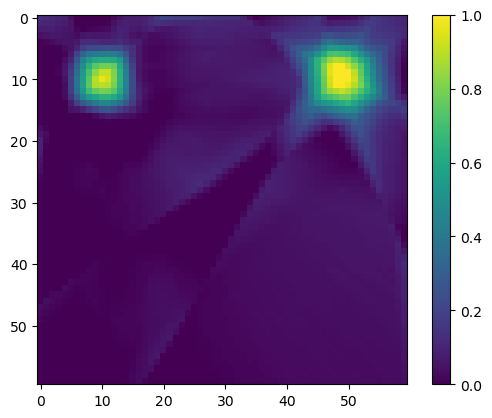

1940
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0077
loss from regularizer: 0.00018269768042955548
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0093
loss from regularizer: 0.00018412069766782224
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0091
loss from regularizer: 0.00017318841128144413
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0077
loss from regularizer: 0.0001819511380745098
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

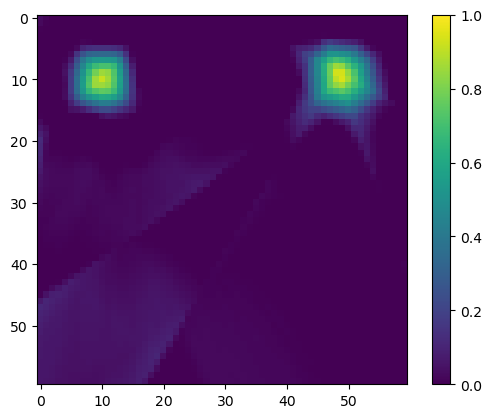

1950
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0081
loss from regularizer: 0.00018548700609244406
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00017068082524929196
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0076
loss from regularizer: 0.00017946046136785299
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0084 - val_loss: 0.0086
loss from regularizer: 0.00017587344336789101
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

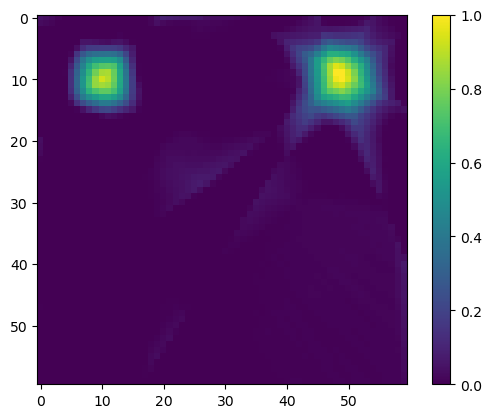

1960
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0074
loss from regularizer: 0.0001760943850968033
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00017191452207043767
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0091
loss from regularizer: 0.00016913400031626225
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0078
loss from regularizer: 0.00017142818251159042
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

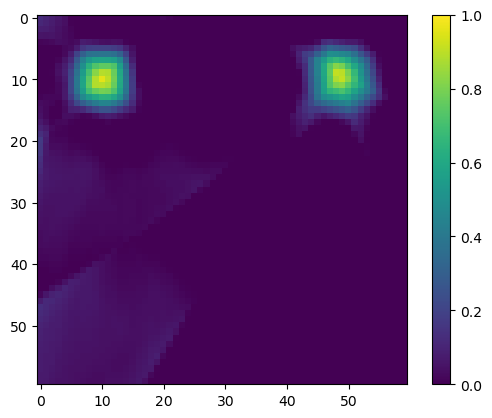

1970
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0086
loss from regularizer: 0.00018126703798770905
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0078
loss from regularizer: 0.0001705185422906652
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0078
loss from regularizer: 0.00017553041107021272
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0076
loss from regularizer: 0.00017393527377862483
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

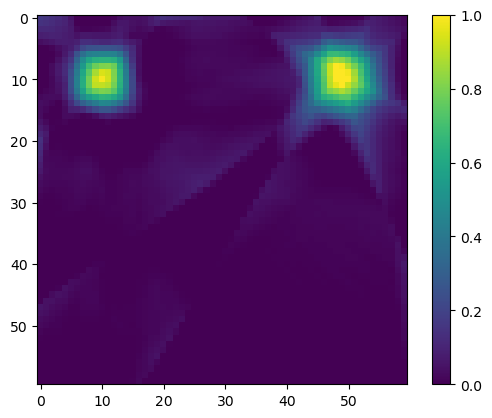

1980
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0078
loss from regularizer: 0.0001745852205203846
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0084
loss from regularizer: 0.0001807141088647768
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0077
loss from regularizer: 0.00017510967154521495
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0080
loss from regularizer: 0.00017226696945726871
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

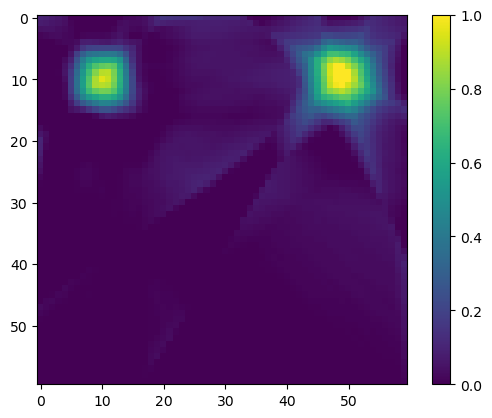

1990
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0077
loss from regularizer: 0.0001721501030260697
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0085
loss from regularizer: 0.00016780354781076312
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0079
loss from regularizer: 0.0001743793982313946
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0078
loss from regularizer: 0.0001704726309981197
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

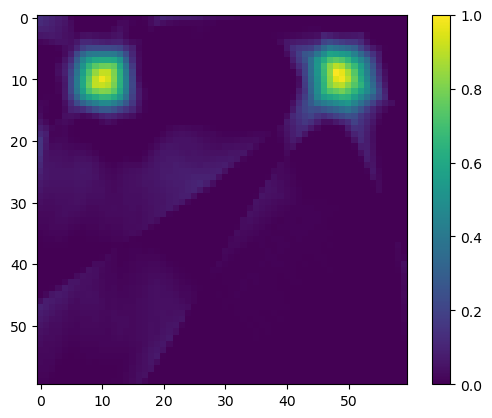

2000
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0083
loss from regularizer: 0.00017085106810554862
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0091
loss from regularizer: 0.00017774105072021484
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0083
loss from regularizer: 0.00018333920161239803
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0080
loss from regularizer: 0.0001787032961146906
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

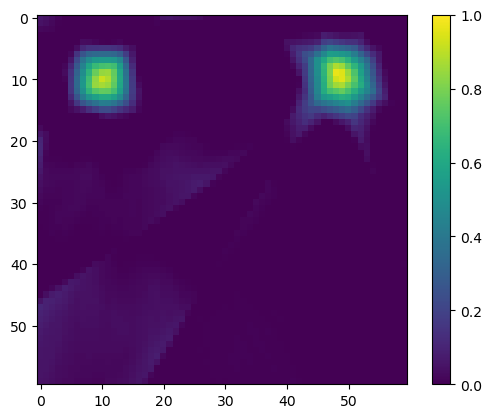

2010
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0090
loss from regularizer: 0.00018286176782567054
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0083
loss from regularizer: 0.00018309883307665586
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0076
loss from regularizer: 0.00017658963042777032
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0076
loss from regularizer: 0.00017136243695858866
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

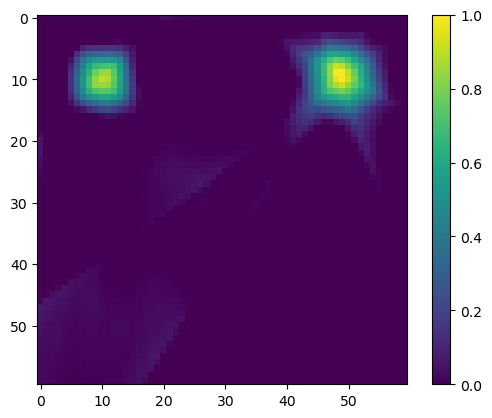

2020
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0086
loss from regularizer: 0.00017326419765595347
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00017909097368828952
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0093
loss from regularizer: 0.00017931504407897592
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0077
loss from regularizer: 0.00017132199718616903
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

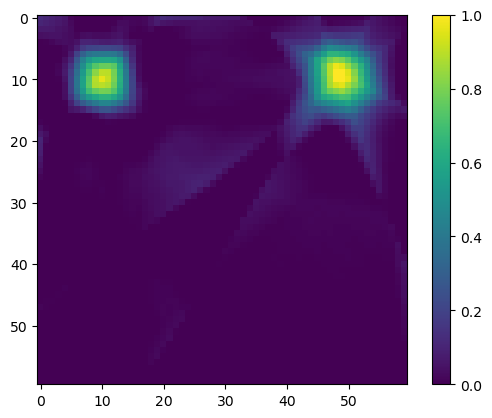

2030
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0111
loss from regularizer: 0.00017527240561321378
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0114
loss from regularizer: 0.00017042066610883921
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0084
loss from regularizer: 0.00017672333342488855
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0097
loss from regularizer: 0.00017077793017961085
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

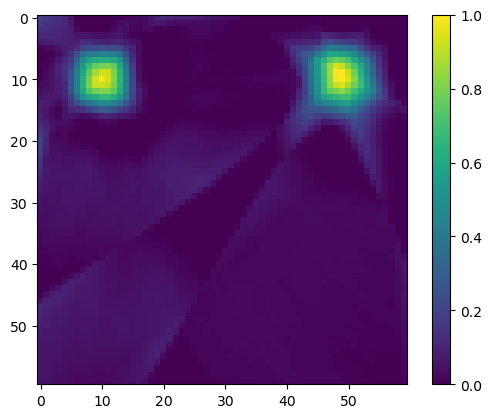

2040
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0093
loss from regularizer: 0.00017428529099561274
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0091
loss from regularizer: 0.0001733910758048296
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0089
loss from regularizer: 0.00016935814346652478
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0082
loss from regularizer: 0.00017929535533767194
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

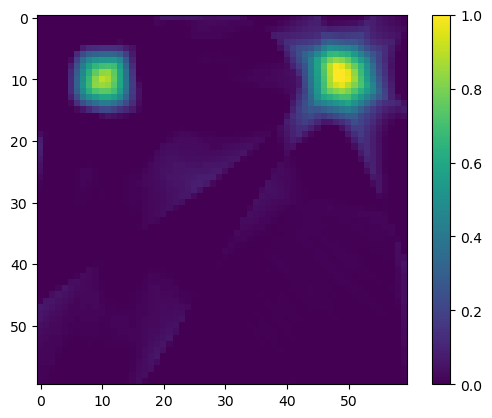

2050
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0083
loss from regularizer: 0.0001684905291767791
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0078
loss from regularizer: 0.00017113103240262717
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0084
loss from regularizer: 0.0001683682348811999
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0109
loss from regularizer: 0.0001678126136539504
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

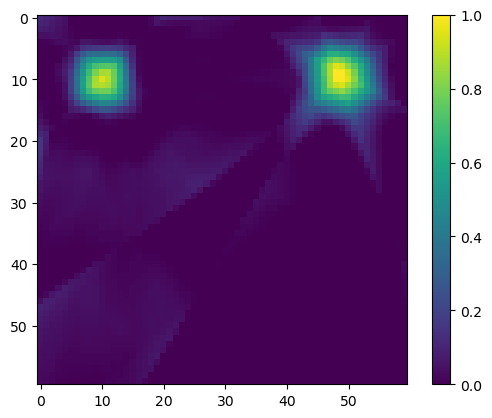

2060
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0085
loss from regularizer: 0.00017716464935801923
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0073
loss from regularizer: 0.0001718452258501202
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00017201786977238953
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0090 - val_loss: 0.0080
loss from regularizer: 0.000174079614225775
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

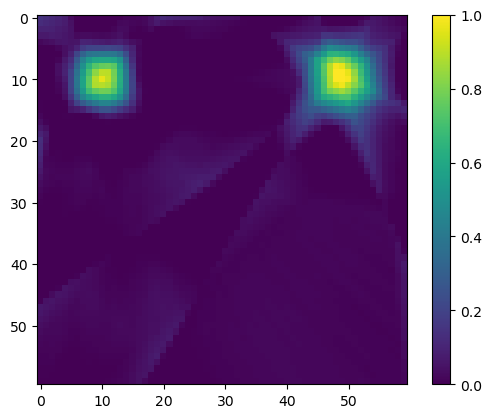

2070
176/176 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0090
loss from regularizer: 0.00017516646767035127
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0084
loss from regularizer: 0.00017480568203609437
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0078
loss from regularizer: 0.00017648228094913065
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0099
loss from regularizer: 0.00016766891349107027
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

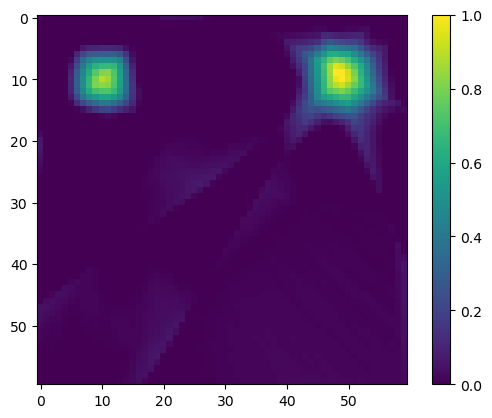

2080
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0075
loss from regularizer: 0.00018005161837209016
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0076
loss from regularizer: 0.00016968870477285236
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0076
loss from regularizer: 0.00017845691763795912
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0079
loss from regularizer: 0.00017399403441231698
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

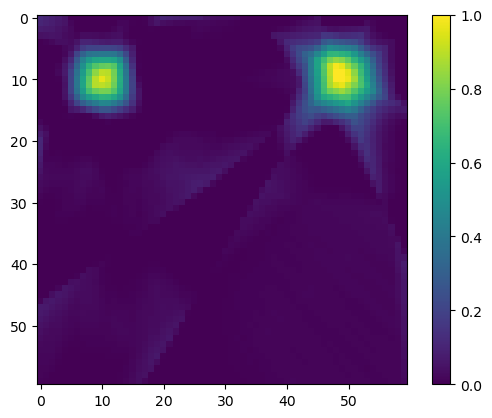

2090
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0076
loss from regularizer: 0.0001717504783300683
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0086 - val_loss: 0.0077
loss from regularizer: 0.0001786335778888315
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0090 - val_loss: 0.0080
loss from regularizer: 0.00017220908193849027
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0087 - val_loss: 0.0080
loss from regularizer: 0.00017863990797195584
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

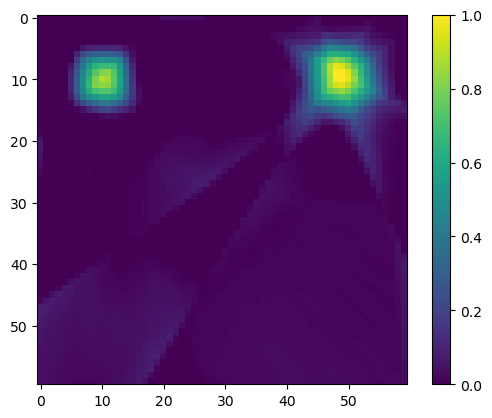

2100
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0082
loss from regularizer: 0.00017477483197581023
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0076
loss from regularizer: 0.00017956970259547234
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0077
loss from regularizer: 0.00018323179392609745
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0097
loss from regularizer: 0.00017384393140673637
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

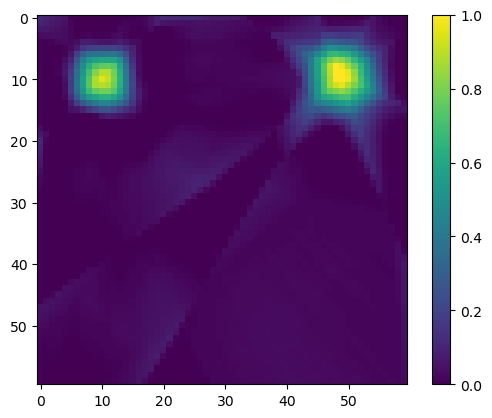

2110
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0081
loss from regularizer: 0.00017119600670412183
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0107
loss from regularizer: 0.00017773377476260066
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0079
loss from regularizer: 0.0001721663138596341
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0090
loss from regularizer: 0.00017669505905359983
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

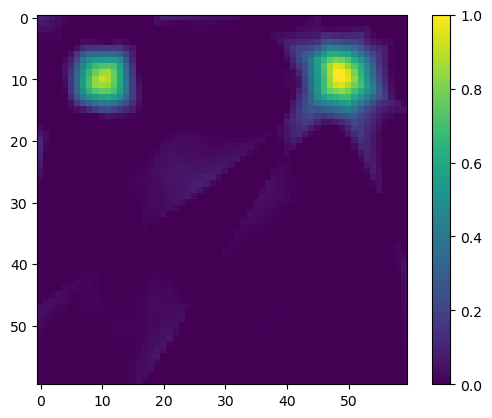

2120
176/176 [==============================] - 1s 6ms/step - loss: 0.0084 - val_loss: 0.0091
loss from regularizer: 0.00018205525702796876
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0080
loss from regularizer: 0.0001746366178849712
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0086
loss from regularizer: 0.00017855763144325465
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0078
loss from regularizer: 0.0001790729002095759
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

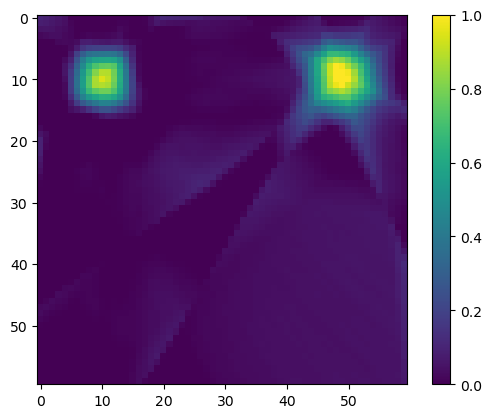

2130
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0078
loss from regularizer: 0.00017409195424988866
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0088 - val_loss: 0.0084
loss from regularizer: 0.00016776344273239374
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0092 - val_loss: 0.0078
loss from regularizer: 0.00017581375141162425
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
loss from regularizer: 0.00017360321362502873
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

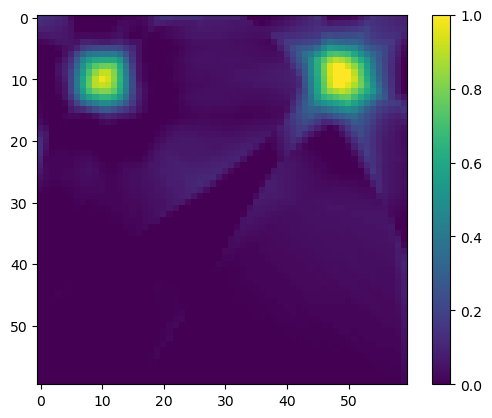

2140
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0080
loss from regularizer: 0.00017707202641759068
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0077
loss from regularizer: 0.0001827742817113176
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0086
loss from regularizer: 0.00017387146363034844
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0091
loss from regularizer: 0.00017158671107608825
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

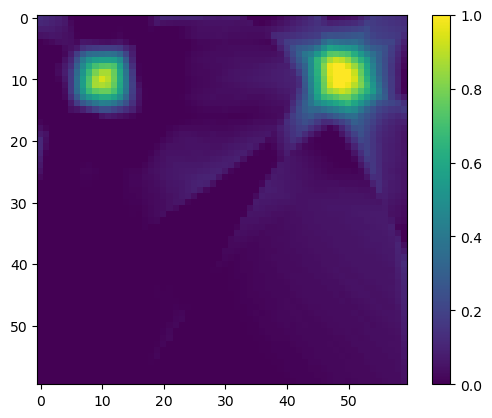

2150
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0079
loss from regularizer: 0.0001717504346743226
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0084
loss from regularizer: 0.0001697260740911588
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0085
loss from regularizer: 0.00017585427849553525
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0077
loss from regularizer: 0.0001789812376955524
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

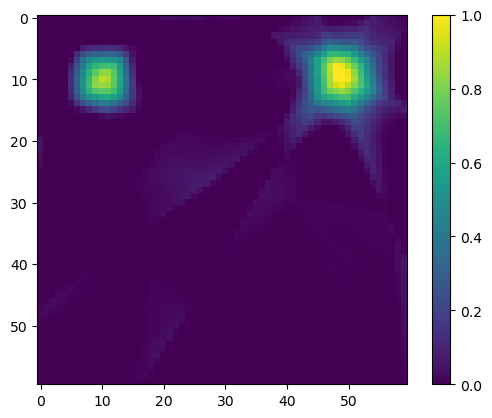

2160
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0097
loss from regularizer: 0.00018012456712312996
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0075
loss from regularizer: 0.00017630375805310905
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0075
loss from regularizer: 0.00016429554671049118
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0079
loss from regularizer: 0.00016995331679936498
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

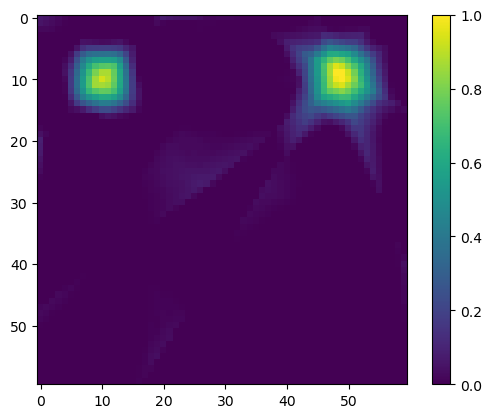

2170
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0104
loss from regularizer: 0.00016739302373025566
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0081
loss from regularizer: 0.00017418408242519945
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0080
loss from regularizer: 0.00017272724653594196
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0076
loss from regularizer: 0.00017389358254149556
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

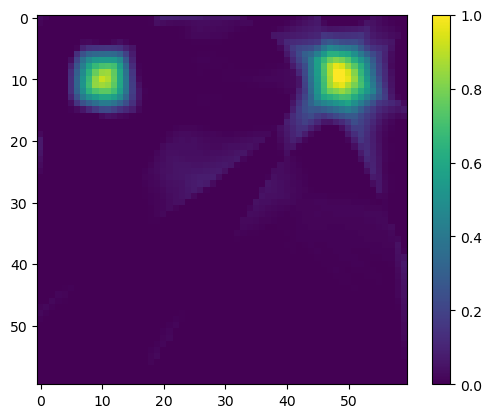

2180
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0109
loss from regularizer: 0.00018014945089817047
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0116
loss from regularizer: 0.00018104260379914194
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0104
loss from regularizer: 0.00016883279022295028
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0082
loss from regularizer: 0.00017274731362704188
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

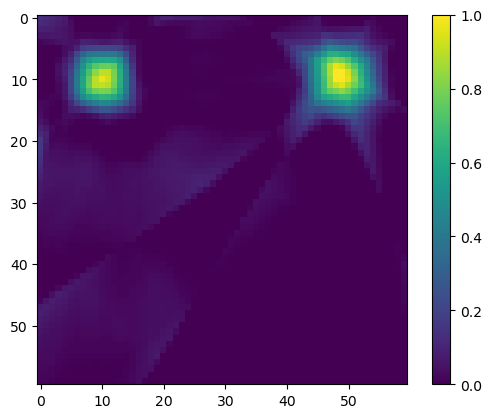

2190
176/176 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0078
loss from regularizer: 0.00016975098697002977
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0077
loss from regularizer: 0.00016928250261116773
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0075
loss from regularizer: 0.00016372832760680467
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0080
loss from regularizer: 0.00016621616668999195
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

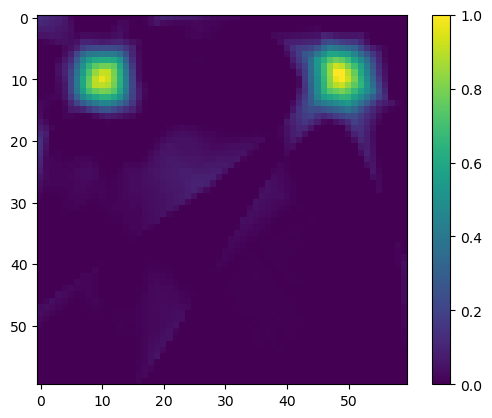

2200
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0075
loss from regularizer: 0.0001659556437516585
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0082
loss from regularizer: 0.00017545530863571912
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0074
loss from regularizer: 0.00016973451420199126
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0093
loss from regularizer: 0.00017280256724916399
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

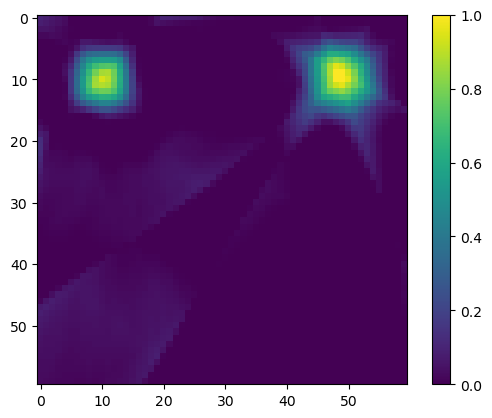

2210
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0085
loss from regularizer: 0.00017600196588318795
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0081
loss from regularizer: 0.00017029448645189404
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0078
loss from regularizer: 0.00017385449609719217
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0078
loss from regularizer: 0.00017145437595900148
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

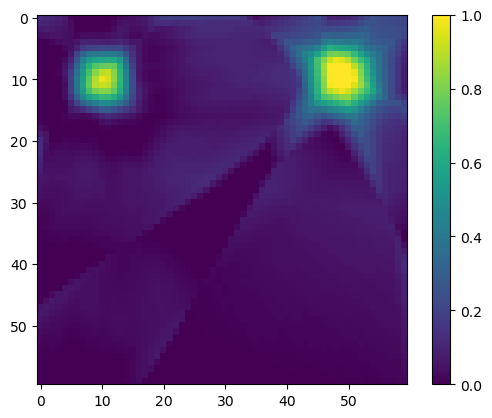

2220
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0089
loss from regularizer: 0.0001684416929492727
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0073
loss from regularizer: 0.00016173330368474126
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0073
loss from regularizer: 0.0001659867848502472
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0077
loss from regularizer: 0.0001701668807072565
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

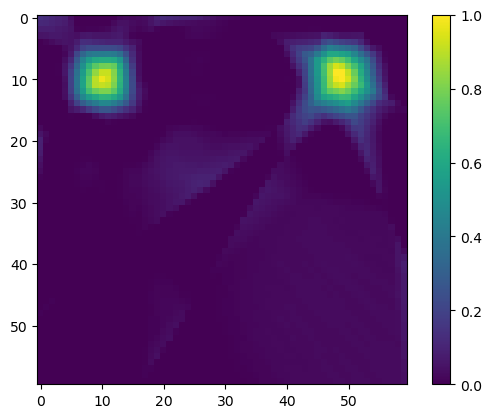

2230
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0085
loss from regularizer: 0.00016719028644729406
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0080
loss from regularizer: 0.00017138506518676877
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0092
loss from regularizer: 0.00017759279580786824
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0081
loss from regularizer: 0.00016991462325677276
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

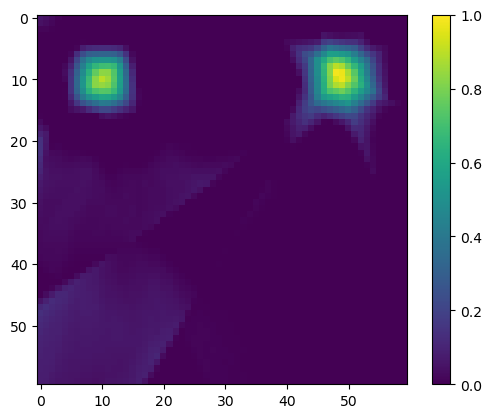

2240
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0086
loss from regularizer: 0.00016955366299953312
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0098
loss from regularizer: 0.00016854904242791235
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0085
loss from regularizer: 0.00017071682668756694
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0090
loss from regularizer: 0.00017330364789813757
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

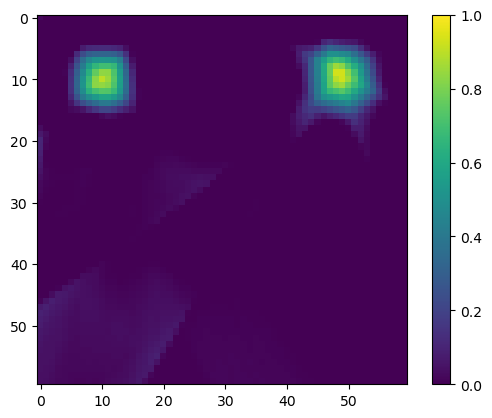

2250
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
loss from regularizer: 0.00016300796414725482
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
loss from regularizer: 0.00017569016199558973
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0077
loss from regularizer: 0.00017261100583709776
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0086
loss from regularizer: 0.00016459966718684882
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

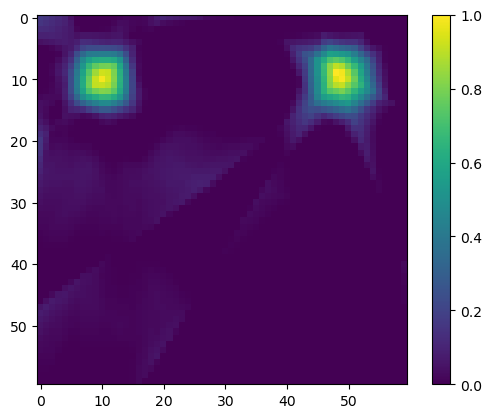

2260
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0073
loss from regularizer: 0.00017385106184519827
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0082
loss from regularizer: 0.00017005014524329454
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0080
loss from regularizer: 0.00016979282372631133
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00016845997015479952
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

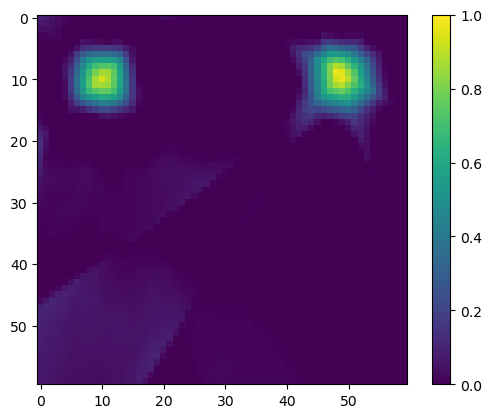

2270
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0081
loss from regularizer: 0.00017083622515201569
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0075
loss from regularizer: 0.00017654169641900808
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0094
loss from regularizer: 0.0001792900002328679
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0091
loss from regularizer: 0.00017949195171240717
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

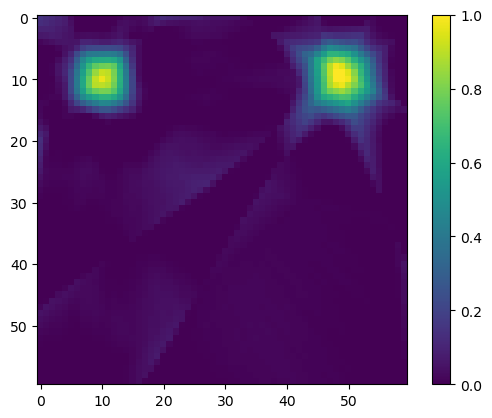

2280
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0080
loss from regularizer: 0.00017742585623636842
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0083
loss from regularizer: 0.00017470208695158362
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0080
loss from regularizer: 0.00016753464296925813
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0080
loss from regularizer: 0.00017092104826588184
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

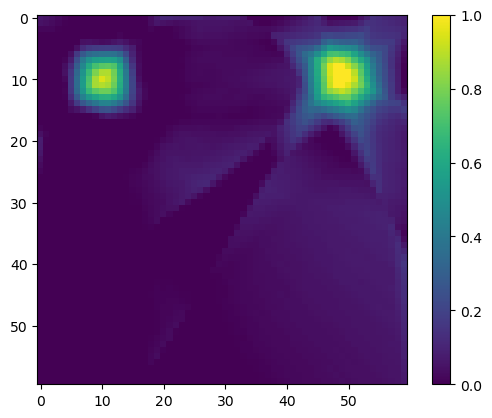

2290
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0076
loss from regularizer: 0.00016615982167422771
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0084 - val_loss: 0.0081
loss from regularizer: 0.00016748762573115528
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0076
loss from regularizer: 0.00016727819456718862
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00017870982992462814
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

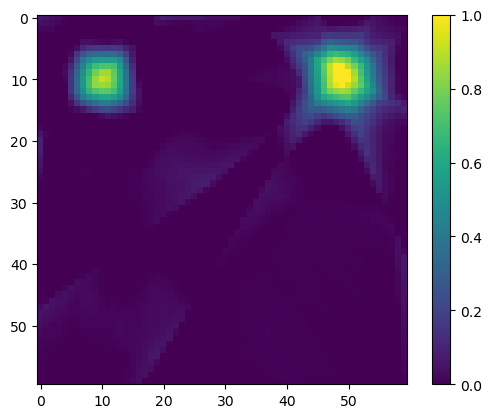

2300
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0088
loss from regularizer: 0.00016669816977810115
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0077
loss from regularizer: 0.00017069281602744013
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0100
loss from regularizer: 0.00017373001901432872
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0078
loss from regularizer: 0.0001720827422104776
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

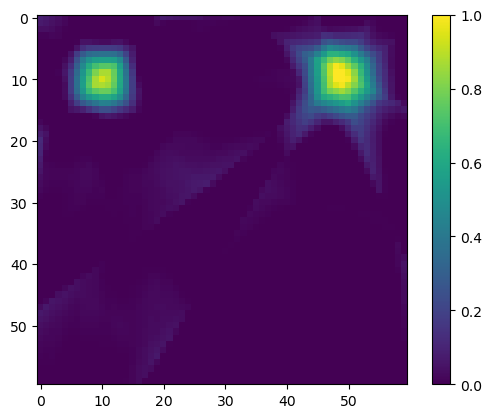

2310
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0076
loss from regularizer: 0.00016501080244779587
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0075
loss from regularizer: 0.00016446302470285445
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0078
loss from regularizer: 0.00016551694716326892
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0092
loss from regularizer: 0.00016713568766135722
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

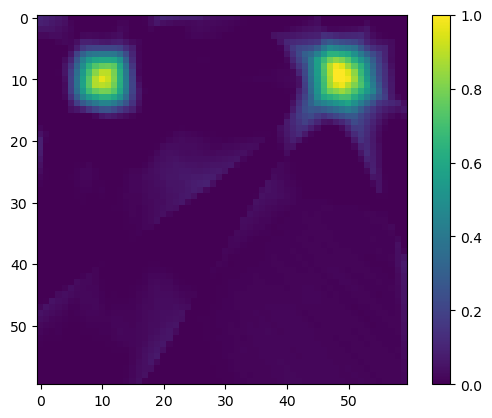

2320
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0082
loss from regularizer: 0.0001642938586883247
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0078
loss from regularizer: 0.0001740841835271567
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0083
loss from regularizer: 0.00017295895668212324
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0080
loss from regularizer: 0.0001669039629632607
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

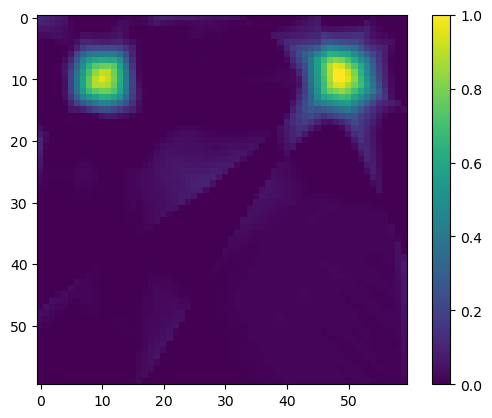

2330
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0084
loss from regularizer: 0.00017063289124052972
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0081
loss from regularizer: 0.0001678451953921467
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0091
loss from regularizer: 0.00016843443154357374
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0078
loss from regularizer: 0.00017140331328846514
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

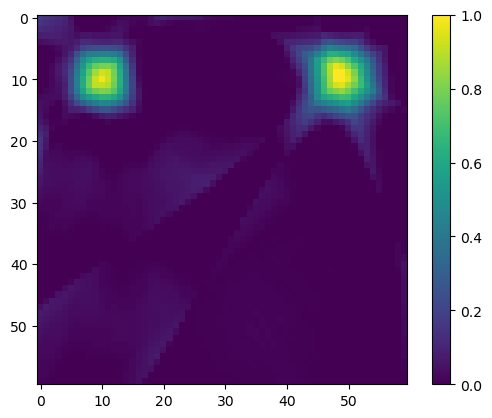

2340
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0078
loss from regularizer: 0.00017066625878214836
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0102
loss from regularizer: 0.00016883488569874316
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0092
loss from regularizer: 0.00018012225336860865
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0075
loss from regularizer: 0.00016958839842118323
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

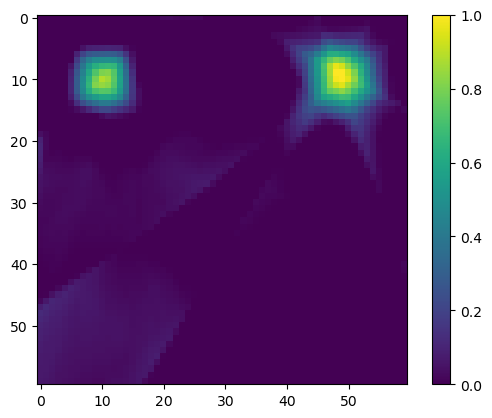

2350
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0094
loss from regularizer: 0.00016625421994831413
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0080
loss from regularizer: 0.00017047736037056893
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0079
loss from regularizer: 0.0001706048788037151
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0075
loss from regularizer: 0.00017054266936611384
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

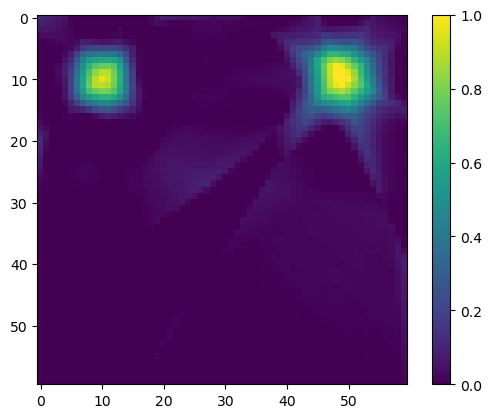

2360
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
loss from regularizer: 0.0001709028729237616
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.0001631384075153619
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0099
loss from regularizer: 0.00017188536003232002
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0076
loss from regularizer: 0.0001740174338920042
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

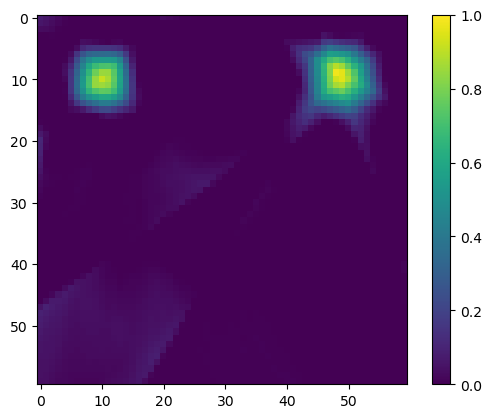

2370
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0081
loss from regularizer: 0.00017327071691397578
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0090
loss from regularizer: 0.00018166629888582975
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0089
loss from regularizer: 0.00017701851902529597
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0075
loss from regularizer: 0.00016848939412739128
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

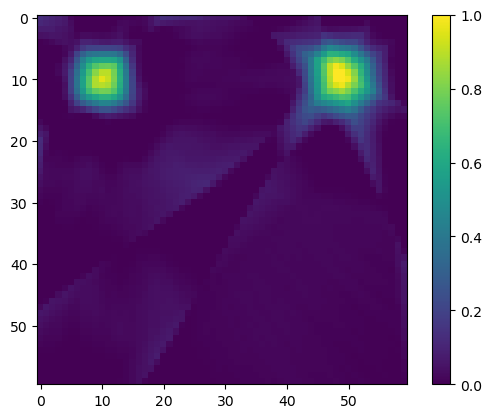

2380
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0082
loss from regularizer: 0.00017312994168605655
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0080
loss from regularizer: 0.0001651187485549599
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0077
loss from regularizer: 0.00017254990234505385
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0074
loss from regularizer: 0.00017298087186645716
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

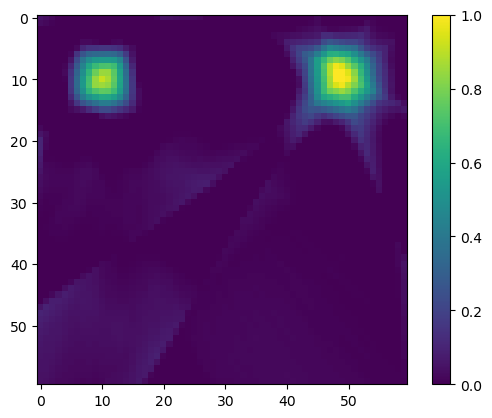

2390
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0084
loss from regularizer: 0.00016210963076446205
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0095
loss from regularizer: 0.00017318740719929338
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0080
loss from regularizer: 0.00017066151485778391
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0078
loss from regularizer: 0.0001708878844510764
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

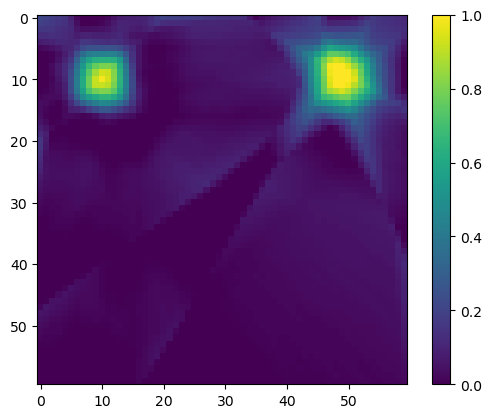

2400
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0084
loss from regularizer: 0.00016942588263191283
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0078
loss from regularizer: 0.00016944497474469244
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0078
loss from regularizer: 0.00017233905964531004
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0083
loss from regularizer: 0.00017797086911741644
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

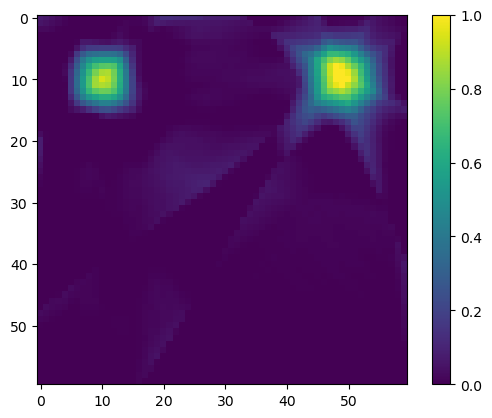

2410
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0101
loss from regularizer: 0.00017359861521981657
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0080
loss from regularizer: 0.00016708794282749295
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0076
loss from regularizer: 0.00016927804972510785
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0079
loss from regularizer: 0.00017553784709889442
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

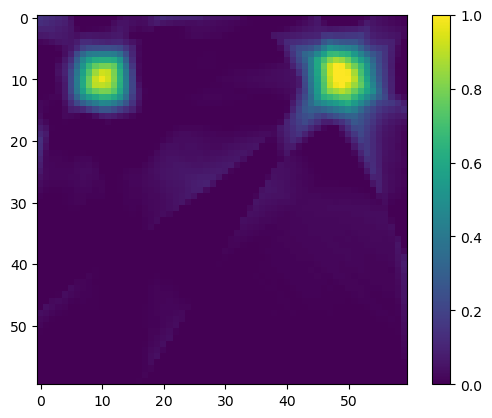

2420
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0074
loss from regularizer: 0.00016510888235643506
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0088
loss from regularizer: 0.00017661454330664128
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0077
loss from regularizer: 0.000176731773535721
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0088
loss from regularizer: 0.00016999228682834655
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

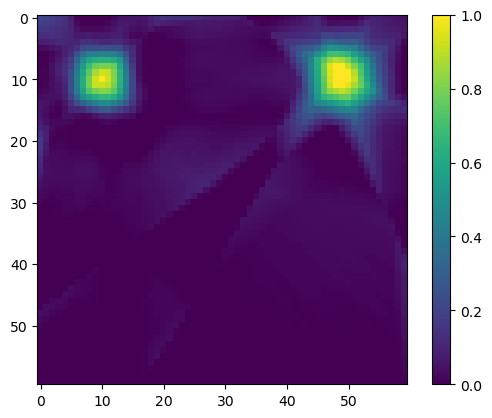

2430
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0084
loss from regularizer: 0.00016798039723653346
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0079
loss from regularizer: 0.00016767946362961084
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0083
loss from regularizer: 0.0001631764753255993
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0086 - val_loss: 0.0083
loss from regularizer: 0.0001691991783445701
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

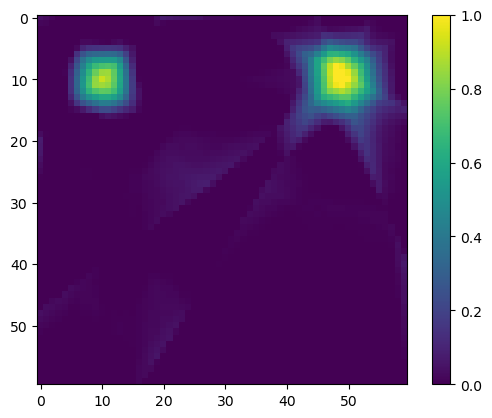

2440
176/176 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 0.0077
loss from regularizer: 0.0001684904273133725
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0079
loss from regularizer: 0.00017009396106004715
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0086
loss from regularizer: 0.0001710861106403172
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0088
loss from regularizer: 0.00016162495012395084
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

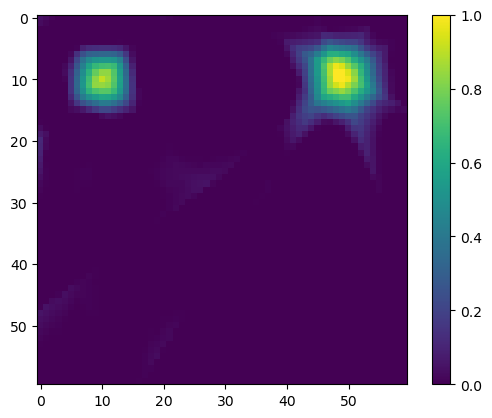

2450
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0077
loss from regularizer: 0.00016474485164508224
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0089
loss from regularizer: 0.00016887443780433387
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0093
loss from regularizer: 0.00016690330812707543
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0093
loss from regularizer: 0.00016721151769161224
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

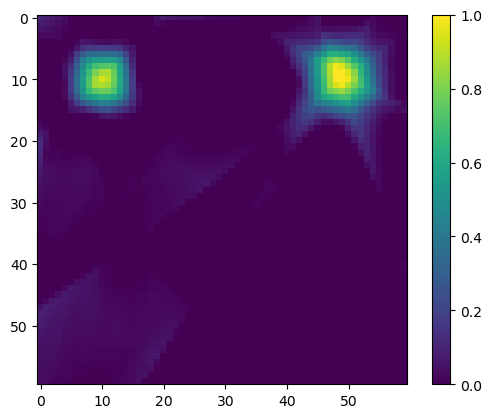

2460
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0077
loss from regularizer: 0.0001744531182339415
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0082
loss from regularizer: 0.000163175180205144
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 0.0075
loss from regularizer: 0.00017000777006614953
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0079
loss from regularizer: 0.00017111071792896837
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

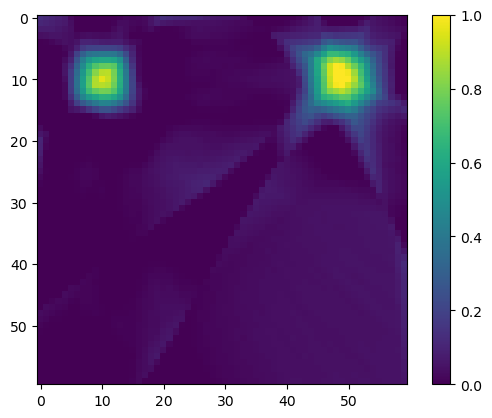

2470
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0075
loss from regularizer: 0.00016994615725707263
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0082
loss from regularizer: 0.00016770946967881173
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0102
loss from regularizer: 0.0001645227603148669
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0078
loss from regularizer: 0.00017730904801283032
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

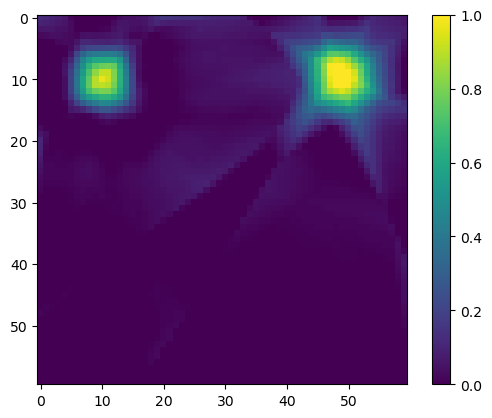

2480
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0078
loss from regularizer: 0.00016784515173640102
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0077
loss from regularizer: 0.0001706450857454911
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0088
loss from regularizer: 0.00017686958017293364
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0079
loss from regularizer: 0.00017465715063735843
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

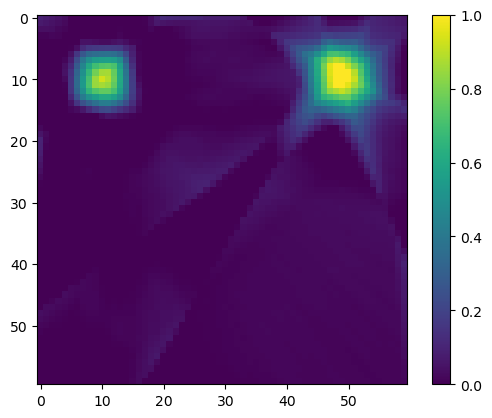

2490
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0079
loss from regularizer: 0.0001682904112385586
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0096
loss from regularizer: 0.00017980291158892214
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0077
loss from regularizer: 0.00016980849613901228
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0100
loss from regularizer: 0.00016946920368354768
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

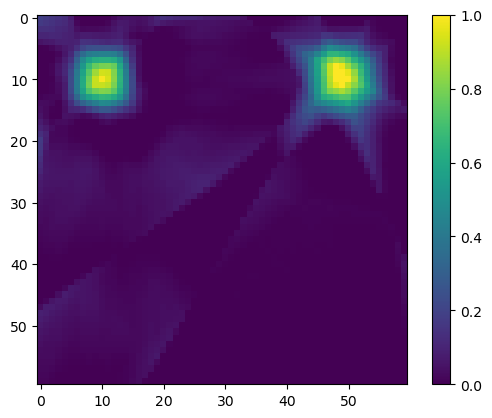

2500
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0079
loss from regularizer: 0.00017593718075659126
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0109
loss from regularizer: 0.00017915255739353597
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0096
loss from regularizer: 0.00017804180970415473
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0088
loss from regularizer: 0.00017100150580517948
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

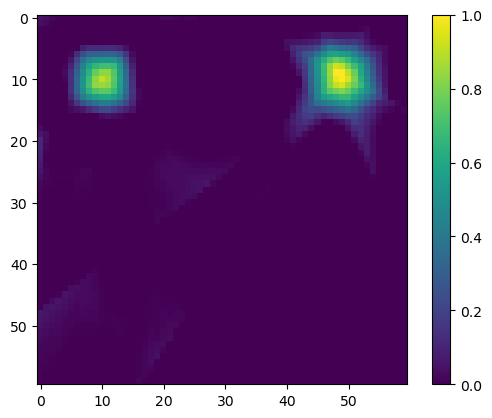

2510
176/176 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 0.0079
loss from regularizer: 0.00016606190183665603
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0081 - val_loss: 0.0075
loss from regularizer: 0.00017285380454268306
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0081 - val_loss: 0.0075
loss from regularizer: 0.00017239293083548546
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0102
loss from regularizer: 0.00016601970128249377
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

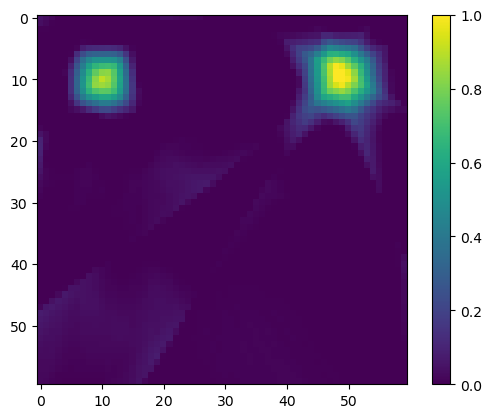

2520
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0074
loss from regularizer: 0.00017003144603222609
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0100
loss from regularizer: 0.00017303548520430923
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0079
loss from regularizer: 0.00016942847287282348
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0078
loss from regularizer: 0.00016784132458269596
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

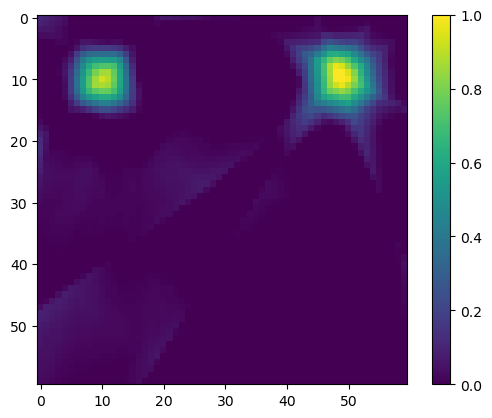

2530
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0075
loss from regularizer: 0.00016636858345009387
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0082
loss from regularizer: 0.00016179507656488568
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0079
loss from regularizer: 0.00016999740910250694
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0080
loss from regularizer: 0.0001736556296236813
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

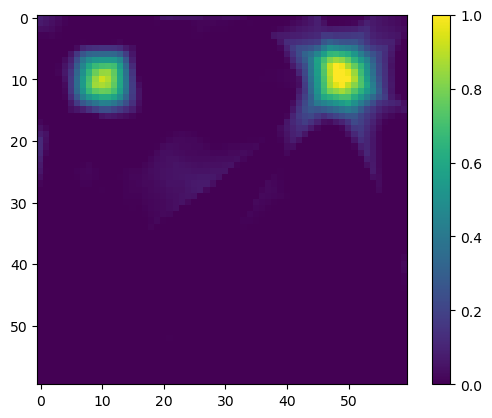

2540
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0076
loss from regularizer: 0.0001725853217067197
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0083
loss from regularizer: 0.00016471848357468843
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0080
loss from regularizer: 0.0001726617047097534
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0089
loss from regularizer: 0.00016878014139365405
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

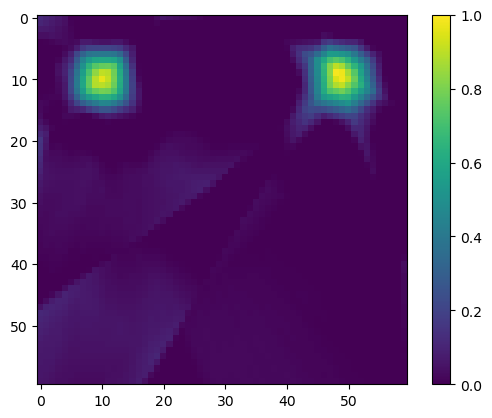

2550
176/176 [==============================] - 1s 6ms/step - loss: 0.0086 - val_loss: 0.0080
loss from regularizer: 0.00017060613026842475
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0080
loss from regularizer: 0.00016517032054252923
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0075
loss from regularizer: 0.0001584122801432386
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0088 - val_loss: 0.0081
loss from regularizer: 0.00016104821406770498
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

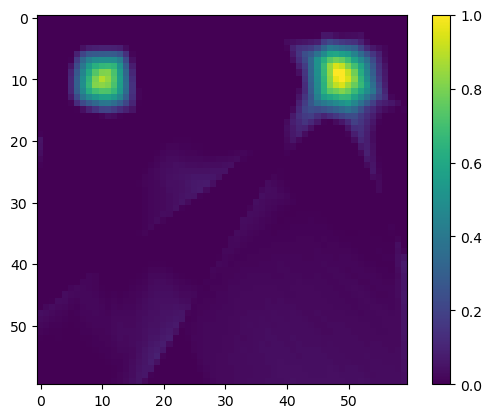

2560
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0079
loss from regularizer: 0.000162792595801875
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0076
loss from regularizer: 0.00016727254842408001
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0075
loss from regularizer: 0.00017986621242016554
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0083
loss from regularizer: 0.00017095141811296344
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

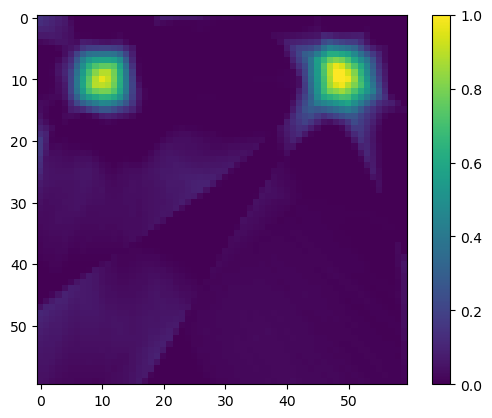

2570
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0074
loss from regularizer: 0.00016605501878075302
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0085
loss from regularizer: 0.0001636308297747746
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0075
loss from regularizer: 0.00016869965475052595
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0082
loss from regularizer: 0.00017729283717926592
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

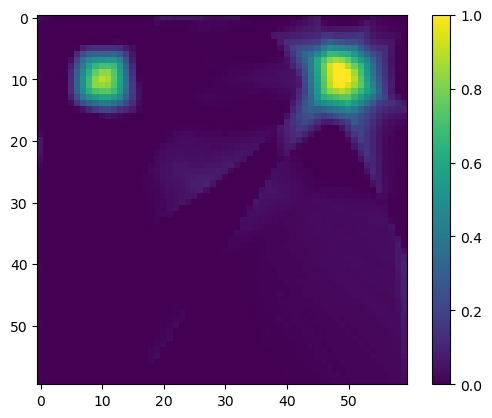

2580
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0077
loss from regularizer: 0.00016091404540929943
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0077
loss from regularizer: 0.000170981147675775
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0078
loss from regularizer: 0.00016659365792293102
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0077
loss from regularizer: 0.00016668725584167987
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

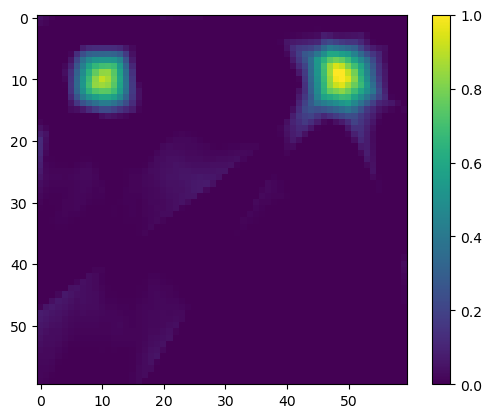

2590
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0076
loss from regularizer: 0.00016576072084717453
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0090
loss from regularizer: 0.00016614243213552982
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0074
loss from regularizer: 0.00016736533143557608
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0075
loss from regularizer: 0.00016865729412529618
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

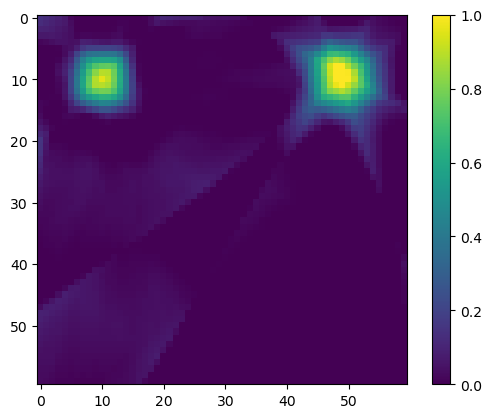

2600
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0078
loss from regularizer: 0.00017049911548383534
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0075
loss from regularizer: 0.0001693231170065701
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0077
loss from regularizer: 0.00016498364857397974
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0075
loss from regularizer: 0.0001761469175107777
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

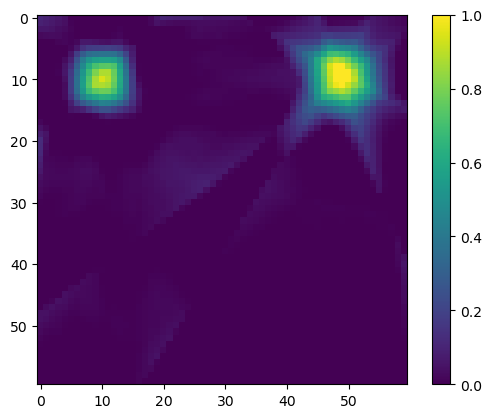

2610
176/176 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0080
loss from regularizer: 0.00016680189582984895
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0080
loss from regularizer: 0.00016732174844946712
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0089
loss from regularizer: 0.00017121649580076337
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0084
loss from regularizer: 0.0001660162233747542
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

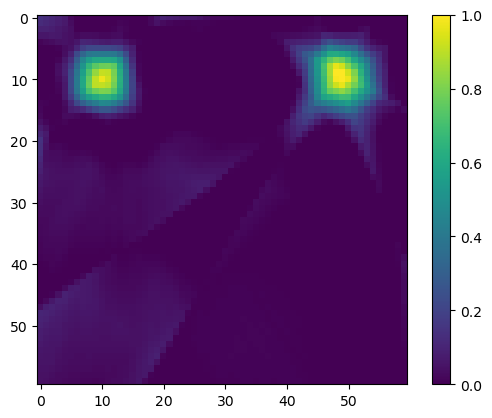

2620
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0074
loss from regularizer: 0.00016659943503327668
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0077
loss from regularizer: 0.00016647337179165334
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0081
loss from regularizer: 0.00016918359324336052
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0075
loss from regularizer: 0.00016501070058438927
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

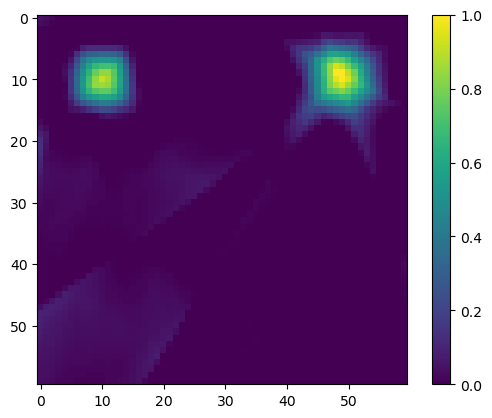

2630
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0083
loss from regularizer: 0.00016634580970276147
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0083 - val_loss: 0.0076
loss from regularizer: 0.00016792821406852454
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0083 - val_loss: 0.0073
loss from regularizer: 0.00017903187836054713
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0086
loss from regularizer: 0.00017514161299914122
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

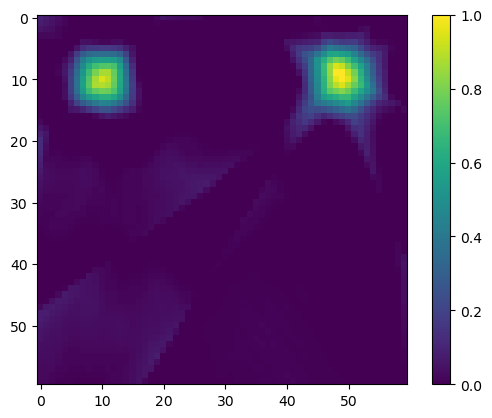

2640
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0081
loss from regularizer: 0.00016637692169751972
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0097
loss from regularizer: 0.00017602404113858938
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0078
loss from regularizer: 0.00017346155073028058
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0084
loss from regularizer: 0.0001636915112612769
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

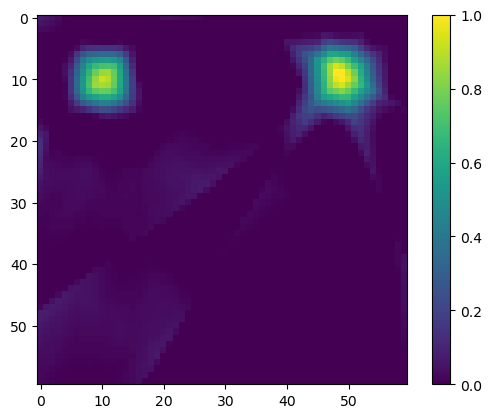

2650
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0074
loss from regularizer: 0.00016178644727915525
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0087
loss from regularizer: 0.00016493885777890682
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0084
loss from regularizer: 0.0001708834315650165
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0102
loss from regularizer: 0.00017525935254525393
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

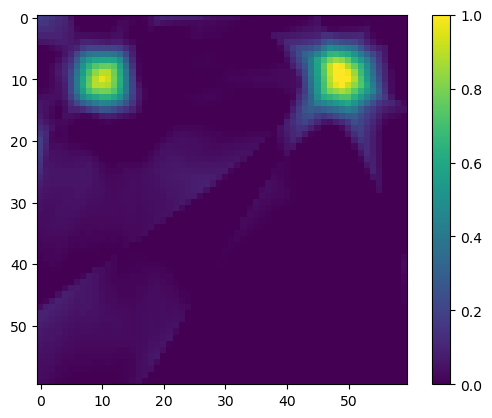

2660
176/176 [==============================] - 1s 6ms/step - loss: 0.0084 - val_loss: 0.0093
loss from regularizer: 0.00017591954383533448
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0080
loss from regularizer: 0.00016631685139145702
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0074
loss from regularizer: 0.00016688942559994757
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0075
loss from regularizer: 0.00016841344768181443
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

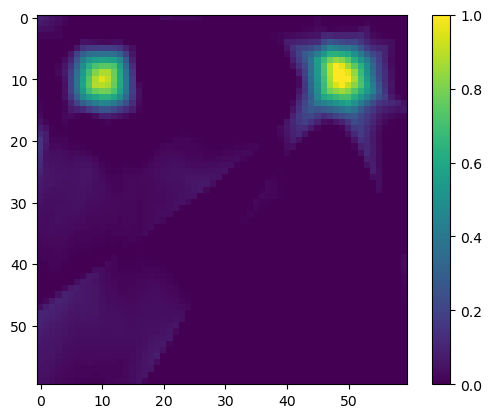

2670
176/176 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0078
loss from regularizer: 0.00016827734361868352
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0080
loss from regularizer: 0.00016945000970736146
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0075
loss from regularizer: 0.0001645499432925135
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0076
loss from regularizer: 0.00016438997408840805
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

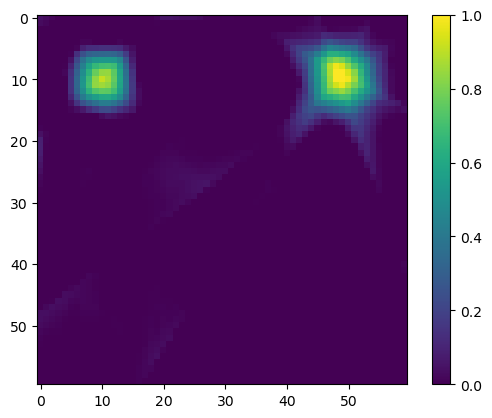

2680
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0080
loss from regularizer: 0.00016747854533605278
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0088
loss from regularizer: 0.0001711591612547636
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
loss from regularizer: 0.0001737907441565767
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0077
loss from regularizer: 0.00016813840193208307
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

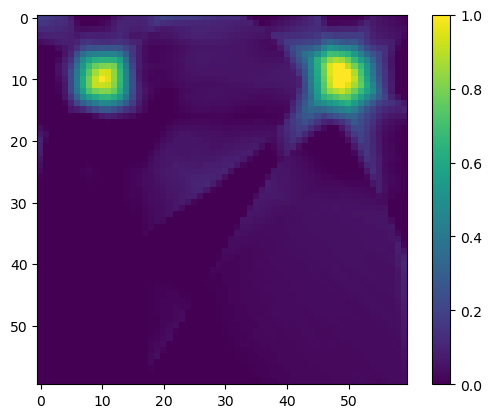

2690
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0075
loss from regularizer: 0.00017022596148308367
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0101
loss from regularizer: 0.00016729543858673424
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0079
loss from regularizer: 0.00016305303142871708
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0078
loss from regularizer: 0.0001692948571871966
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

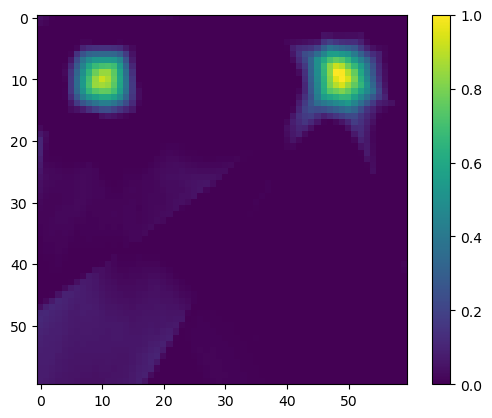

2700
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0080
loss from regularizer: 0.00016420750762335956
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 0.0075
loss from regularizer: 0.0001594902714714408
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0083 - val_loss: 0.0078
loss from regularizer: 0.0001642107527004555
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0080 - val_loss: 0.0081
loss from regularizer: 0.00016855364083312452
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

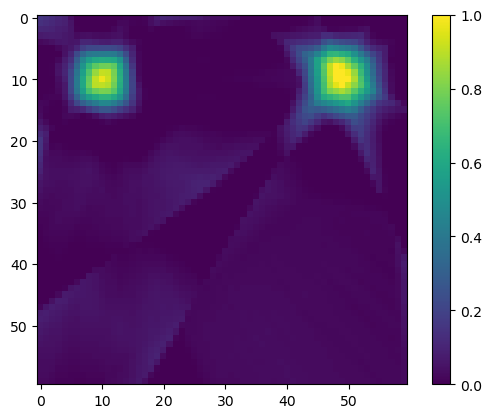

2710
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0103
loss from regularizer: 0.00016830075765028596
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0074
loss from regularizer: 0.00016701316053513438
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0088
loss from regularizer: 0.00016847823280841112
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0076
loss from regularizer: 0.0001650028716539964
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

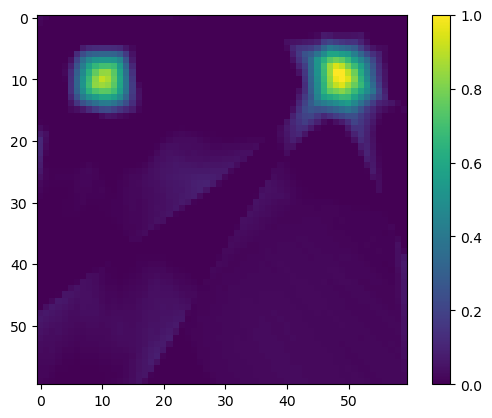

2720
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0078
loss from regularizer: 0.00016231591871473938
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0077
loss from regularizer: 0.00016643389244563878
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0075
loss from regularizer: 0.00016592130123171955
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0077
loss from regularizer: 0.00017009420844260603
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

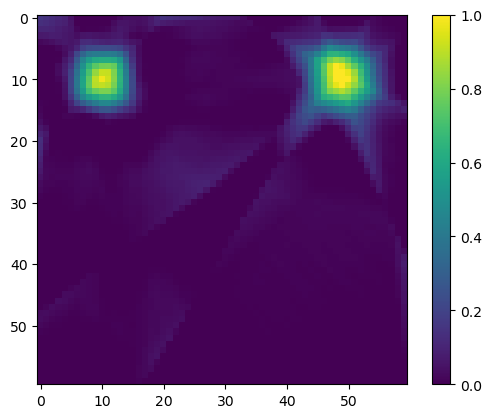

2730
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0075
loss from regularizer: 0.0001653117360547185
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0077
loss from regularizer: 0.00016702196444384754
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0115
loss from regularizer: 0.0001717209815979004
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0080
loss from regularizer: 0.00015796549268998206
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

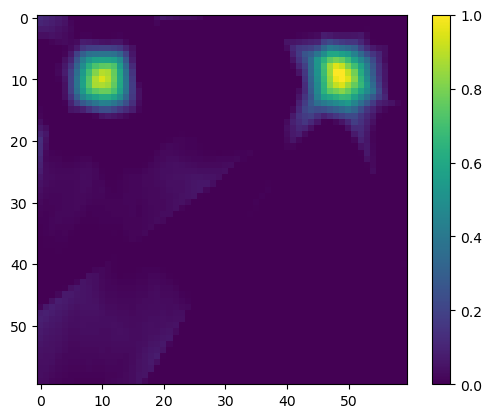

2740
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0077
loss from regularizer: 0.00017078794189728796
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0075
loss from regularizer: 0.00016896364104468375
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0082
loss from regularizer: 0.000170515151694417
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0076
loss from regularizer: 0.00016857250011526048
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

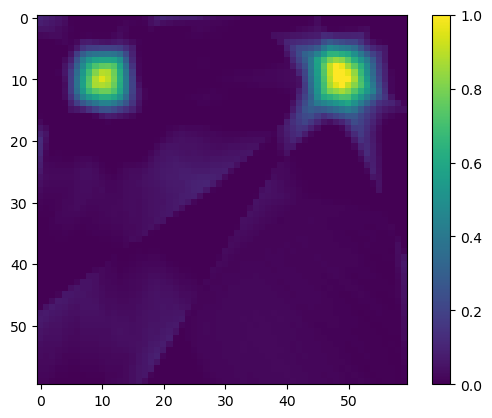

2750
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
loss from regularizer: 0.0001701743749435991
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0077
loss from regularizer: 0.00016405653150286525
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0079
loss from regularizer: 0.00017190306971315295
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0079
loss from regularizer: 0.0001607882441021502
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

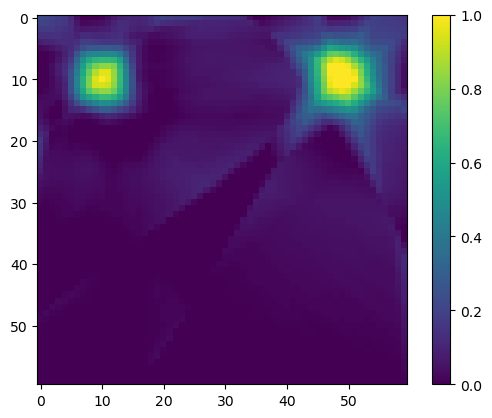

2760
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0075
loss from regularizer: 0.00016666077135596424
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0095
loss from regularizer: 0.0001720053405733779
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0084
loss from regularizer: 0.00016486580716446042
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0089
loss from regularizer: 0.00017036229837685823
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

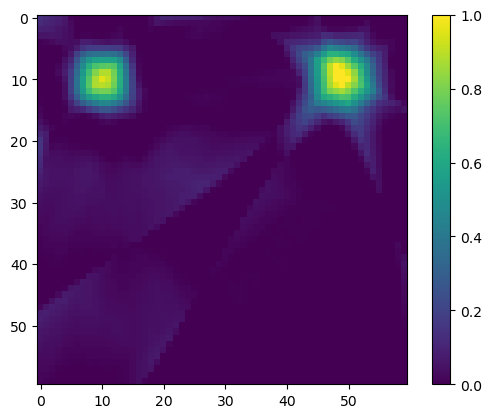

2770
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0087
loss from regularizer: 0.00016069412231445312
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0080
loss from regularizer: 0.00015803573478478938
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0074
loss from regularizer: 0.0001640633709030226
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0076
loss from regularizer: 0.00017188148922286928
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

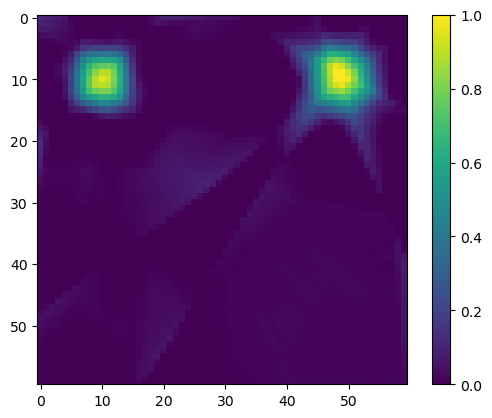

2780
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0091
loss from regularizer: 0.0001589656894793734
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0087
loss from regularizer: 0.00016328103083651513
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0075
loss from regularizer: 0.00016515438619535416
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0091
loss from regularizer: 0.00016540050273761153
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

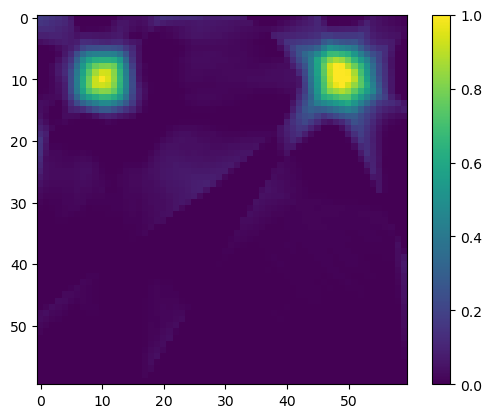

2790
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0076
loss from regularizer: 0.00017230489174835384
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
loss from regularizer: 0.00016411178512498736
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0078
loss from regularizer: 0.00016565366240683943
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0074
loss from regularizer: 0.00016210701141972095
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

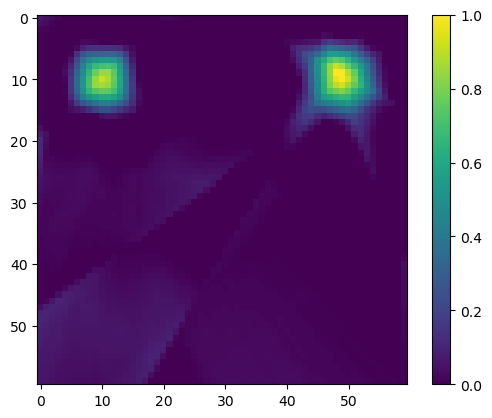

2800
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0082
loss from regularizer: 0.0001632162748137489
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0083
loss from regularizer: 0.00017062151164282113
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0095
loss from regularizer: 0.00016649287135805935
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0080
loss from regularizer: 0.0001654967782087624
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

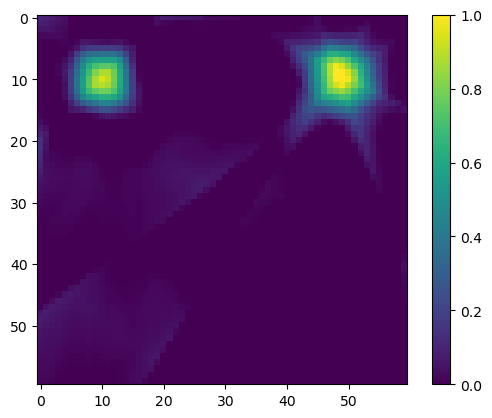

2810
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0082
loss from regularizer: 0.00016904858057387173
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0075
loss from regularizer: 0.0001728177594486624
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00016471192066092044
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0083
loss from regularizer: 0.00017033120093401521
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

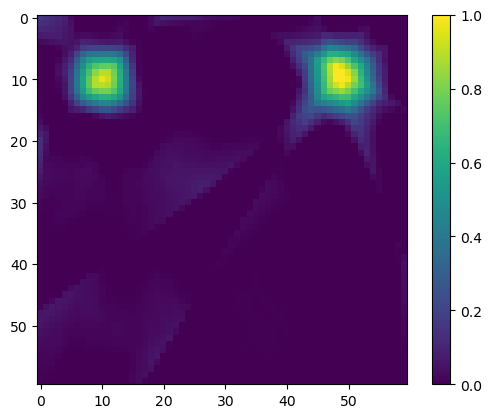

2820
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0083
loss from regularizer: 0.0001627434539841488
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0104
loss from regularizer: 0.0001670659548835829
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0078
loss from regularizer: 0.00016735999088268727
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0082
loss from regularizer: 0.0001665072632022202
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [=

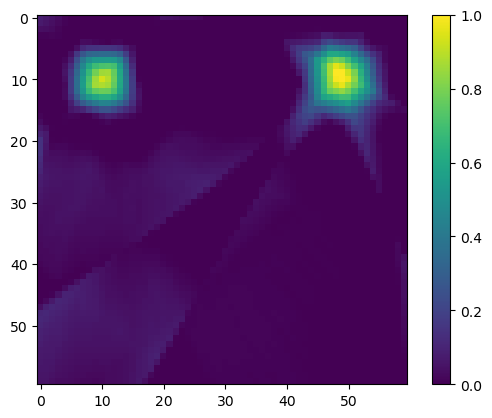

2830
176/176 [==============================] - 1s 6ms/step - loss: 0.0080 - val_loss: 0.0083
loss from regularizer: 0.00017112563364207745
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0080
loss from regularizer: 0.00016728871560189873
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0079
loss from regularizer: 0.0001722251472529024
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0080
loss from regularizer: 0.0001631876511964947
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

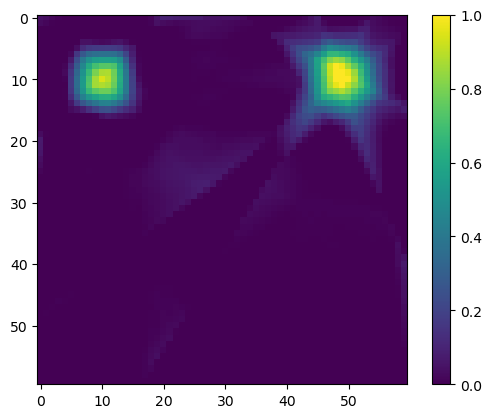

2840
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0077
loss from regularizer: 0.00016293804219458252
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0076
loss from regularizer: 0.00016673727077431977
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0075
loss from regularizer: 0.00017540217959322035
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0075
loss from regularizer: 0.0001657732209423557
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

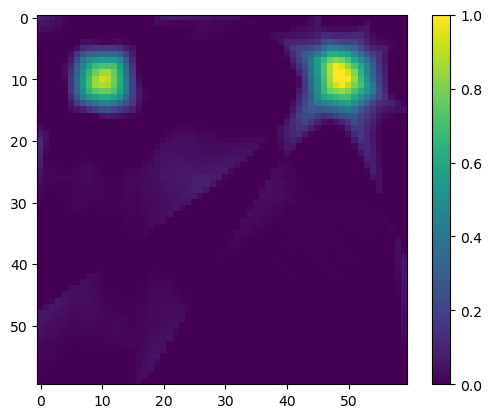

2850
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0081
loss from regularizer: 0.00015992444241419435
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0074
loss from regularizer: 0.00016919492918532342
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0075
loss from regularizer: 0.00016453868011012673
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0076
loss from regularizer: 0.00017586715694051236
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

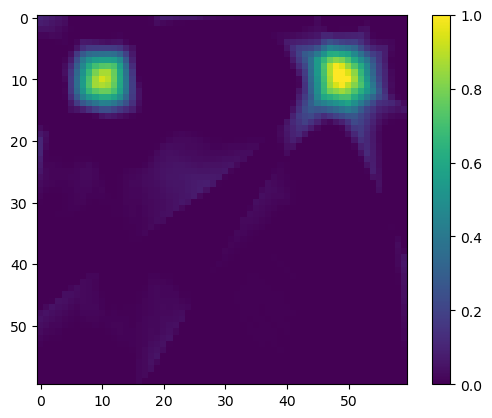

2860
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0083
loss from regularizer: 0.00017352937720716
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0075
loss from regularizer: 0.00016958845662884414
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0079
loss from regularizer: 0.0001676237880019471
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0077
loss from regularizer: 0.00016756454715505242
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==

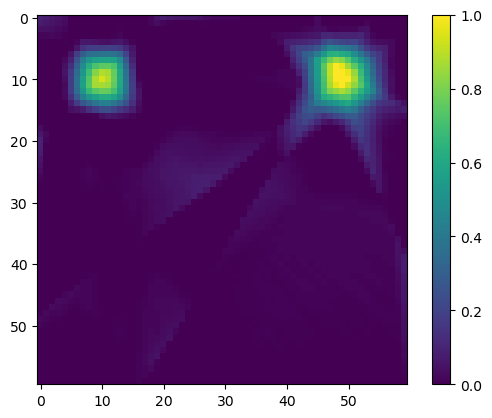

2870
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0084
loss from regularizer: 0.00016008804959710687
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0079
loss from regularizer: 0.00016548689745832235
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0075
loss from regularizer: 0.00016626644355710596
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0081
loss from regularizer: 0.00016835574933793396
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

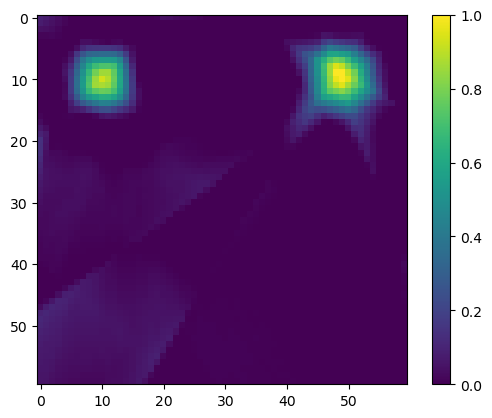

2880
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0075
loss from regularizer: 0.0001677415712038055
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0075
loss from regularizer: 0.00016830512322485447
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0104
loss from regularizer: 0.0001700898865237832
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0079
loss from regularizer: 0.00016315355605911463
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

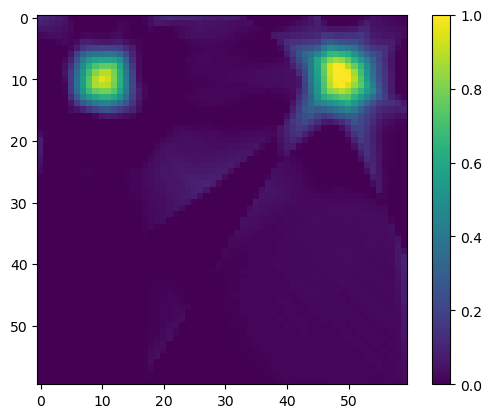

2890
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0076
loss from regularizer: 0.00016126215632539243
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0076
loss from regularizer: 0.00017034384654834867
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0102
loss from regularizer: 0.00017130134801845998
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0073
loss from regularizer: 0.00016697759565431625
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

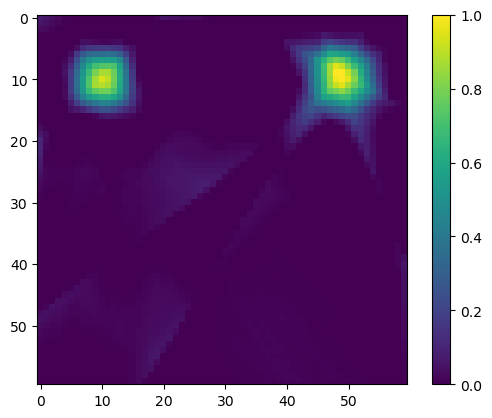

2900
176/176 [==============================] - 1s 5ms/step - loss: 0.0089 - val_loss: 0.0084
loss from regularizer: 0.000167481426615268
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0079
loss from regularizer: 0.00016415987920481712
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0099
loss from regularizer: 0.00017194781685248017
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0075
loss from regularizer: 0.00016630065510980785
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

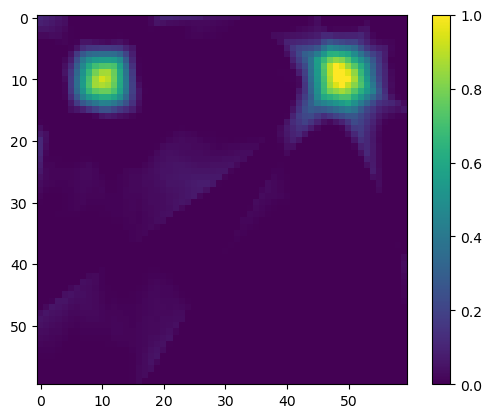

2910
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0078
loss from regularizer: 0.00016498594777658582
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0079
loss from regularizer: 0.0001674580853432417
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0080
loss from regularizer: 0.00016602483810856938
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0078
loss from regularizer: 0.00017079111421480775
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

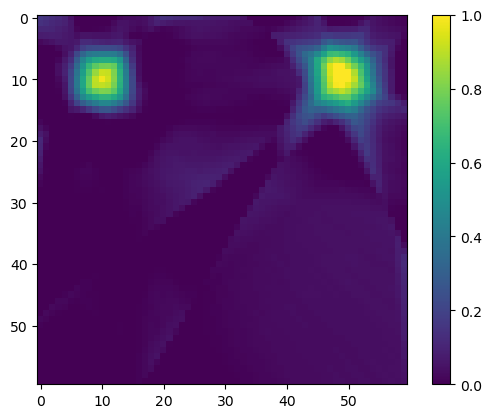

2920
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0078
loss from regularizer: 0.0001648603065405041
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0079
loss from regularizer: 0.00017195956024806947
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0074
loss from regularizer: 0.0001652779901633039
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0081
loss from regularizer: 0.00016748283815104514
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

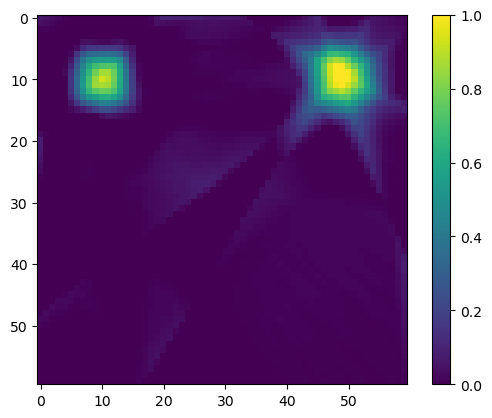

2930
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0073
loss from regularizer: 0.00016511297144461423
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0077
loss from regularizer: 0.00016886595403775573
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0075
loss from regularizer: 0.00016423215856775641
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0078 - val_loss: 0.0085
loss from regularizer: 0.0001648310717428103
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

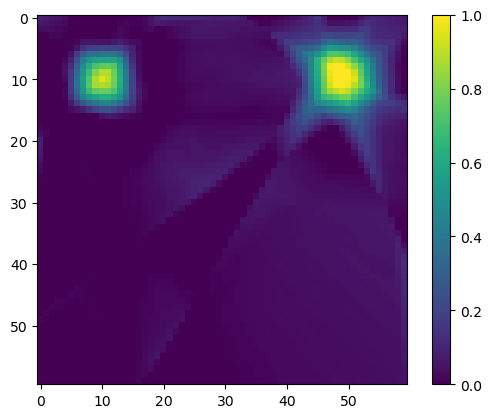

2940
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0077
loss from regularizer: 0.0001687473413767293
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0082
loss from regularizer: 0.00016875119763426483
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0090
loss from regularizer: 0.0001692839286988601
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0076
loss from regularizer: 0.00017451292660553008
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

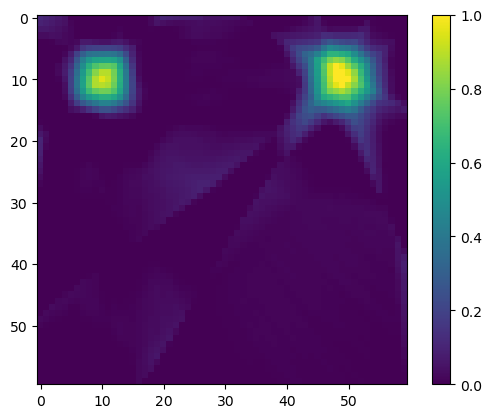

2950
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0096
loss from regularizer: 0.00016169717127922922
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0075
loss from regularizer: 0.0001661062560742721
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0078
loss from regularizer: 0.00016633902851026505
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0075
loss from regularizer: 0.00016405139467678964
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

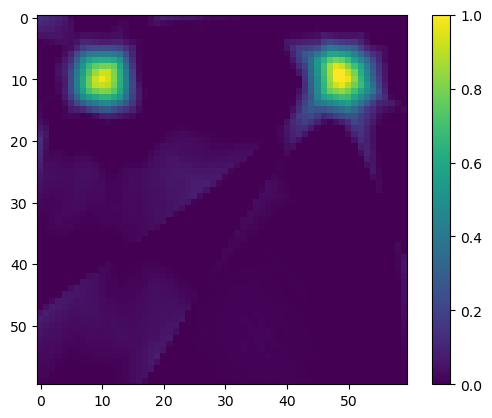

2960
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0081
loss from regularizer: 0.0001662069116719067
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0115
loss from regularizer: 0.00016953013255260885
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0074
loss from regularizer: 0.0001643863506615162
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0082
loss from regularizer: 0.00016970689466688782
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [

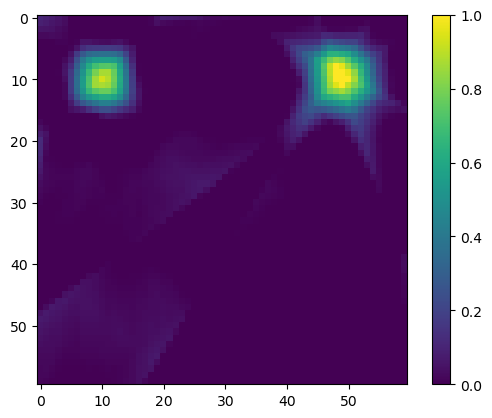

2970
176/176 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0082
loss from regularizer: 0.00016827632498461753
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0074
loss from regularizer: 0.00016866903752088547
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0081 - val_loss: 0.0083
loss from regularizer: 0.00016751304792705923
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 7ms/step - loss: 0.0080 - val_loss: 0.0093
loss from regularizer: 0.00016999058425426483
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

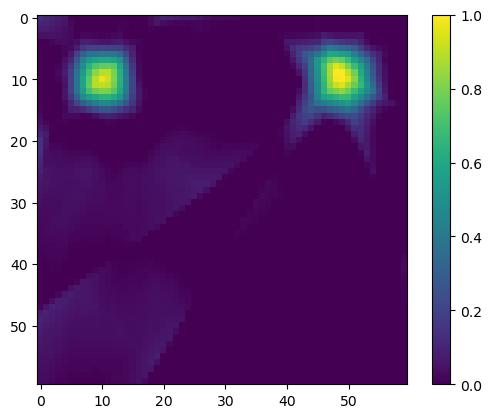

2980
176/176 [==============================] - 1s 5ms/step - loss: 0.0079 - val_loss: 0.0077
loss from regularizer: 0.00016248451720457524
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0088
loss from regularizer: 0.00016755811520852149
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0076
loss from regularizer: 0.0001754482655087486
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 6ms/step - loss: 0.0081 - val_loss: 0.0076
loss from regularizer: 0.00016373879043385386
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 

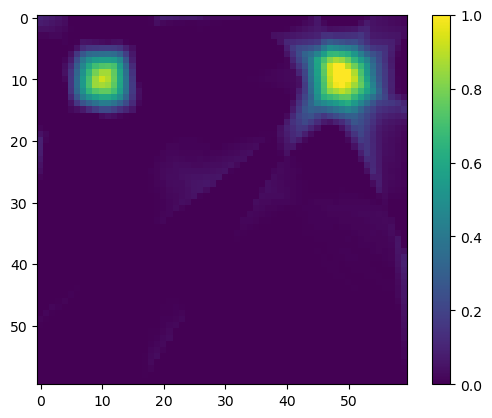

2990
176/176 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0091
loss from regularizer: 0.00016698188846930861
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0075
loss from regularizer: 0.00016880872135516256
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0086 - val_loss: 0.0098
loss from regularizer: 0.00017471620230935514
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 0.0078
loss from regularizer: 0.00016981159569695592
optimizer lr: <keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000020608A130D0>
176/176

In [175]:
lr1 = 0.001
lr2 = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr2,
    decay_steps=10000,
    decay_rate=0.98,
    staircase=True)

keras.backend.clear_session()
opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

simp_model = model_func(nodes = nodes)
simp_model.compile(optimizer = opt, loss = 'mse', )
simp_model.summary()

if retrain:
  with open(fol+"mod_dict_" + old_model_n + ".pk1", "rb") as f:
    old_mod_dict = pickle.load(f)
    f.close()

  keras.backend.clear_session()
  simp_model, loss_reg = model_func2(nodes = nodes, dict_mod = old_mod_dict)
  simp_model.compile(optimizer = opt, loss = 'mse', )
  print("Loading weights from previous model")
  simp_model.load_weights(fol + old_model_n +".h5")
  simp_model.summary()

predicted_r = simp_model.predict(pos)
pred_rew_bw = predicted_r.reshape((60,60))
rot_img = ndimage.rotate(pred_rew_bw, 90)
plt.imshow(rot_img)
plt.colorbar()
plt.clim(0,1)
plt.show()


for ii in range(epochs):
  
    num_images = pos[0]-1
    loss = []
    val_loss = []
    history = simp_model.fit(
              sub_pos_t[0],
              sub_r_t[0],
              epochs = 1 ,
              batch_size = 16,
              validation_data = (sub_pos_t[1], sub_r_t[1]),
              shuffle = True)
    
    kk = simp_model.layers
    print("loss from regularizer: " + str((K.eval(sum(kk[1].losses + kk[2].losses)))/4))
    print("optimizer lr: " + str(K.eval(simp_model.optimizer.lr)))

    if ii % 10 == 0:
    #   if retrain:
    #     simp_model.save(fol+ new_model_n +".h5")
    #     wts = simp_model.weights
        
    #     lr1 = lr1*0.96
    #     lr2 = lr2*0.96

    #     keras.backend.clear_session()
    #     opt = tf.keras.optimizers.SGD(learning_rate = lr2)
    #     simp_model, loss_reg = model_func2(nodes = nodes, dict_mod = old_mod_dict)
    #     simp_model.compile(optimizer = opt, loss = custom_lr_loss, )
    #     print("Loading weights from previous model")
    #     simp_model.load_weights(fol+ new_model_n +".h5")

      predicted_r = simp_model.predict(pos)
      pred_rew_bw = predicted_r.reshape((60,60))
      rot_img = ndimage.rotate(pred_rew_bw, 90)
      plt.imshow(rot_img)
      plt.colorbar()
      plt.clim(0,1)
      plt.show()
      print(ii)  

simp_model.save(fol+ new_model_n +".h5")
wts = simp_model.weights

113/113 [==============================] - 0s 2ms/step


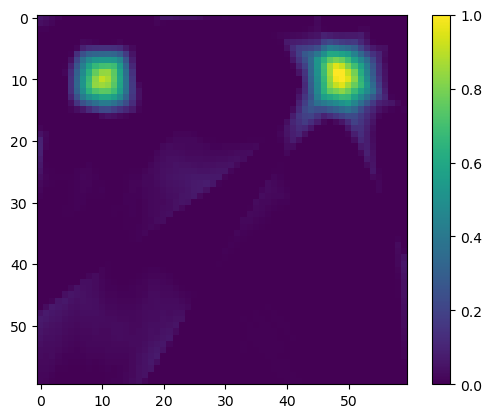

In [176]:
predicted_r = simp_model.predict(pos)
pred_rew_bw = predicted_r.reshape((60,60))
rot_img = ndimage.rotate(pred_rew_bw, 90)
plt.imshow(rot_img)
plt.colorbar()
plt.clim(0,1)
plt.show()
# print(ii)  

In [177]:
max(predicted_r)

array([1.0375974], dtype=float32)

In [178]:
simp_model.save(fol+ new_model_n +".h5")
wts = simp_model.weights

In [179]:
if Do_fisher:
  # img_ind = np.where(sub_r_t[0] == 1)
  # img_ind = [[]]

  print('Processing Fisher Information...')
  I_new = computer_fisher(simp_model, pos)
  print('Processing Finish!')
  hist_ = history.history

  # I_new = New_I.copy()
  New_I = I_new.copy()
  j = 0
  while j < len(New_I):
    max_w = np.amax(New_I[j])
    max_b = np.amax(New_I[j+1])
    max_t = max(max_w, max_b)

    if max_t == 0:
      New_I[j] = New_I[j]/(max_t + 0.00001)
      New_I[j+1] = New_I[j+1]/(max_t + 0.00001)
    else:
      New_I[j] = New_I[j]/max_t
      New_I[j+1] = New_I[j+1]/max_t
    
    j = j+2


  if Train:
    I_tot = New_I
  else: 
    if retrain:
      I = old_mod_dict["fisher"]
    I_tot = I + New_I

  model_dict = {"weights": wts, "fisher": I_tot, "history": hist_} 
  with open(fol+"mod_dict_" + new_model_n + ".pk1", 'wb') as ff:
      pickle.dump(model_dict, ff)
      ff.close()

Processing Fisher Information...
0


C:\Users\jarvez\AppData\Local\Temp\ipykernel_6160\3227038119.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)
C:\Users\jarvez\AppData\Local\Temp\ipykernel_6160\3227038119.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum += np.square(grads)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
Processing Finish!


In [180]:
for i in I_tot:
  print(np.amax(i))

0.67428654
1.054787
1.0
1.9700558


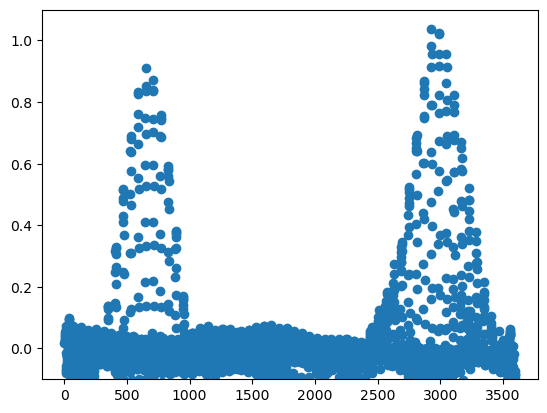

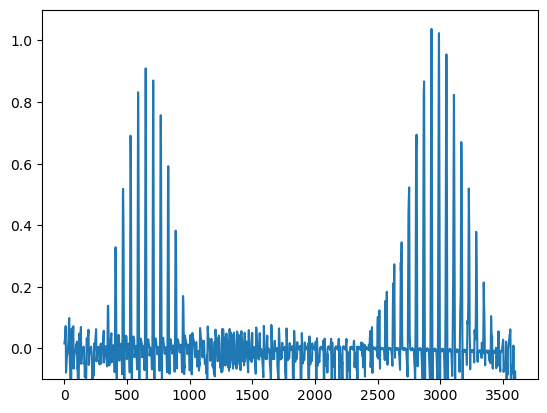

In [181]:
predicted_r.shape
plt.scatter(range(len(predicted_r)), predicted_r)
plt.ylim([-0.1, 1.1])
plt.show()

plt.plot(predicted_r)
plt.ylim([-0.1, 1.1])
plt.show()

In [182]:
# fol = main + fol1 + "/"
# traj = traj1
# obj_pres = True
# pos_temp = []
# reward = []

# # for pp in range(9):
# for i in np.linspace(-1, 1, 60, endpoint = True):
#   for j in np.linspace(0.3, 1, 20, endpoint = True):
#     p = Point(i,j)
#     pos_temp.append([i,j])

# for i in np.linspace(-1, 1, 60, endpoint = True):
#   for j in np.linspace(-0.4, 0.3, 20, endpoint = True):
#     p = Point(i,j)
#     pos_temp.append([i,j])

# for i in np.linspace(-1, 1, 60, endpoint = True):
#   for j in np.linspace(-1, -0.4, 20, endpoint = True):
#     p = Point(i,j)
#     pos_temp.append([i,j])

# reward = [0]*3200 + [1]*400

# traj_dict = {"pos": pos_temp, 'reward': reward}
# pos_temp = np.asarray(pos_temp)
# print(pos_temp[:,0].shape)
# print(sum(reward))
# print(len(reward))

# plt.scatter(pos_temp[:,0],pos_temp[:,1])
# plt.show()

# with open(fol + "traj_9.pk1", 'wb') as ff:
#     pickle.dump(traj_dict, ff)
#     ff.close()

In [183]:
# fol = main + fol1 + "/"
# traj = traj1
# obj_pres = True
# pos_temp = []
# reward = []

# # for pp in range(9):
# for i in np.linspace(-1, 1, 60, endpoint = True):
#   for j in np.linspace(-1, 1, 60, endpoint = True):
#     p = Point(i,j)
#     if ((i > -0.8 and i < -0.5) and (j > -0.8 and j < -0.5)):
#       reward.append(1)
#     else:
#       reward.append(0)
#     pos_temp.append([i,j])
# pos_temp = np.asarray(pos_temp)
# print(pos_temp)
# print(reward)
# plt.scatter(pos_temp[:,0], pos_temp[:,1])
# plt.show()
# traj_dict = {"pos": pos_temp, 'reward': reward}
# with open(fol + "Aztraj_7.pk1", 'wb') as ff:
#     pickle.dump(traj_dict, ff)
#     ff.close()
#for i in np.linspace()